<a href="https://colab.research.google.com/github/MayaHayat/FinalProject-DDSM/blob/main/Final_united_mass_file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from os import listdir
import glob
import random
import copy

import cv2
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.image import imread

import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from keras.utils import to_categorical
import keras.utils as image

from sklearn.ensemble import (
    AdaBoostClassifier, ExtraTreesClassifier, RandomForestClassifier
)
from sklearn.linear_model import (
    LogisticRegression, Ridge, RidgeClassifier
)
from sklearn.metrics import (
    accuracy_score, classification_report, cohen_kappa_score,
    confusion_matrix, f1_score, matthews_corrcoef, precision_score,
    recall_score, roc_auc_score
)
from sklearn.model_selection import (
    GroupKFold, StratifiedKFold, train_test_split
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
colors = ['#D0E0CD', '#e4cfc3', '#D7CCC8', '#F5E1DA', '#EDE7E3', '#DFE4D4', '#C9C5BA']

# Create a custom colormap
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

# Register the custom colormap with a different name
plt.register_cmap(name='custom_cmap_v', cmap=cmap)

# Set the color cycle globally
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

# Optional: Set a default colormap for images
plt.rcParams['image.cmap'] = 'custom_cmap_v'

<ipython-input-3-ec341f1052fc>:7: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.register_cmap(name='custom_cmap_v', cmap=cmap)


In [4]:
mass_train = pd.read_csv('/content/drive/MyDrive/DDSM data/mass_case_description_train_set.csv', sep=',')
mass_test = pd.read_csv('/content/drive/MyDrive/DDSM data/mass_case_description_test_set.csv', sep=',')
mass = pd.concat([mass_train, mass_test], axis=0)
mass.reset_index(drop=True, inplace=True)

In [5]:
# Adding 'tumor_id' column with unique numbers for later analysis
mass['tumor_id'] = range(1, len(mass) + 1)

In [6]:
mass['pathology'] = mass['pathology'].replace('BENIGN_WITHOUT_CALLBACK', 'BENIGN')

In [7]:
# Add another column to note if a patient has multiple tumors in the same breast
grouped_data = mass.groupby(['patient_id', 'left or right breast'])

def calculate_multiple_tumors(group):
    max_abnormality_id = group['abnormality id'].max()
    return pd.Series({tumor_id: (0 if max_abnormality_id == 1 else 1)
                      for tumor_id in group['abnormality id']})

multiple_tumors_df = grouped_data.apply(calculate_multiple_tumors).unstack().reset_index()

multiple_tumors_df = multiple_tumors_df.rename(columns={'level_2': 'abnormality id'})

multiple_tumors_melted = multiple_tumors_df.melt(id_vars=['patient_id', 'left or right breast'],
                                                 var_name='abnormality id',
                                                 value_name='multiple_tumors')

mass = mass.merge(multiple_tumors_melted, on=['patient_id', 'left or right breast', 'abnormality id'], how='left')

<ipython-input-7-488bc05b9800>:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  multiple_tumors_df = grouped_data.apply(calculate_multiple_tumors).unstack().reset_index()


In [8]:
full_mass = mass

In [9]:
unique_shapes = mass['mass shape'].unique()
unique_margins = mass['mass margins'].unique()

print("Unique 'mass shape' values:")
print(unique_shapes)

print("\nUnique 'mass margins' values:")
print(unique_margins)

Unique 'mass shape' values:
['IRREGULAR-ARCHITECTURAL_DISTORTION' 'ARCHITECTURAL_DISTORTION' 'OVAL'
 'IRREGULAR' 'LYMPH_NODE' 'LOBULATED-LYMPH_NODE' 'LOBULATED'
 'FOCAL_ASYMMETRIC_DENSITY' 'ROUND' 'LOBULATED-ARCHITECTURAL_DISTORTION'
 'ASYMMETRIC_BREAST_TISSUE' 'LOBULATED-IRREGULAR' nan 'OVAL-LYMPH_NODE'
 'LOBULATED-OVAL' 'ROUND-OVAL' 'IRREGULAR-FOCAL_ASYMMETRIC_DENSITY'
 'ROUND-IRREGULAR-ARCHITECTURAL_DISTORTION' 'ROUND-LOBULATED'
 'OVAL-LOBULATED' 'IRREGULAR-ASYMMETRIC_BREAST_TISSUE']

Unique 'mass margins' values:
['SPICULATED' 'ILL_DEFINED' 'CIRCUMSCRIBED' 'ILL_DEFINED-SPICULATED'
 'OBSCURED' 'OBSCURED-ILL_DEFINED' nan 'MICROLOBULATED'
 'MICROLOBULATED-ILL_DEFINED-SPICULATED' 'MICROLOBULATED-SPICULATED'
 'CIRCUMSCRIBED-ILL_DEFINED' 'MICROLOBULATED-ILL_DEFINED'
 'CIRCUMSCRIBED-OBSCURED' 'OBSCURED-SPICULATED'
 'OBSCURED-ILL_DEFINED-SPICULATED' 'CIRCUMSCRIBED-MICROLOBULATED'
 'OBSCURED-CIRCUMSCRIBED' 'CIRCUMSCRIBED-SPICULATED'
 'CIRCUMSCRIBED-OBSCURED-ILL_DEFINED'
 'CIRCUMSCRIBED-MICR

In [10]:
mass_new = mass

In [11]:
mass_new['mass shape'] = mass_new['mass shape'].fillna('undefined_shape')

# Split the 'mass shape' entries by '-' and explode them into individual rows
exploded_mass = mass_new.assign(mass_shape=mass_new['mass shape'].str.split('-')).explode('mass_shape')
one_hot_mass = pd.get_dummies(exploded_mass['mass_shape'])
result_mass_shape = mass_new.drop(columns=['mass shape']).join(one_hot_mass.groupby(one_hot_mass.index).sum())
result_mass_shape = result_mass_shape.drop('undefined_shape', axis = 1)

In [12]:
result_mass_shape['mass margins'] = mass['mass margins'].fillna('')

# Split the 'mass shape' entries by '-' and explode them into individual rows
exploded_mass = result_mass_shape.assign(mass_margins=result_mass_shape['mass margins'].str.split('-')).explode('mass_margins')

one_hot_mass = pd.get_dummies(exploded_mass['mass_margins'])
result_mass = result_mass_shape.drop(columns=['mass margins']).join(one_hot_mass.groupby(one_hot_mass.index).sum())
result_mass = result_mass.drop('', axis = 1)

# Analysing the original data

In [13]:
result_mass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1696 entries, 0 to 1695
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   patient_id                1696 non-null   object 
 1   breast_density            1696 non-null   int64  
 2   left or right breast      1696 non-null   object 
 3   image view                1696 non-null   object 
 4   abnormality id            1696 non-null   object 
 5   abnormality type          1696 non-null   object 
 6   assessment                1696 non-null   int64  
 7   pathology                 1696 non-null   object 
 8   subtlety                  1696 non-null   int64  
 9   image file path           1696 non-null   object 
 10  cropped image file path   1696 non-null   object 
 11  ROI mask file path        1696 non-null   object 
 12  tumor_id                  1696 non-null   int64  
 13  multiple_tumors           1696 non-null   float64
 14  ARCHITEC

In [14]:
mass = result_mass

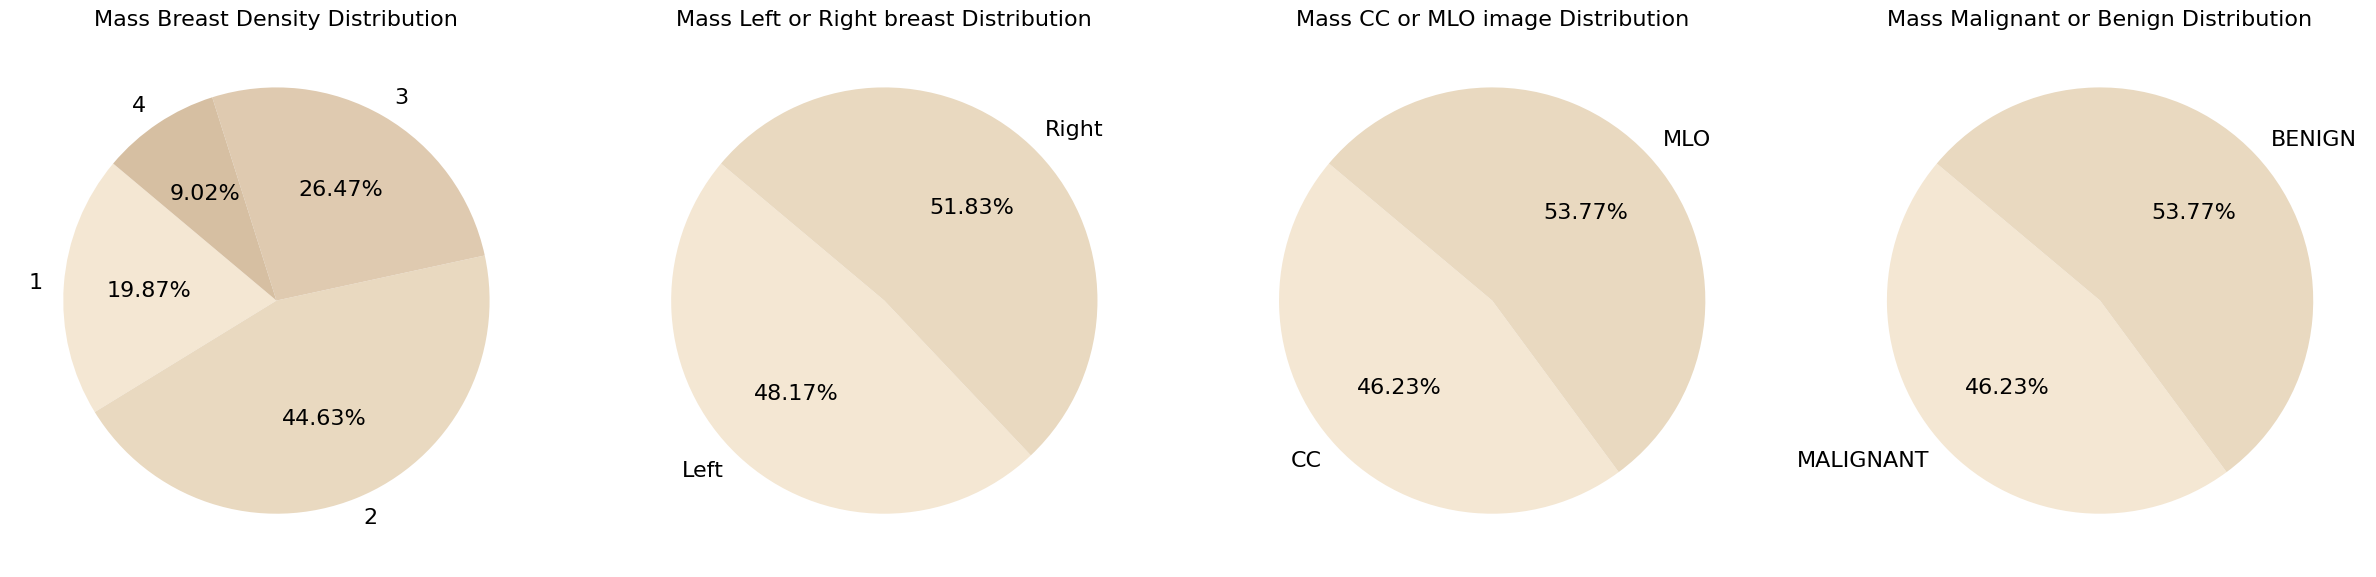

In [15]:
# Create a 2x2 grid of subplots
fig, ax = plt.subplots(1, 4, figsize=(24, 6))
((ax1, ax2, ax3, ax4)) = ax

colors = ['#f4e7d3', '#e9d9c0', '#dfcab0', '#d6bfa2']

# 1 - Laterality Distribution
density_count = mass['breast_density'].value_counts()
count_1 = density_count.loc[1]
count_2 = density_count.loc[2]
count_3 = density_count.loc[3]
count_4 = density_count.loc[4]

ax1.pie([count_1, count_2, count_3, count_4], labels=['1', '2', '3', '4'], autopct='%1.2f%%', startangle=140, textprops={'fontsize': 16}, colors = colors)
ax1.set_title('Mass Breast Density Distribution', fontsize=16)


# 2 - Orientation Distribution
mass_side = mass['left or right breast'].value_counts()
count_Left = mass_side.get('LEFT', 0)
count_Right = mass_side.get('RIGHT', 0)

ax2.pie([count_Left, count_Right], labels=['Left', 'Right'], autopct='%1.2f%%', startangle=140, textprops={'fontsize': 16}, colors = colors)
ax2.set_title('Mass Left or Right breast Distribution', fontsize=16)


# 3 - CC vs MLO
mass_side = mass['image view'].value_counts()
count_CC = mass_side.get('CC', 0)
count_MLO = mass_side.get('MLO', 0)

ax3.pie([count_CC, count_MLO], labels=['CC', 'MLO'],  autopct='%1.2f%%', startangle=140, textprops={'fontsize': 16}, colors = colors)
ax3.set_title('Mass CC or MLO image Distribution', fontsize=16)

# 4 - Malignant or benign
mass_side = mass['pathology'].value_counts()
count_malignant = mass_side.get('MALIGNANT', 0)
count_benign = mass_side.get('BENIGN', 0)

ax4.pie([count_malignant, count_benign], labels=['MALIGNANT', 'BENIGN'], autopct='%1.2f%%', startangle=140, textprops={'fontsize': 16}, colors = colors)
ax4.set_title('Mass Malignant or Benign Distribution', fontsize=16)


# Adjust layout and display the plot
plt.tight_layout()
plt.show()

After having looked at the data's distribution, we would like to see how the malignant and benign tumors are divided through out the same data.

In [16]:
mass['malignant'] = mass['pathology'].map({'MALIGNANT': 1, 'BENIGN': 0})

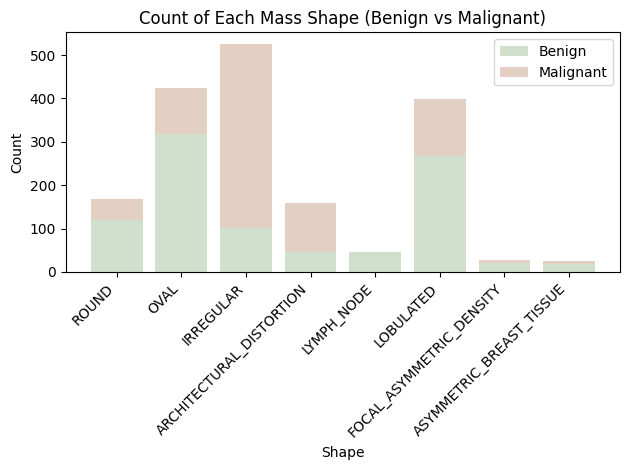

In [17]:
shapes_of_interest = ['ROUND', 'OVAL', 'IRREGULAR', 'ARCHITECTURAL_DISTORTION', 'LYMPH_NODE',
                      'LOBULATED', 'FOCAL_ASYMMETRIC_DENSITY', 'ASYMMETRIC_BREAST_TISSUE']

malignant_mass = mass[mass['malignant'] == 1]
benign_mass = mass[mass['malignant'] == 0]

malignant_sums = malignant_mass[shapes_of_interest].sum()
benign_sums = benign_mass[shapes_of_interest].sum()

fig, ax = plt.subplots()

ax.bar(shapes_of_interest, benign_sums, label='Benign')
ax.bar(shapes_of_interest, malignant_sums, bottom=benign_sums, label='Malignant')
ax.set_xlabel('Shape')
ax.set_ylabel('Count')
ax.set_title('Count of Each Mass Shape (Benign vs Malignant)')

plt.xticks(rotation=45, ha='right')

ax.legend()
plt.tight_layout()
plt.show()


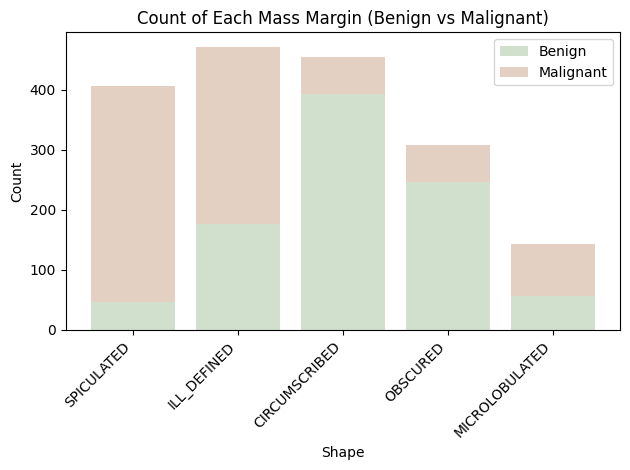

In [18]:

shapes_of_interest = ['SPICULATED', 'ILL_DEFINED', 'CIRCUMSCRIBED', 'OBSCURED', 'MICROLOBULATED']

malignant_mass = mass[mass['malignant'] == 1]
benign_mass = mass[mass['malignant'] == 0]

malignant_sums = malignant_mass[shapes_of_interest].sum()
benign_sums = benign_mass[shapes_of_interest].sum()

fig, ax = plt.subplots()

ax.bar(shapes_of_interest, benign_sums, label='Benign')

ax.bar(shapes_of_interest, malignant_sums, bottom=benign_sums, label='Malignant')
ax.set_xlabel('Shape')
ax.set_ylabel('Count')
ax.set_title('Count of Each Mass Margin (Benign vs Malignant)')

plt.xticks(rotation=45, ha='right')

ax.legend()
plt.tight_layout()
plt.show()


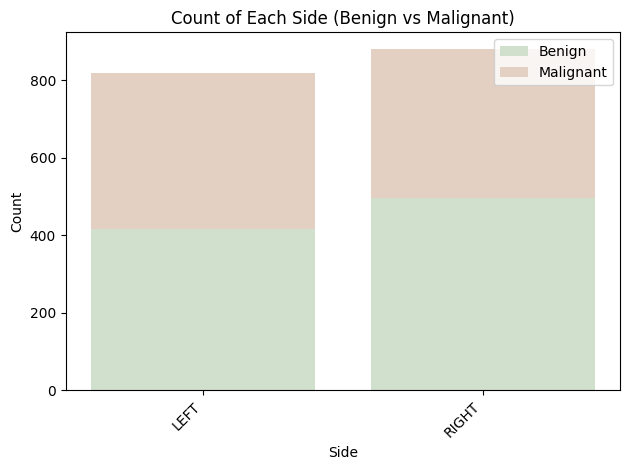

In [19]:
# Filter malignant and benign masses
malignant_mass = mass[mass['malignant'] == 1]
benign_mass = mass[mass['malignant'] == 0]

# Count occurrences for each side
malignant_sums = malignant_mass['left or right breast'].value_counts()
benign_sums = benign_mass['left or right breast'].value_counts()

# Ensure both malignant and benign have the same indices
side_of_interest = ['LEFT', 'RIGHT']
malignant_sums = malignant_sums.reindex(side_of_interest, fill_value=0)
benign_sums = benign_sums.reindex(side_of_interest, fill_value=0)

fig, ax = plt.subplots()

# Plot benign and malignant counts
ax.bar(side_of_interest, benign_sums, label='Benign')
ax.bar(side_of_interest, malignant_sums, bottom=benign_sums, label='Malignant')

ax.set_xlabel('Side')
ax.set_ylabel('Count')
ax.set_title('Count of Each Side (Benign vs Malignant)')
ax.legend()

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

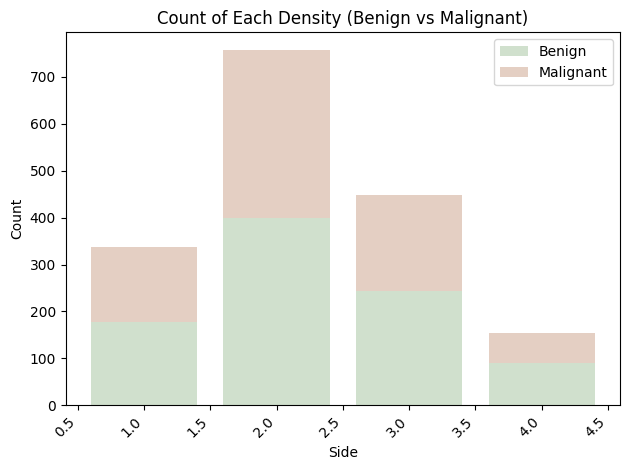

In [20]:
# Filter malignant and benign masses
malignant_mass = mass[mass['malignant'] == 1]
benign_mass = mass[mass['malignant'] == 0]

# Count occurrences for each side
malignant_sums = malignant_mass['breast_density'].value_counts()
benign_sums = benign_mass['breast_density'].value_counts()

# Ensure both malignant and benign have the same indices
side_of_interest = [1, 2, 3, 4]
malignant_sums = malignant_sums.reindex(side_of_interest, fill_value=0)
benign_sums = benign_sums.reindex(side_of_interest, fill_value=0)

fig, ax = plt.subplots()

# Plot benign and malignant counts
ax.bar(side_of_interest, benign_sums, label='Benign')
ax.bar(side_of_interest, malignant_sums, bottom=benign_sums, label='Malignant')

ax.set_xlabel('Side')
ax.set_ylabel('Count')
ax.set_title('Count of Each Density (Benign vs Malignant)')
ax.legend()

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

As we can see, the only two attributes that have different malignant and benign distributions are the mass margins and shape, therefore we will need to further explore their affect.

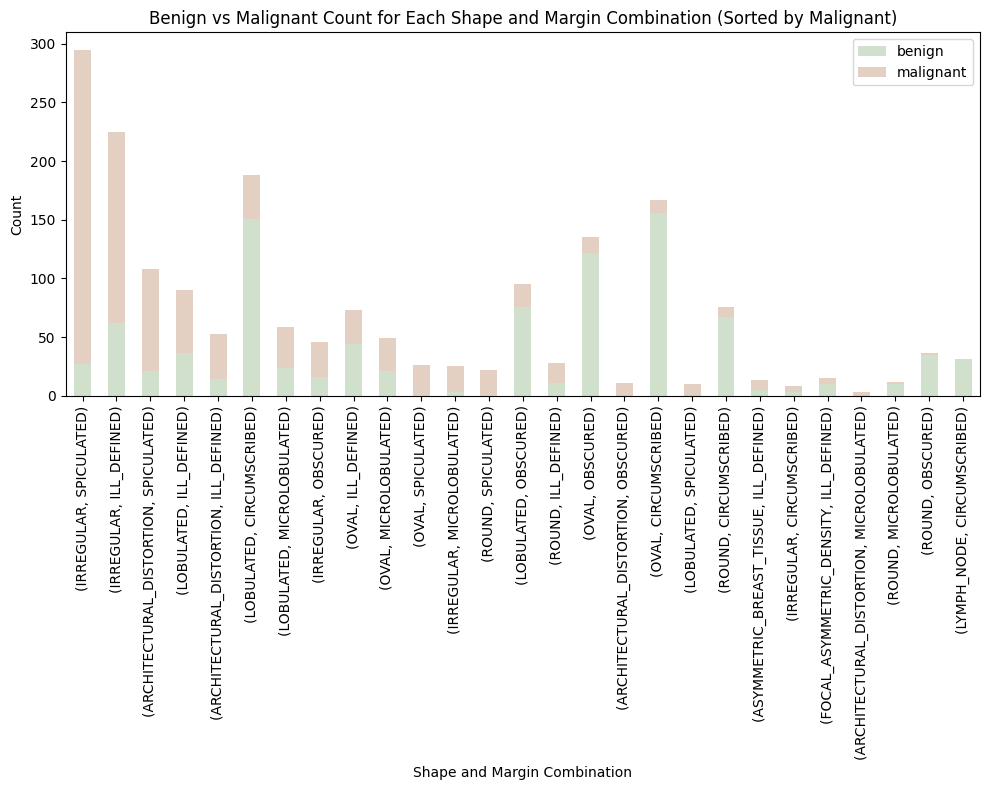

In [21]:
shapes_of_interest = ['IRREGULAR', 'ARCHITECTURAL_DISTORTION', 'OVAL', 'LYMPH_NODE',
                      'LOBULATED', 'FOCAL_ASYMMETRIC_DENSITY', 'ASYMMETRIC_BREAST_TISSUE', 'ROUND']

margins_of_interest = ['SPICULATED', 'ILL_DEFINED', 'CIRCUMSCRIBED', 'OBSCURED', 'MICROLOBULATED']

# Create a DataFrame to store the counts
combinations = []

# Loop through each shape and margin combination
for shape in shapes_of_interest:
    for margin in margins_of_interest:
        # Count the number of benign and malignant cases for each combination
        malignant_count = mass[(mass[shape] == 1) & (mass[margin] == 1) & (mass['malignant'] == 1)].shape[0]
        benign_count = mass[(mass[shape] == 1) & (mass[margin] == 1) & (mass['malignant'] == 0)].shape[0]

        # Append the result to the combinations list
        combinations.append({'shape': shape, 'margin': margin, 'malignant': malignant_count, 'benign': benign_count})

# Convert to DataFrame for easier manipulation
combinations_df = pd.DataFrame(combinations)

# Filter combinations that have more than 1 appearance (either malignant or benign)
combinations_df = combinations_df[(combinations_df['malignant'] + combinations_df['benign']) > 1]

# Sort the DataFrame by malignant count in descending order
combinations_df = combinations_df.sort_values(by='malignant', ascending=False)

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))

# Stack the bars for malignant and benign counts with the specified colors
combinations_df.set_index(['shape', 'margin'])[['benign', 'malignant']].plot(
    kind='bar',
    stacked=True,
    ax=ax
)

# Adding labels and title
ax.set_xlabel('Shape and Margin Combination')
ax.set_ylabel('Count')
ax.set_title('Benign vs Malignant Count for Each Shape and Margin Combination (Sorted by Malignant)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

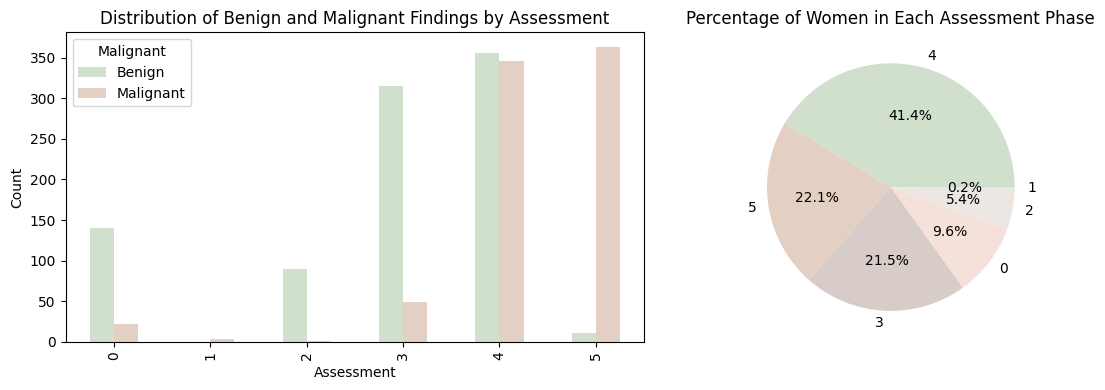

In [22]:
grouped_data = mass.groupby(['assessment', 'malignant']).size().unstack(fill_value=0)
assessment_counts = mass['assessment'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

grouped_data.plot(kind='bar', stacked=False, ax=ax1)

ax1.set_xlabel('Assessment')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of Benign and Malignant Findings by Assessment')
ax1.legend(title='Malignant', labels=['Benign', 'Malignant'])

ax2.pie(assessment_counts, labels=assessment_counts.index, autopct='%1.1f%%')
ax2.set_title('Percentage of Women in Each Assessment Phase')

plt.tight_layout()
plt.show()


In [23]:
grouped_data_array = grouped_data.to_numpy()
percentages = (grouped_data_array / grouped_data_array.sum(axis=1)[:, np.newaxis] * 100).round(2)
percentages_df = pd.DataFrame(percentages, index=grouped_data.index, columns=grouped_data.columns)

for assessment, row in percentages_df.iterrows():
    print(f"Assessment {assessment}: Benign: {row[0]}%, Malignant: {row[1]}%")


Assessment 0: Benign: 86.42%, Malignant: 13.58%
Assessment 1: Benign: 0.0%, Malignant: 100.0%
Assessment 2: Benign: 98.9%, Malignant: 1.1%
Assessment 3: Benign: 86.54%, Malignant: 13.46%
Assessment 4: Benign: 50.71%, Malignant: 49.29%
Assessment 5: Benign: 2.94%, Malignant: 97.06%


In [24]:
mass = mass.drop(columns=['image file path', 'cropped image file path', 'ROI mask file path', 'subtlety', 'assessment', 'abnormality type'])

In [25]:
mass_new = mass

In [26]:
columns_to_encode_mass = ['breast_density','left or right breast', 'image view']
mass_one_hot = pd.get_dummies(mass, columns=columns_to_encode_mass, dtype=int)
mass_one_hot = mass_one_hot.drop('pathology', axis =1)

mass_one_hot

patient_id abnormality id  tumor_id  multiple_tumors  \
0       P_00001              1         1              0.0   
1       P_00001              1         2              0.0   
2       P_00004              1         3              0.0   
3       P_00004              1         4              0.0   
4       P_00004              1         5              0.0   
...         ...            ...       ...              ...   
1691    P_01825              1      1692              0.0   
1692    P_01833              1      1693              0.0   
1693    P_01865              1      1694              0.0   
1694    P_01912              1      1695              0.0   
1695    P_01912              1      1696              0.0   

      ARCHITECTURAL_DISTORTION  ASYMMETRIC_BREAST_TISSUE  \
0                            1                         0   
1                            1                         0   
2                            1                         0   
3                            1                         0   
4                            0                         0   
...                        ...                       ...   
1691                         0                         0   
1692                         0                         0   
1693                         0                         0   
1694                         0                         0   
1695                         0                         0   

      FOCAL_ASYMMETRIC_DENSITY  IRREGULAR  LOBULATED  LYMPH_NODE  ...  \
0                            0          1          0           0  ...   
1                            0          1          0           0  ...   
2                            0          0          0           0  ...   
3                            0          0          0           0  ...   
4                            0          0          0           0  ...   
...                        ...        ...        ...         ...  ...   
1691                         0          0          1           0  ...   
1692                         0          1          0           0  ...   
1693                         0          1          0           0  ...   
1694                         0          1          0           0  ...   
1695                         0          1          0           0  ...   

      SPICULATED  malignant  breast_density_1  breast_density_2  \
0              1          1                 0                 0   
1              1          1                 0                 0   
2              0          0                 0                 0   
3              0          0                 0                 0   
4              0          0                 0                 0   
...          ...        ...               ...               ...   
1691           0          0                 0                 1   
1692           0          1                 0                 1   
1693           0          1                 0                 1   
1694           1          1                 0                 0   
1695           1          1                 0                 0   

      breast_density_3  breast_density_4  left or right breast_LEFT  \
0                    1                 0                          1   
1                    1                 0                          1   
2                    1                 0                          1   
3                    1                 0                          1   
4                    1                 0                          0   
...                ...               ...                        ...   
1691                 0                 0                          0   
1692                 0                 0                          0   
1693                 0                 0                          1   
1694                 1                 0                          0   
1695                 1                 0                          0   

      left or ri

# Compare models
Create a table per each algorithm and iteration (100 iterations) with 10 folds for cross validation


In [ ]:
def compare_models(df, num_runs, output_path):

  # Define models
  models = {
      "Logistic Regression": LogisticRegression(max_iter=500),
      "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
      "Ridge Classifier": RidgeClassifier(),
      "Ada Boost Classifier": AdaBoostClassifier(),
      "Extra Trees Classifier": ExtraTreesClassifier(),
      "LightGBM": LGBMClassifier(),
      "XGBoost": XGBClassifier(),
      "Random Forest": RandomForestClassifier(),
      "K Neighbors Classifier": KNeighborsClassifier(),
      "Decision Tree": DecisionTreeClassifier(),
      "SVM - Linear": SVC(kernel='linear', probability=True),
      "Naive Bayes": GaussianNB()
  }

  n_splits = 10

  for run in range(num_runs):
      # Shuffle and reset the index of the original DataFrame
      tumor_features_df_shuffled = df.sample(frac=1, random_state=42*run).reset_index(drop=True)

      # Features and target
      X = tumor_features_df_shuffled.drop(['malignant', 'patient_id', 'tumor_id', 'abnormality id'], axis=1)
      y = tumor_features_df_shuffled['malignant']
      groups = tumor_features_df_shuffled['patient_id']
      abnormality_ids = tumor_features_df_shuffled['abnormality id']
      tumor_id = tumor_features_df_shuffled['tumor_id']

      # Replace whitespaces in feature names with underscores
      X.columns = [col.replace(" ", "_") for col in X.columns]

      all_predictions = []

      # Get unique patient IDs
      unique_patient_ids = groups.unique()
      np.random.seed(42*run)  # Set seed for reproducibility

      # Shuffle the patient IDs
      np.random.shuffle(unique_patient_ids)

      # Split the patient IDs into folds
      fold_size = len(unique_patient_ids) // n_splits
      predefined_splits = []

      for fold in range(n_splits):
          test_ids = unique_patient_ids[fold * fold_size: (fold + 1) * fold_size]
          train_ids = np.setdiff1d(unique_patient_ids, test_ids)
          predefined_splits.append((train_ids, test_ids))

      # Handle any patient IDs not included in the folds
      all_test_ids = np.concatenate([test_ids for _, test_ids in predefined_splits])
      missing_ids = np.setdiff1d(unique_patient_ids, all_test_ids)
      print(missing_ids)
      if len(missing_ids) > 0:
          for missing_id in missing_ids:
              random_fold = np.random.choice(n_splits)
              train_ids, test_ids = predefined_splits[random_fold]
              test_ids = np.append(test_ids, missing_id)
              predefined_splits[random_fold] = (train_ids, test_ids)

      group_kfold = GroupKFold(n_splits=n_splits)

      for model_name, model in models.items():
          original_model = copy.deepcopy(model) # run folds on og
          fold_count = 1
          all_model_predictions = []

          for fold_idx, (train_ids, test_ids) in enumerate(predefined_splits):
              model = copy.deepcopy(original_model)
              train_idx = groups.isin(train_ids)
              test_idx = groups.isin(test_ids)

              X_train, X_test = X[train_idx], X[test_idx]
              y_train, y_test = y[train_idx], y[test_idx]
              patient_ids = groups[test_idx]
              abnormality_test_ids = abnormality_ids[test_idx]
              tumor_id_test = tumor_id[test_idx]

              model.fit(X_train, y_train)
              y_pred = model.predict(X_test)

              if hasattr(model, "predict_proba"):
                  y_prob = model.predict_proba(X_test)[:, 1]
                  for pid, ab_id, y_t, y_p, y_pr, t_id in zip(patient_ids, abnormality_test_ids, y_test, y_pred, y_prob, tumor_id_test):
                      all_model_predictions.append((pid, ab_id, y_t, y_p, y_pr, fold_count, t_id))
              else:
                  for pid, ab_id, y_t, y_p, t_id in zip(patient_ids, abnormality_test_ids, y_test, y_pred, tumor_id_test):
                      all_model_predictions.append((pid, ab_id, y_t, y_p, None, fold_count, t_id))

              fold_count += 1

          predictions_df = pd.DataFrame(all_model_predictions, columns=['patient_id', 'abnormality id', 'y_true', 'y_pred', 'y_prob', 'fold_number', 'tumor_id'])

          # Include only the specified columns
          predictions_df = predictions_df[['patient_id', 'abnormality id', 'y_true', 'y_pred', 'y_prob', 'fold_number', 'tumor_id']]

          predictions_df.to_csv(f'/content/drive/My Drive/DDSM data/{output_path}_{model_name}_{run + 1}.csv', index=False)


In [ ]:
def calculate_metrix(output_path, data_name, num_runs):
  base_path = f'/content/drive/My Drive/DDSM data/{output_path}'

  models = [
      "Logistic Regression", "Linear Discriminant Analysis", "Ridge Classifier",
      "Ada Boost Classifier", "Extra Trees Classifier", "LightGBM",
      "XGBoost", "Random Forest", "K Neighbors Classifier",
      "Decision Tree", "SVM - Linear", "Naive Bayes"
  ]

  # Function to calculate metrics
  def calculate_metrics(y_true, y_pred, y_prob=None):
      metrics = {}
      if len(y_true) > 0:  # Check if y_true has at least one sample
          metrics['accuracy'] = accuracy_score(y_true, y_pred)
          metrics['recall'] = recall_score(y_true, y_pred)
          metrics['precision'] = precision_score(y_true, y_pred)
          metrics['f1_score'] = f1_score(y_true, y_pred)
      else:
          metrics['accuracy'] = None
          metrics['recall'] = None
          metrics['precision'] = None
          metrics['f1_score'] = None

      if y_prob is not None:
          valid_indices = ~np.isnan(y_prob)  # Find indices where y_prob is not NaN
          if len(y_true[valid_indices]) > 0:  # Check if y_true has at least one non-NaN sample
              metrics['auc'] = roc_auc_score(y_true[valid_indices], y_prob[valid_indices])
          else:
              metrics['auc'] = None
      else:
          metrics['auc'] = None

      return metrics


  results = {model: [] for model in models}

  for model_name in models:
      for run in range(1, num_runs+1):
          file_path = os.path.join(base_path, f'{data_name}_{model_name}_{run}.csv')
          if os.path.exists(file_path):
              df = pd.read_csv(file_path)
              y_true = df['y_true']
              y_pred = df['y_pred']
              y_prob = df['y_prob'] if 'y_prob' in df.columns else None
              metrics = calculate_metrics(y_true, y_pred, y_prob)
              results[model_name].append(metrics)

  # Calculate the average metrics for each model
  average_results = {}
  for model_name, metrics_list in results.items():

      valid_auc_values = [d['auc'] for d in metrics_list if d['auc'] is not None]
      avg_metrics = {
          'accuracy': sum(d['accuracy'] for d in metrics_list) / len(metrics_list),
          'recall': sum(d['recall'] for d in metrics_list) / len(metrics_list),
          'precision': sum(d['precision'] for d in metrics_list) / len(metrics_list),
          'f1_score': sum(d['f1_score'] for d in metrics_list) / len(metrics_list),
          'auc': sum(valid_auc_values) / len(valid_auc_values) if len(valid_auc_values) > 0 else None
      }
      average_results[model_name] = avg_metrics


  results_df = pd.DataFrame(columns=['Model', 'Metric', 'Value'])
  rows_to_concat = []

  for model_name, metrics_list in results.items():
      avg_metrics = {
          'accuracy': sum(d['accuracy'] for d in metrics_list) / len(metrics_list),
          'precision': sum(d['precision'] for d in metrics_list) / len(metrics_list),
          'recall': sum(d['recall'] for d in metrics_list) / len(metrics_list),
          'f1_score': sum(d['f1_score'] for d in metrics_list) / len(metrics_list),
          'auc': sum(d['auc'] for d in metrics_list if d['auc'] is not None) / len([d for d in metrics_list if d['auc'] is not None]) if len([d for d in metrics_list if d['auc'] is not None]) > 0 else None
      }

      std_metrics = {
          'accuracy': np.std([d['accuracy'] for d in metrics_list]),
          'precision': np.std([d['precision'] for d in metrics_list]),
          'recall': np.std([d['recall'] for d in metrics_list]),
          'f1_score': np.std([d['f1_score'] for d in metrics_list]),
          'auc': np.std([d['auc'] for d in metrics_list if d['auc'] is not None])
      }

      # Average
      for metric, value in avg_metrics.items():
          if value is not None:
              rows_to_concat.append({'Model': model_name, 'Metric': metric, 'Value': value})

      # STD
      for metric, value in std_metrics.items():
          rows_to_concat.append({'Model': model_name, 'Metric': metric + '_std', 'Value': value})

  results_df = pd.concat([results_df, pd.DataFrame(rows_to_concat)], ignore_index=True)
  results_df = results_df.pivot(index='Model', columns='Metric', values='Value')
  return results_df

In [ ]:
compare_models(mass_one_hot, 100, 'DDSM_compareModels_Mass/Results_shapeDivided')

In [ ]:
calculate_metrix('DDSM_compareModels_Mass', 'Results_shapeDivided', 100)

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-43-8407342a4599>:103: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame(rows_to_concat)], ignore_index=True)


Metric                        accuracy  accuracy_std       auc   auc_std  \
Model                                                                      
Ada Boost Classifier          0.795000      0.004066  0.862486  0.001988   
Decision Tree                 0.771663      0.005786  0.804410  0.007726   
Extra Trees Classifier        0.776669      0.004062  0.817603  0.005177   
K Neighbors Classifier        0.773909      0.006604  0.828137  0.004388   
LightGBM                      0.786032      0.005071  0.853385  0.003823   
Linear Discriminant Analysis  0.788650      0.003843  0.861053  0.001926   
Logistic Regression           0.794298      0.003244  0.861859  0.001833   
Naive Bayes                   0.532889      0.005105  0.837273  0.002329   
Random Forest                 0.781067      0.004615  0.836246  0.003974   
Ridge Classifier              0.788343      0.003620       NaN       NaN   
SVM - Linear                  0.789440      0.001647  0.781812  0.005733   
XGBoost                       0.781816      0.004770  0.842013  0.004257   

Metric                        f1_score  f1_score_std  precision  \
Model                                                             
Ada Boost Classifier          0.777545      0.004471   0.780091   
Decision Tree                 0.744172      0.006781   0.771839   
Extra Trees Classifier        0.751091      0.004754   0.774660   
K Neighbors Classifier        0.750493      0.008570   0.766052   
LightGBM                      0.768690      0.005451   0.768309   
Linear Discriminant Analysis  0.777068      0.004062   0.758275   
Logistic Regression           0.778000      0.003559   0.776293   
Naive Bayes                   0.657084      0.002740   0.497321   
Random Forest                 0.762583      0.004985   0.764586   
Ridge Classifier              0.776487      0.003825   0.758542   
SVM - Linear                  0.795424      0.001490   0.721971   
XGBoost                       0.764419      0.005307   0.763091   

Metric                        precision_std    recall  recall_std  
Model                                                              
Ada Boost Classifier               0.005017  0.775038    0.005766  
Decision Tree                      0.007221  0.718469    0.008743  
Extra Trees Classifier             0.005383  0.728954    0.006779  
K Neighbors Classifier             0.009316  0.735816    0.015944  
LightGBM                           0.006570  0.769120    0.007291  
Linear Discriminant Analysis       0.004802  0.796849    0.005861  
Logistic Regression                0.004399  0.779745    0.005411  
Naive Bayes                        0.002825  0.968099    0.003142  
Random Forest                      0.005931  0.760625    0.006469  
Ridge Classifier                   0.004611  0.795332    0.005622  
SVM - Linear                       0.001880  0.885523    0.002122  
XGBoost                            0.005719  0.765791    0.007280

# Experiment with different features

## Shapes + Breast density

In [ ]:
mass_one_hot.columns

In [ ]:
shape_density_df = mass_one_hot[['patient_id', 'malignant', 'tumor_id', 'abnormality id', 'breast_density_1', 'breast_density_2', 'breast_density_3', 'breast_density_4',
                                       'SPICULATED', 'ILL_DEFINED', 'CIRCUMSCRIBED', 'OBSCURED', 'MICROLOBULATED', 'ROUND', 'ARCHITECTURAL_DISTORTION',
                                       'ASYMMETRIC_BREAST_TISSUE', 'FOCAL_ASYMMETRIC_DENSITY', 'IRREGULAR', 'LOBULATED', 'LYMPH_NODE', 'OVAL']]

In [ ]:
compare_models(shape_density_df, 33, 'DDSM_compareModels_Mass/Features_trying_birads/Results_shapes_density_only')

In [ ]:
calculate_metrix('DDSM_compareModels_Mass/Features_trying_birads', 'Results_shapes_density_only', 33)

## Shapes + Sides

In [ ]:
shape_sides_df = mass_one_hot[['patient_id', 'malignant', 'tumor_id', 'abnormality id', 'left or right breast_LEFT', 'left or right breast_RIGHT',
                                       'SPICULATED', 'ILL_DEFINED', 'CIRCUMSCRIBED', 'OBSCURED', 'MICROLOBULATED', 'ROUND', 'ARCHITECTURAL_DISTORTION',
                                       'ASYMMETRIC_BREAST_TISSUE', 'FOCAL_ASYMMETRIC_DENSITY', 'IRREGULAR', 'LOBULATED', 'LYMPH_NODE', 'OVAL']]

In [ ]:
compare_models(shape_sides_df, 33, 'DDSM_compareModels_Mass/Features_trying_birads/Results_shapes_sides_only')

In [ ]:
calculate_metrix('DDSM_compareModels_Mass/Features_trying_birads', 'Results_shapes_sides_only', 33)

# AdaBoost Hyperparameter Tuning

https://www.kaggle.com/code/shubhamlipare/adaboost-tutorial-with-hyperparameter-tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

num_runs = 100
n_splits = 10

# Define the parameter grid for AdaBoost
base_estimators = [
    DecisionTreeClassifier(max_depth=2)
    ]

param_grid_adaboost = {
    'n_estimators': [50, 100, 150, 200],  # Number of weak learners
    'learning_rate': [0.01, 0.05, 0.1],  # Learning rate
    'base_estimator': base_estimators
}

models = {
    "Ada Boost Classifier": AdaBoostClassifier()
}


# Rest of your code remains the same
for run in range(num_runs):
    print("Run: ", run)
    # Shuffle and reset the index of the original DataFrame
    mass_one_hot_shuffled = mass_one_hot.sample(frac=1, random_state=42*run).reset_index(drop=True)

    # Features and target
    X = mass_one_hot_shuffled.drop(['malignant', 'patient_id', 'tumor_id', 'abnormality id'], axis=1)
    y = mass_one_hot_shuffled['malignant']
    groups = mass_one_hot_shuffled['patient_id']
    abnormality_ids = mass_one_hot_shuffled['abnormality id']
    tumor_id = mass_one_hot_shuffled['tumor_id']

    # Replace whitespaces in feature names with underscores
    X.columns = [col.replace(" ", "_") for col in X.columns]

    all_predictions = []

    # Get unique patient IDs
    unique_patient_ids = groups.unique()
    np.random.seed(42*run)  # Set seed for reproducibility

    # Shuffle the patient IDs
    np.random.shuffle(unique_patient_ids)

    # Split the patient IDs into folds
    fold_size = len(unique_patient_ids) // n_splits
    predefined_splits = []

    for fold in range(n_splits):
        test_ids = unique_patient_ids[fold * fold_size: (fold + 1) * fold_size]
        train_ids = np.setdiff1d(unique_patient_ids, test_ids)
        predefined_splits.append((train_ids, test_ids))

    # Handle any patient IDs not included in the folds
    all_test_ids = np.concatenate([test_ids for _, test_ids in predefined_splits])
    missing_ids = np.setdiff1d(unique_patient_ids, all_test_ids)
    print(missing_ids)
    if len(missing_ids) > 0:
        for missing_id in missing_ids:
            random_fold = np.random.choice(n_splits)
            train_ids, test_ids = predefined_splits[random_fold]
            test_ids = np.append(test_ids, missing_id)
            predefined_splits[random_fold] = (train_ids, test_ids)

    for model_name, model in models.items():
        original_model = copy.deepcopy(model)  # Run folds on original model
        fold_count = 1
        all_model_predictions = []

        for fold_idx, (train_ids, test_ids) in enumerate(predefined_splits):
            model = copy.deepcopy(original_model)
            train_idx = groups.isin(train_ids)
            test_idx = groups.isin(test_ids)

            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            patient_ids = groups[test_idx]
            abnormality_test_ids = abnormality_ids[test_idx]
            tumor_id_test = tumor_id[test_idx]

            # Apply GridSearchCV only to the AdaBoost model
            if model_name == "Ada Boost Classifier":
                grid_search = GridSearchCV(model, param_grid_adaboost, cv=9, n_jobs=-1)
                grid_search.fit(X_train, y_train)
                model = grid_search.best_estimator_
                print(f"Fold {fold_count} - Best Parameters: {grid_search.best_params_}")
            else:
                model.fit(X_train, y_train)

            y_pred = model.predict(X_test)

            if hasattr(model, "predict_proba"):
                y_prob = model.predict_proba(X_test)[:, 1]
                for pid, ab_id, y_t, y_p, y_pr, t_id in zip(patient_ids, abnormality_test_ids, y_test, y_pred, y_prob, tumor_id_test):
                    all_model_predictions.append((pid, ab_id, y_t, y_p, y_pr, fold_count, t_id))
            else:
                for pid, ab_id, y_t, y_p, t_id in zip(patient_ids, abnormality_test_ids, y_test, y_pred, tumor_id_test):
                    all_model_predictions.append((pid, ab_id, y_t, y_p, None, fold_count, t_id))

            fold_count += 1

        predictions_df = pd.DataFrame(all_model_predictions, columns=['patient_id', 'abnormality id', 'y_true', 'y_pred', 'y_prob', 'fold_number', 'tumor_id'])

        # Include only the specified columns
        predictions_df = predictions_df[['patient_id', 'abnormality id', 'y_true', 'y_pred', 'y_prob', 'fold_number', 'tumor_id']]
        print(predictions_df.head())
        predictions_df.to_csv(f'/content/drive/My Drive/DDSM data/DDSM_compareModels_Mass/AdaBoost_HyperTuned/HyperParametersTuning_{model_name}_{run + 1}.csv', index=False)


Run:  0
['P_00054' 'P_01413']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01412               1       1       1  0.533424            1       988
1    P_01543               1       0       0  0.472243            1      1070
2    P_00997               1       1       1  0.512611            1       693
3    P_01153               1       0       0  0.466533            1       800
4    P_01273               3       0       1  0.581487            1       902
Run:  1
['P_01510' 'P_01604']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00106               1       0       0  0.318881            1        79
1    P_01119               1       1       1  0.524998            1      1555
2    P_00411               1       0       0  0.483139            1       276
3    P_01281               1       1       0  0.328674            1       907
4    P_01131               1       0       0  0.475837            1       779
Run:  2
['P_01264' 'P_01438']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01411               1       1       0  0.452947            1       987
1    P_00733               1       0       1  0.507994            1       518
2    P_00652               1       0       0  0.468753            1      1471
3    P_01720               1       0       0  0.471233            1      1203
4    P_01685               1       0       0  0.455198            1      1176
Run:  3
['P_01312' 'P_01841']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00303               1       0       0  0.463550            1       203
1    P_00415               1       1       0  0.471867            1       284
2    P_01093               1       1       0  0.466169            1       752
3    P_00969               4       1       0  0.464824            1      1527
4    P_01008               1       1       1  0.524371            1       700
Run:  4
['P_00886' 'P_01270']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00379               1       0       1  0.532303            1      1402
1    P_01090               1       0       0  0.440712            1      1548
2    P_00462               1       0       0  0.415471            1       333
3    P_00462               1       0       0  0.441119            1       334
4    P_01326               1       1       1  0.537189            1       929
Run:  5
['P_01000' 'P_01441']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01886               1       0       1  0.594886            1      1300
1    P_01130               1       1       1  0.600531            1       776
2    P_01047               1       1       0  0.402330            1       724
3    P_00915               1       1       0  0.402330            1       644
4    P_01008               1       1       1  0.594886            1       699
Run:  6
['P_01238' 'P_01508']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00032               1       0       0  0.417595            1      1323
1    P_00387               1       0       0  0.482404            1      1407
2    P_00224               1       0       0  0.381139            1       154
3    P_00095               1       1       1  0.506190            1        76
4    P_00212               1       1       1  0.506190            1      1374
Run:  7
['P_00431' 'P_01684']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00882               1       0       0  0.475772            1      1504
1    P_01503               1       0       0  0.472736            1      1048
2    P_01831               1       0       0  0.474124            1      1274
3    P_00334               1       0       0  0.491996            1       232
4    P_01294               1       1       1  0.617684            1      1580
Run:  8
['P_00644' 'P_00766']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00391               1       0       0  0.458377            1      1411
1    P_01654               1       1       0  0.386738            1      1155
2    P_01644               1       1       1  0.575621            1      1146
3    P_00421               1       0       0  0.455684            1       297
4    P_01712               1       0       0  0.442873            1      1194
Run:  9
['P_00419' 'P_01518']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00816               1       0       0  0.473604            1       574
1    P_01467               2       1       1  0.645250            1      1610
2    P_00773               1       1       1  0.508701            1      1492
3    P_01411               1       1       0  0.427929            1       987
4    P_01840               1       0       0  0.454338            1      1277
Run:  10
['P_00039' 'P_00710']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01035               1       1       1  0.519074            1       708
1    P_01261               1       1       1  0.503491            1       879
2    P_01712               1       0       1  0.500175            1      1196
3    P_01279               1       0       1  0.524307            1       904
4    P_01124               1       0       0  0.449886            1       774
Run:  11
['P_00359' 'P_01645']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00496               1       0       0  0.482107            1       351
1    P_01733               1       0       1  0.517166            1      1207
2    P_00241               1       1       1  0.555007            1       173
3    P_00451               1       0       0  0.459538            1       327
4    P_01595               1       0       0  0.452004            1      1639
Run:  12
['P_00984' 'P_01632']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00278               1       0       1  0.503429            1      1381
1    P_00886               1       1       1  0.590902            1       617
2    P_00137               1       0       0  0.423564            1       111
3    P_01438               1       1       1  0.568316            1      1006
4    P_01717               1       0       1  0.576212            1      1202
Run:  13
['P_01506' 'P_01832']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00430               1       0       0  0.411459            1       305
1    P_01716               1       0       0  0.387653            1      1666
2    P_01225               1       0       0  0.445220            1       855
3    P_01150               1       0       0  0.411459            1       793
4    P_00081               1       0       0  0.407774            1        61
Run:  14
['P_00122' 'P_01108']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00935               1       1       0  0.426246            1       657
1    P_01323               1       1       1  0.531082            1      1591
2    P_01398               1       0       0  0.414731            1       982
3    P_00428               1       0       0  0.489747            1       303
4    P_00550               1       0       0  0.438799            1       390
Run:  15
['P_00893' 'P_00929']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01739               1       0       0  0.417949            1      1214
1    P_00433               1       0       0  0.488342            1      1419
2    P_00844               1       0       0  0.467149            1       590
3    P_00629               1       0       1  0.605403            1      1464
4    P_00068               1       1       1  0.605403            1        51
Run:  16
['P_00099' 'P_01381']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00379               1       0       1  0.539743            1      1402
1    P_01243               1       0       0  0.412005            1       871
2    P_01737               1       0       0  0.385164            1      1211
3    P_00450               1       1       1  0.539743            1       325
4    P_01243               1       0       0  0.412005            1       872
Run:  17
['P_00648' 'P_01194']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01158               1       0       0  0.456814            1       803
1    P_00421               1       0       0  0.451347            1       298
2    P_01632               1       0       0  0.233640            1      1123
3    P_01787               1       1       1  0.538162            1      1678
4    P_00481               1       1       1  0.547628            1      1428
Run:  18
['P_01213' 'P_01712']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00231               1       0       0  0.466806            1       164
1    P_00559               1       0       0  0.478481            1       396
2    P_00056               1       0       0  0.479941            1      1327
3    P_00902               1       1       0  0.493107            1       631
4    P_00695               1       1       0  0.496515            1       477
Run:  19
['P_00495' 'P_00914']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00106               1       0       0  0.219932            1        79
1    P_00417               1       0       1  0.503020            1       286
2    P_01716               1       0       0  0.427216            1      1666
3    P_00851               1       1       0  0.455271            1       598
4    P_00700               1       0       0  0.478703            1       480
Run:  20
['P_00064' 'P_00670']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00386               1       1       1  0.539763            1       262
1    P_00870               1       1       1  0.561477            1       609
2    P_01322               1       0       0  0.492226            1      1588
3    P_00581               1       1       1  0.562490            1       412
4    P_00837               1       0       0  0.452689            1      1500
Run:  21
['P_00347' 'P_00698']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01775               1       1       1  0.505284            1      1234
1    P_00662               1       0       1  0.545662            1      1473
2    P_01179               1       1       1  0.507002            1       824
3    P_00549               1       0       0  0.425920            1       389
4    P_01151               1       1       1  0.500317            1       795
Run:  22
['P_00949' 'P_01983']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00289               1       0       0  0.453737            1       196
1    P_00389               1       0       0  0.437184            1       264
2    P_01712               1       0       0  0.460244            1      1194
3    P_01123               1       0       0  0.477986            1       773
4    P_01163               1       1       1  0.553889            1       808
Run:  23
['P_01406' 'P_01638']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01192               1       0       1  0.508907            1      1564
1    P_00816               1       0       0  0.483718            1       574
2    P_00829               1       0       0  0.407213            1       583
3    P_01698               1       0       0  0.445675            1      1185
4    P_01716               1       0       0  0.425936            1      1667
Run:  24
['P_00816' 'P_01103']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00099               1       0       0  0.450384            1      1330
1    P_00241               1       1       1  0.555853            1       173
2    P_01412               1       1       1  0.546049            1       988
3    P_01573               1       1       1  0.524551            1      1087
4    P_00108               1       0       0  0.447577            1        94
Run:  25
['P_00849' 'P_01822']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00901               1       1       1  0.610834            1       628
1    P_01682               1       1       1  0.504502            1      1175
2    P_00171               1       0       1  0.537259            1      1351
3    P_00126               1       0       0  0.384857            1      1339
4    P_01447               1       0       0  0.419021            1      1017
Run:  26
['P_00086' 'P_00384']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01280               1       0       0  0.471586            1       906
1    P_01682               1       1       1  0.501255            1      1175
2    P_01305               1       0       0  0.472799            1       921
3    P_01090               1       0       0  0.480434            1      1548
4    P_01076               1       1       1  0.503957            1       741
Run:  27
['P_00054' 'P_00987']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00436               1       0       1  0.508666            1       314
1    P_00016               1       1       1  0.538793            1      1319
2    P_00413               1       1       1  0.538761            1       280
3    P_00265               1       1       1  0.523628            1       187
4    P_01090               4       0       0  0.472727            1      1547
Run:  28
['P_01152' 'P_01645']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01780               1       1       1  0.567525            1      1237
1    P_01439               1       0       0  0.445409            1      1008
2    P_00037               1       1       1  0.562420            1      1326
3    P_00435               1       1       1  0.537103            1       312
4    P_00739               1       0       0  0.431552            1       523
Run:  29
['P_00917' 'P_01680']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00231               1       0       0  0.407469            1       164
1    P_00995               1       1       1  0.574484            1       691
2    P_00347               1       1       1  0.549153            1      1393
3    P_01663               1       0       0  0.460320            1      1163
4    P_00995               1       1       1  0.574484            1       690
Run:  30
['P_00630' 'P_00665']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


In [ ]:
# Define the path to your CSV files
base_path = '/content/drive/My Drive/DDSM data/DDSM_compareModels_Mass/AdaBoost_HyperTuned/'

# Define the models
models = ['HyperParametersTuning_Ada Boost Classifier']
# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_prob=None):
    metrics = {}
    if len(y_true) > 0:  # Check if y_true has at least one sample
        metrics['accuracy'] = accuracy_score(y_true, y_pred)
        metrics['recall'] = recall_score(y_true, y_pred)
        metrics['precision'] = precision_score(y_true, y_pred)
        metrics['f1_score'] = f1_score(y_true, y_pred)
    else:
        metrics['accuracy'] = None
        metrics['recall'] = None
        metrics['precision'] = None
        metrics['f1_score'] = None

    if y_prob is not None:
        valid_indices = ~np.isnan(y_prob)  # Find indices where y_prob is not NaN
        if len(y_true[valid_indices]) > 0:  # Check if y_true has at least one non-NaN sample
            metrics['auc'] = roc_auc_score(y_true[valid_indices], y_prob[valid_indices])
        else:
            metrics['auc'] = None
    else:
        metrics['auc'] = None

    return metrics


# Initialize a dictionary to store the results
results = {model: [] for model in models}

# Read and process each CSV file
for model_name in models:
    for run in range(1, 30):
        file_path = os.path.join(base_path, f'{model_name}_{run}.csv')
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            y_true = df['y_true']
            y_pred = df['y_pred']
            y_prob = df['y_prob'] if 'y_prob' in df.columns else None
            metrics = calculate_metrics(y_true, y_pred, y_prob)
            results[model_name].append(metrics)

# Calculate the average metrics for each model
average_results = {}

for model_name, metrics_list in results.items():
    valid_auc_values = [d['auc'] for d in metrics_list if d['auc'] is not None]
    avg_metrics = {
        'accuracy': sum(d['accuracy'] for d in metrics_list) / len(metrics_list),
        'recall': sum(d['recall'] for d in metrics_list) / len(metrics_list),
        'precision': sum(d['precision'] for d in metrics_list) / len(metrics_list),
        'f1_score': sum(d['f1_score'] for d in metrics_list) / len(metrics_list),
        'auc': sum(valid_auc_values) / len(valid_auc_values) if len(valid_auc_values) > 0 else None
    }
    average_results[model_name] = avg_metrics


# Sort average_results by accuracy (assuming 'accuracy' is the key in the dictionary)
sorted_results = sorted(average_results.items(), key=lambda x: x[1]['accuracy'], reverse=True)

# Print the average metrics for each model in descending order of accuracy
for model_name, avg_metrics in sorted_results:
  print(f"Model: {model_name}")
  for metric, value in avg_metrics.items():
    if value is not None:
      print(f"  {metric}: {value:.4f}")
    else:
      print(f"  {metric}: None")
  print("\n")


Model: HyperParametersTuning_Ada Boost Classifier
  accuracy: 0.8003
  recall: 0.7933
  precision: 0.7789
  f1_score: 0.7860
  auc: 0.8589




# Logistic Regression Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

num_runs = 100
n_splits = 10

# Define the parameter grid for Logistic Regression

param_grid= {
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'C': [0.001,0.01,0.1,1,10,100],
        'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'],
    }

models = {
    "Logistic Regression Classifier": LogisticRegression()
}


# Rest of your code remains the same
for run in range(1, 101):
    print("Run: ", run)
    # Shuffle and reset the index of the original DataFrame
    mass_one_hot_shuffled = mass_one_hot.sample(frac=1, random_state=42*run).reset_index(drop=True)

    # Features and target
    X = mass_one_hot_shuffled.drop(['malignant', 'patient_id', 'tumor_id', 'abnormality id'], axis=1)
    y = mass_one_hot_shuffled['malignant']
    groups = mass_one_hot_shuffled['patient_id']
    abnormality_ids = mass_one_hot_shuffled['abnormality id']
    tumor_id = mass_one_hot_shuffled['tumor_id']

    # Replace whitespaces in feature names with underscores
    X.columns = [col.replace(" ", "_") for col in X.columns]

    all_predictions = []

    # Get unique patient IDs
    unique_patient_ids = groups.unique()
    np.random.seed(42*run)  # Set seed for reproducibility

    # Shuffle the patient IDs
    np.random.shuffle(unique_patient_ids)

    # Split the patient IDs into folds
    fold_size = len(unique_patient_ids) // n_splits
    predefined_splits = []

    for fold in range(n_splits):
        test_ids = unique_patient_ids[fold * fold_size: (fold + 1) * fold_size]
        train_ids = np.setdiff1d(unique_patient_ids, test_ids)
        predefined_splits.append((train_ids, test_ids))

    # Handle any patient IDs not included in the folds
    all_test_ids = np.concatenate([test_ids for _, test_ids in predefined_splits])
    missing_ids = np.setdiff1d(unique_patient_ids, all_test_ids)
    print(missing_ids)
    if len(missing_ids) > 0:
        for missing_id in missing_ids:
            random_fold = np.random.choice(n_splits)
            train_ids, test_ids = predefined_splits[random_fold]
            test_ids = np.append(test_ids, missing_id)
            predefined_splits[random_fold] = (train_ids, test_ids)

    for model_name, model in models.items():
        original_model = copy.deepcopy(model)  # Run folds on original model
        fold_count = 1
        all_model_predictions = []

        for fold_idx, (train_ids, test_ids) in enumerate(predefined_splits):
            model = copy.deepcopy(original_model)
            train_idx = groups.isin(train_ids)
            test_idx = groups.isin(test_ids)

            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            patient_ids = groups[test_idx]
            abnormality_test_ids = abnormality_ids[test_idx]
            tumor_id_test = tumor_id[test_idx]

            # Apply GridSearchCV only to the Logistic Regression model
            if model_name == "Logistic Regression Classifier":
                grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
                grid_search.fit(X_train, y_train)
                model = grid_search.best_estimator_
                print(f"Fold {fold_count} - Best Parameters: {grid_search.best_params_}")
            else:
                model.fit(X_train, y_train)

            y_pred = model.predict(X_test)

            if hasattr(model, "predict_proba"):
                y_prob = model.predict_proba(X_test)[:, 1]
                for pid, ab_id, y_t, y_p, y_pr, t_id in zip(patient_ids, abnormality_test_ids, y_test, y_pred, y_prob, tumor_id_test):
                    all_model_predictions.append((pid, ab_id, y_t, y_p, y_pr, fold_count, t_id))
            else:
                for pid, ab_id, y_t, y_p, t_id in zip(patient_ids, abnormality_test_ids, y_test, y_pred, tumor_id_test):
                    all_model_predictions.append((pid, ab_id, y_t, y_p, None, fold_count, t_id))

            fold_count += 1

        predictions_df = pd.DataFrame(all_model_predictions, columns=['patient_id', 'abnormality id', 'y_true', 'y_pred', 'y_prob', 'fold_number', 'tumor_id'])

        # Include only the specified columns
        predictions_df = predictions_df[['patient_id', 'abnormality id', 'y_true', 'y_pred', 'y_prob', 'fold_number', 'tumor_id']]
        print(predictions_df.head())
        predictions_df.to_csv(f'/content/drive/My Drive/DDSM data/DDSM_compareModels_Mass/Roy_LogisticRegression/HyperParametersTuning_{model_name}_{run}.csv', index=False)

In [ ]:
import pandas as pd
import os
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score

# Define the path to your CSV files
base_path = '/content/drive/My Drive/DDSM data/DDSM_compareModels_Mass/Roy_LogisticRegression_17.10.24/'

# Define the models
models = ['HyperParametersTuning_Logistic Regression Classifier']
# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_prob=None):
    metrics = {}
    if len(y_true) > 0:  # Check if y_true has at least one sample
        metrics['accuracy'] = accuracy_score(y_true, y_pred)
        metrics['recall'] = recall_score(y_true, y_pred)
        metrics['precision'] = precision_score(y_true, y_pred)
        metrics['f1_score'] = f1_score(y_true, y_pred)
    else:
        metrics['accuracy'] = None
        metrics['recall'] = None
        metrics['precision'] = None
        metrics['f1_score'] = None

    if y_prob is not None:
        valid_indices = ~np.isnan(y_prob)  # Find indices where y_prob is not NaN
        if len(y_true[valid_indices]) > 0:  # Check if y_true has at least one non-NaN sample
            metrics['auc'] = roc_auc_score(y_true[valid_indices], y_prob[valid_indices])
        else:
            metrics['auc'] = None
    else:
        metrics['auc'] = None

    return metrics


# Initialize a dictionary to store the results
results = {model: [] for model in models}

# Read and process each CSV file
for model_name in models:
    for run in range(1, 101):
        file_path = os.path.join(base_path, f'{model_name}_{run}.csv')
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            y_true = df['y_true']
            y_pred = df['y_pred']
            y_prob = df['y_prob'] if 'y_prob' in df.columns else None
            metrics = calculate_metrics(y_true, y_pred, y_prob)
            results[model_name].append(metrics)

# Calculate the average metrics for each model
average_results = {}

for model_name, metrics_list in results.items():
    valid_auc_values = [d['auc'] for d in metrics_list if d['auc'] is not None]
    avg_metrics = {
        'accuracy': sum(d['accuracy'] for d in metrics_list) / len(metrics_list),
        'recall': sum(d['recall'] for d in metrics_list) / len(metrics_list),
        'precision': sum(d['precision'] for d in metrics_list) / len(metrics_list),
        'f1_score': sum(d['f1_score'] for d in metrics_list) / len(metrics_list),
        'auc': sum(valid_auc_values) / len(valid_auc_values) if len(valid_auc_values) > 0 else None
    }
    average_results[model_name] = avg_metrics


# Sort average_results by accuracy (assuming 'accuracy' is the key in the dictionary)
sorted_results = sorted(average_results.items(), key=lambda x: x[1]['accuracy'], reverse=True)

# Print the average metrics for each model in descending order of accuracy
for model_name, avg_metrics in sorted_results:
  print(f"Model: {model_name}")
  for metric, value in avg_metrics.items():
    if value is not None:
      print(f"  {metric}: {value:.4f}")
    else:
      print(f"  {metric}: None")
  print("\n")

Model: HyperParametersTuning_Logistic Regression Classifier
  accuracy: 0.7955
  recall: 0.7827
  precision: 0.7767
  f1_score: 0.7797
  auc: 0.8620




# LDA Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

num_runs = 100
n_splits = 10

param_grid_lda = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': [None, 'auto', 0.1, 0.5, 0.9]  # For 'lsqr' and 'eigen' solvers
}

models = {
    "LDA": LinearDiscriminantAnalysis()
}


# Rest of your code remains the same
for run in range(num_runs):
    print("Run: ", run)
    # Shuffle and reset the index of the original DataFrame
    mass_one_hot_shuffled = mass_one_hot.sample(frac=1, random_state=42*run).reset_index(drop=True)

    # Features and target
    X = mass_one_hot_shuffled.drop(['malignant', 'patient_id', 'tumor_id', 'abnormality id'], axis=1)
    y = mass_one_hot_shuffled['malignant']
    groups = mass_one_hot_shuffled['patient_id']
    abnormality_ids = mass_one_hot_shuffled['abnormality id']
    tumor_id = mass_one_hot_shuffled['tumor_id']

    # Replace whitespaces in feature names with underscores
    X.columns = [col.replace(" ", "_") for col in X.columns]

    all_predictions = []

    # Get unique patient IDs
    unique_patient_ids = groups.unique()
    np.random.seed(42*run)  # Set seed for reproducibility

    # Shuffle the patient IDs
    np.random.shuffle(unique_patient_ids)

    # Split the patient IDs into folds
    fold_size = len(unique_patient_ids) // n_splits
    predefined_splits = []

    for fold in range(n_splits):
        test_ids = unique_patient_ids[fold * fold_size: (fold + 1) * fold_size]
        train_ids = np.setdiff1d(unique_patient_ids, test_ids)
        predefined_splits.append((train_ids, test_ids))

    # Handle any patient IDs not included in the folds
    all_test_ids = np.concatenate([test_ids for _, test_ids in predefined_splits])
    missing_ids = np.setdiff1d(unique_patient_ids, all_test_ids)
    print(missing_ids)
    if len(missing_ids) > 0:
        for missing_id in missing_ids:
            random_fold = np.random.choice(n_splits)
            train_ids, test_ids = predefined_splits[random_fold]
            test_ids = np.append(test_ids, missing_id)
            predefined_splits[random_fold] = (train_ids, test_ids)

    for model_name, model in models.items():
        original_model = copy.deepcopy(model)  # Run folds on original model
        fold_count = 1
        all_model_predictions = []

        for fold_idx, (train_ids, test_ids) in enumerate(predefined_splits):
            model = copy.deepcopy(original_model)
            train_idx = groups.isin(train_ids)
            test_idx = groups.isin(test_ids)

            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            patient_ids = groups[test_idx]
            abnormality_test_ids = abnormality_ids[test_idx]
            tumor_id_test = tumor_id[test_idx]

            # Apply GridSearchCV only to the LDA model
            if model_name == "LDA":
                grid_search = GridSearchCV(model, param_grid_lda, cv=9, n_jobs=-1)
                grid_search.fit(X_train, y_train)
                model = grid_search.best_estimator_
                print(f"Fold {fold_count} - Best Parameters: {grid_search.best_params_}")
            else:
                model.fit(X_train, y_train)

            y_pred = model.predict(X_test)

            if hasattr(model, "predict_proba"):
                y_prob = model.predict_proba(X_test)[:, 1]
                for pid, ab_id, y_t, y_p, y_pr, t_id in zip(patient_ids, abnormality_test_ids, y_test, y_pred, y_prob, tumor_id_test):
                    all_model_predictions.append((pid, ab_id, y_t, y_p, y_pr, fold_count, t_id))
            else:
                for pid, ab_id, y_t, y_p, t_id in zip(patient_ids, abnormality_test_ids, y_test, y_pred, tumor_id_test):
                    all_model_predictions.append((pid, ab_id, y_t, y_p, None, fold_count, t_id))

            fold_count += 1

        predictions_df = pd.DataFrame(all_model_predictions, columns=['patient_id', 'abnormality id', 'y_true', 'y_pred', 'y_prob', 'fold_number', 'tumor_id'])

        # Include only the specified columns
        predictions_df = predictions_df[['patient_id', 'abnormality id', 'y_true', 'y_pred', 'y_prob', 'fold_number', 'tumor_id']]
        print(predictions_df.head())
        predictions_df.to_csv(f'/content/drive/My Drive/DDSM data/DDSM_compareModels_Mass/LDA_Elor/HyperParametersTuning_{model_name}_{run + 1}.csv', index=False)

In [27]:
import pandas as pd
import os
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score

# Define the path to your CSV files
base_path = '/content/drive/My Drive/DDSM data/DDSM_compareModels_Mass/LDA_Elor/'

# Define the models
models = ['HyperParametersTuning_LDA']
# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_prob=None):
    metrics = {}
    if len(y_true) > 0:  # Check if y_true has at least one sample
        metrics['accuracy'] = accuracy_score(y_true, y_pred)
        metrics['recall'] = recall_score(y_true, y_pred)
        metrics['precision'] = precision_score(y_true, y_pred)
        metrics['f1_score'] = f1_score(y_true, y_pred)
    else:
        metrics['accuracy'] = None
        metrics['recall'] = None
        metrics['precision'] = None
        metrics['f1_score'] = None

    if y_prob is not None:
        valid_indices = ~np.isnan(y_prob)  # Find indices where y_prob is not NaN
        if len(y_true[valid_indices]) > 0:  # Check if y_true has at least one non-NaN sample
            metrics['auc'] = roc_auc_score(y_true[valid_indices], y_prob[valid_indices])
        else:
            metrics['auc'] = None
    else:
        metrics['auc'] = None

    return metrics


# Initialize a dictionary to store the results
results = {model: [] for model in models}

# Read and process each CSV file
for model_name in models:
    for run in range(1, 101):
        file_path = os.path.join(base_path, f'{model_name}_{run}.csv')
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            y_true = df['y_true']
            y_pred = df['y_pred']
            y_prob = df['y_prob'] if 'y_prob' in df.columns else None
            metrics = calculate_metrics(y_true, y_pred, y_prob)
            results[model_name].append(metrics)

# Calculate the average metrics for each model
average_results = {}

for model_name, metrics_list in results.items():
    valid_auc_values = [d['auc'] for d in metrics_list if d['auc'] is not None]
    avg_metrics = {
        'accuracy': sum(d['accuracy'] for d in metrics_list) / len(metrics_list),
        'recall': sum(d['recall'] for d in metrics_list) / len(metrics_list),
        'precision': sum(d['precision'] for d in metrics_list) / len(metrics_list),
        'f1_score': sum(d['f1_score'] for d in metrics_list) / len(metrics_list),
        'auc': sum(valid_auc_values) / len(valid_auc_values) if len(valid_auc_values) > 0 else None
    }
    average_results[model_name] = avg_metrics


# Sort average_results by accuracy (assuming 'accuracy' is the key in the dictionary)
sorted_results = sorted(average_results.items(), key=lambda x: x[1]['accuracy'], reverse=True)

# Print the average metrics for each model in descending order of accuracy
for model_name, avg_metrics in sorted_results:
  print(f"Model: {model_name}")
  for metric, value in avg_metrics.items():
    if value is not None:
      print(f"  {metric}: {value:.4f}")
    else:
      print(f"  {metric}: None")
  print("\n")

Model: HyperParametersTuning_LDA
  accuracy: 0.7890
  recall: 0.7907
  precision: 0.7619
  f1_score: 0.7759
  auc: 0.8593




# Result Analysis

In [ ]:
base_path = '/content/drive/My Drive/DDSM data/DDSM_compareModels_Mass/AdaBoost_HyperTuned/'
result_df = pd.DataFrame()

# Loop through all the relevant CSV files
for i in range(1, 101):
    # Construct the filename
    filename = f'{base_path}HyperParametersTuning_Ada Boost Classifier_{i}.csv'

    # Load the CSV file into a DataFrame
    new_df = pd.read_csv(filename)

    # Add a column with the file number
    new_df['file_number'] = i

    # Append the DataFrame to the result DataFrame
    result_df = pd.concat([result_df, new_df], ignore_index=True)

# Save the combined DataFrame to a new CSV file
result_df.to_csv(f'{base_path}ALL_HyperParametersTuning_Ada_Boost.csv', index=False)


In [ ]:
result_df

patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  \
0         P_01412               1       1       1  0.533424            1   
1         P_01543               1       0       0  0.472243            1   
2         P_00997               1       1       1  0.512611            1   
3         P_01153               1       0       0  0.466533            1   
4         P_01273               3       0       1  0.581487            1   
...           ...             ...     ...     ...       ...          ...   
169595    P_00342               2       0       0  0.433823           10   
169596    P_00224               1       0       1  0.508415           10   
169597    P_01243               1       0       0  0.424672           10   
169598    P_00313               1       1       1  0.508650           10   
169599    P_01481               1       1       1  0.574438           10   

        tumor_id  file_number  
0            988            1  
1           1070            1  
2            693            1  
3            800            1  
4            902            1  
...          ...          ...  
169595       236          100  
169596       155          100  
169597       871          100  
169598       211          100  
169599      1029          100  

[169600 rows x 8 columns]

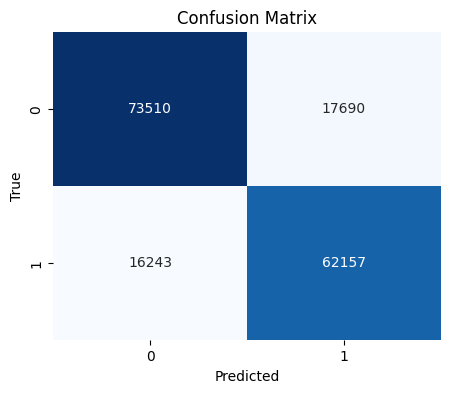

In [ ]:
y_true = result_df['y_true']
y_pred = result_df['y_pred']

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
full_mass_results = result_mass.merge(result_df[['tumor_id', 'y_pred', 'y_prob', 'fold_number', 'file_number']], on='tumor_id', how='left')

In [ ]:
full_mass_results['malignant'] = full_mass_results['pathology'].map({'MALIGNANT': 1, 'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0})

In [ ]:
full_mass_results

patient_id  breast_density left or right breast image view  \
0         P_00001               3                 LEFT         CC   
1         P_00001               3                 LEFT         CC   
2         P_00001               3                 LEFT         CC   
3         P_00001               3                 LEFT         CC   
4         P_00001               3                 LEFT         CC   
...           ...             ...                  ...        ...   
169595    P_01912               3                RIGHT        MLO   
169596    P_01912               3                RIGHT        MLO   
169597    P_01912               3                RIGHT        MLO   
169598    P_01912               3                RIGHT        MLO   
169599    P_01912               3                RIGHT        MLO   

       abnormality id abnormality type  assessment  pathology  subtlety  \
0                   1             mass           4  MALIGNANT         4   
1                   1             mass           4  MALIGNANT         4   
2                   1             mass           4  MALIGNANT         4   
3                   1             mass           4  MALIGNANT         4   
4                   1             mass           4  MALIGNANT         4   
...               ...              ...         ...        ...       ...   
169595              1             mass           5  MALIGNANT         4   
169596              1             mass           5  MALIGNANT         4   
169597              1             mass           5  MALIGNANT         4   
169598              1             mass           5  MALIGNANT         4   
169599              1             mass           5  MALIGNANT         4   

                                          image file path  ... CIRCUMSCRIBED  \
0       Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...  ...             0   
1       Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...  ...             0   
2       Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...  ...             0   
3       Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...  ...             0   
4       Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...  ...             0   
...                                                   ...  ...           ...   
169595  Mass-Test_P_01912_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...             0   
169596  Mass-Test_P_01912_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...             0   
169597  Mass-Test_P_01912_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...             0   
169598  Mass-Test_P_01912_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...             0   
169599  Mass-Test_P_01912_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...             0   

       ILL_DEFINED  MICROLOBULATED  OBSCURED  SPICULATED  malignant  y_pred  \
0                0               0         0           1          1       1   
1                0               0         0           1          1       1   
2                0               0         0           1          1       1   
3                0               0         0           1          1       1   
4                0               0         0           1          1       1   
...            ...             ...       ...         ...        ...     ...   
169595           0               0         0           1          1       1   
169596           0               0         0           1          1       1   
169597           0               0         0           1          1       1   
169598           0               0         0           1          1       1   
169599           0               0         0           1          1       1   

          y_prob  fold_number  file_number  
0       0.547186            4            1  
1       0.546038            8            2  
2       0.529768            6            3  
3       0.566225            3            4  
4       0.528517            4            5  
...          ...          ...          ...  
169595  0.549095            8           96  
169596 

In [ ]:
full_mass_results.to_csv('full_mass_results_withFold.csv', index=False)

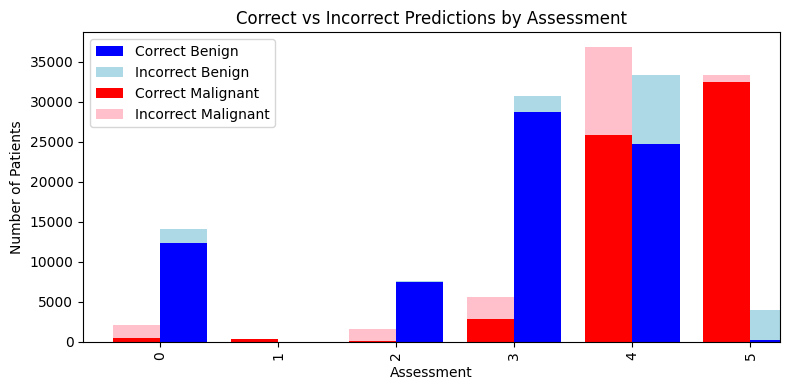

In [ ]:
# Calculate correct and incorrect predictions
correct_benign = full_mass_results[(full_mass_results['y_pred'] == 0) & (full_mass_results['pathology'] == 'BENIGN')]['assessment'].value_counts()
incorrect_benign = full_mass_results[(full_mass_results['y_pred'] == 0) & (full_mass_results['pathology'] == 'MALIGNANT')]['assessment'].value_counts()

correct_malignant = full_mass_results[(full_mass_results['y_pred'] == 1) & (full_mass_results['pathology'] == 'MALIGNANT')]['assessment'].value_counts()
incorrect_malignant = full_mass_results[(full_mass_results['y_pred'] == 1) & (full_mass_results['pathology'] == 'BENIGN')]['assessment'].value_counts()

# Combine the counts into a DataFrame for plotting
prediction_counts = pd.DataFrame({
    'Correct Benign': correct_benign,
    'Incorrect Benign': incorrect_benign,
    'Correct Malignant': correct_malignant,
    'Incorrect Malignant': incorrect_malignant
}).fillna(0)

fig, ax = plt.subplots(figsize=(8, 4))

prediction_counts[['Correct Benign', 'Incorrect Benign']].plot(kind='bar', ax=ax, color=['blue', 'lightblue'], stacked=True, position=0, width=0.4, align='center', label='Benign')
prediction_counts[['Correct Malignant', 'Incorrect Malignant']].plot(kind='bar', ax=ax, color=['red', 'pink'], stacked=True, position=1, width=0.4, align='center', label='Malignant')

ax.set_xlabel('Assessment')
ax.set_ylabel('Number of Patients')
ax.set_title('Correct vs Incorrect Predictions by Assessment')
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
counts_df = pd.DataFrame({
    'Correct Benign': correct_benign,
    'Incorrect Benign': incorrect_benign,
    'Correct Malignant': correct_malignant,
    'Incorrect Malignant': incorrect_malignant
}).fillna(0)


counts_df['Benign Accuracy'] = counts_df['Correct Benign'] / (counts_df['Correct Benign'] + counts_df['Incorrect Benign'])
counts_df['Malignant Accuracy'] = counts_df['Correct Malignant'] / (counts_df['Correct Malignant'] + counts_df['Incorrect Malignant'])
counts_df.fillna(0, inplace=True)

counts_df

Correct Benign  Incorrect Benign  Correct Malignant  \
assessment                                                        
0                  12387.0            1682.0                518   
1                      0.0               0.0                300   
2                   7510.0              31.0                 69   
3                  28748.0            1997.0               2903   
4                  24665.0            8716.0              25884   
5                    200.0            3817.0              32483   

            Incorrect Malignant  Benign Accuracy  Malignant Accuracy  
assessment                                                            
0                        1613.0         0.880446            0.243078  
1                           0.0         0.000000            1.000000  
2                        1490.0         0.995889            0.044259  
3                        2752.0         0.935046            0.513351  
4                       10935.0         0.738893            0.703007  
5                         900.0         0.049788            0.973040

**Understand the results:**

Assessment 0 : predicted benign - 88.04% of the time correct

Assessment 1 : predicted malignant - 100% of the time correct

Assessment 2 : predicted benign - 99.58% of the time correct

Assessment 3 : predicted benign - 93.50% of the time correct

Assessment 4 : predictions are correct with about 70 - 73.89% accuracy

Assessment 5 : predicted malignant - 97.30% of the time correct



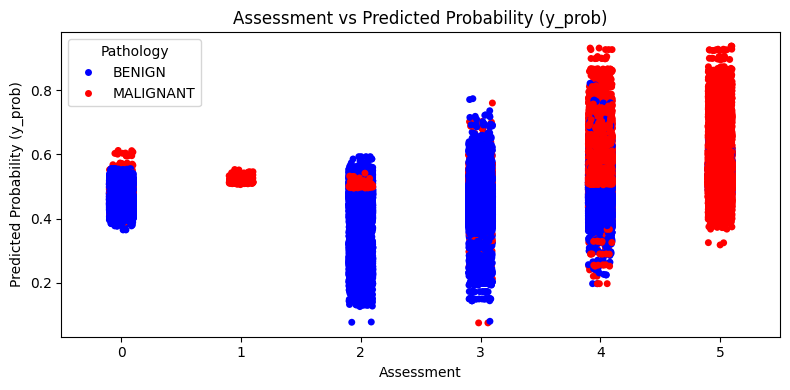

In [ ]:
plt.figure(figsize=(8, 4))

# Plot y_prob against assessment, with different colors for malignant and benign
sns.stripplot(data=full_mass_results, x='assessment', y='y_prob', jitter=True, hue='pathology', palette={'MALIGNANT': 'red', 'BENIGN': 'blue'})

plt.xlabel('Assessment')
plt.ylabel('Predicted Probability (y_prob)')
plt.title('Assessment vs Predicted Probability (y_prob)')
plt.legend(title='Pathology')

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Create a figure
fig = plt.figure(figsize=(10, 8))

# Add a 3D subplot
ax = fig.add_subplot(111, projection='3d')

# Assign x, y, and z axes
x = full_mass_results['assessment']
y = full_mass_results['y_prob']
z = full_mass_results['breast_density']  # Assuming you have a 'breast_density' column

# Set color based on pathology (MALIGNANT or BENIGN)
color_map = {'MALIGNANT': 'red', 'BENIGN': 'blue'}
colors = full_mass_results['pathology'].map(color_map)

# Plot the 3D scatter plot
scatter = ax.scatter(x, y, z, c=colors)

# Labeling axes
ax.set_xlabel('Assessment')
ax.set_ylabel('Predicted Probability (y_prob)')
ax.set_zlabel('Breast Density')

# Title
ax.set_title('3D Visualization of Assessment, y_prob, and Breast Density')

# Add a legend for the colors
red_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='MALIGNANT')
blue_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='BENIGN')
ax.legend(handles=[red_patch, blue_patch], title='Pathology')

# Show the plot
plt.show()


In [ ]:
# Calculate the average y_prob per assessment
avg_y_prob_per_assessment = full_mass_results.groupby('assessment')['y_prob'].mean()

print("Average y_prob per assessment:")
print(avg_y_prob_per_assessment)


Average y_prob per assessment:
assessment
0    0.467751
1    0.520581
2    0.377032
3    0.459711
4    0.501901
5    0.547515
Name: y_prob, dtype: float64


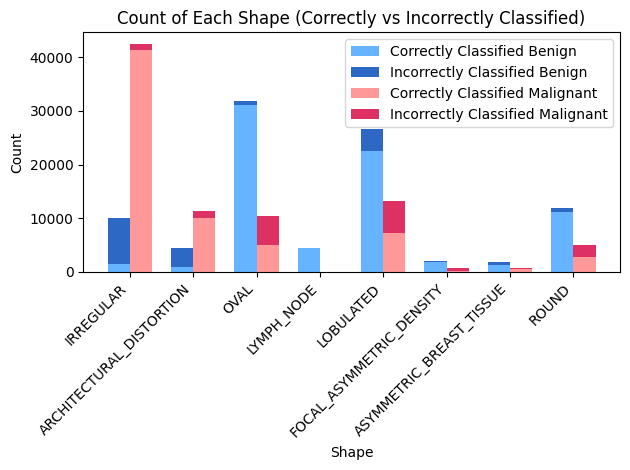

In [ ]:
shapes_of_interest = ['IRREGULAR', 'ARCHITECTURAL_DISTORTION', 'OVAL', 'LYMPH_NODE',
                      'LOBULATED', 'FOCAL_ASYMMETRIC_DENSITY', 'ASYMMETRIC_BREAST_TISSUE', 'ROUND']

# Filter data
malignant_mass_hit = full_mass_results[(full_mass_results['malignant'] == 1) & (full_mass_results['y_pred'] == 1)]
benign_mass_hit = full_mass_results[(full_mass_results['malignant'] == 0) & (full_mass_results['y_pred'] == 0)]
malignant_mass_miss = full_mass_results[(full_mass_results['malignant'] == 1) & (full_mass_results['y_pred'] == 0)]
benign_mass_miss = full_mass_results[(full_mass_results['malignant'] == 0) & (full_mass_results['y_pred'] == 1)]

# Aggregate counts for each shape
malignant_hit_sums = malignant_mass_hit[shapes_of_interest].sum()
benign_hit_sums = benign_mass_hit[shapes_of_interest].sum()
malignant_miss_sums = malignant_mass_miss[shapes_of_interest].sum()
benign_miss_sums = benign_mass_miss[shapes_of_interest].sum()

# Positions for bars
x = np.arange(len(shapes_of_interest))
width = 0.35

fig, ax = plt.subplots()

# Plot bars for benign tumors
rects1 = ax.bar(x - width/2, benign_hit_sums, width, label='Correctly Classified Benign', color='#66b3ff')
rects2 = ax.bar(x - width/2, benign_miss_sums, width, bottom=benign_hit_sums, label='Incorrectly Classified Benign', color='#2D68C4')

# Plot bars for malignant tumors
rects3 = ax.bar(x + width/2, malignant_hit_sums, width, label='Correctly Classified Malignant', color='#ff9999')
rects4 = ax.bar(x + width/2, malignant_miss_sums, width, bottom=malignant_hit_sums, label='Incorrectly Classified Malignant', color='#DE3163')

# Set labels and title
ax.set_xlabel('Shape')
ax.set_ylabel('Count')
ax.set_title('Count of Each Shape (Correctly vs Incorrectly Classified)')
ax.set_xticks(x)
ax.set_xticklabels(shapes_of_interest, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()


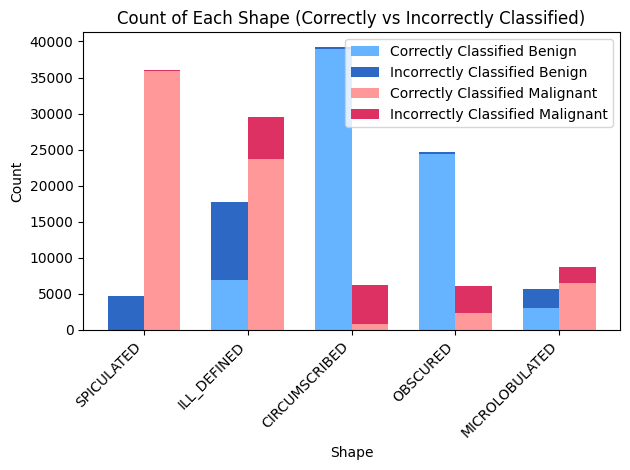

In [ ]:
margins_of_interest = ['SPICULATED', 'ILL_DEFINED', 'CIRCUMSCRIBED', 'OBSCURED', 'MICROLOBULATED']

# Filter data
malignant_mass_hit = full_mass_results[(full_mass_results['malignant'] == 1) & (full_mass_results['y_pred'] == 1)]
benign_mass_hit = full_mass_results[(full_mass_results['malignant'] == 0) & (full_mass_results['y_pred'] == 0)]
malignant_mass_miss = full_mass_results[(full_mass_results['malignant'] == 1) & (full_mass_results['y_pred'] == 0)]
benign_mass_miss = full_mass_results[(full_mass_results['malignant'] == 0) & (full_mass_results['y_pred'] == 1)]

# Aggregate counts for each shape
malignant_hit_sums = malignant_mass_hit[margins_of_interest].sum()
benign_hit_sums = benign_mass_hit[margins_of_interest].sum()
malignant_miss_sums = malignant_mass_miss[margins_of_interest].sum()
benign_miss_sums = benign_mass_miss[margins_of_interest].sum()

# Positions for bars
x = np.arange(len(margins_of_interest))
width = 0.35

fig, ax = plt.subplots()

# Plot bars for benign tumors
rects1 = ax.bar(x - width/2, benign_hit_sums, width, label='Correctly Classified Benign', color='#66b3ff')
rects2 = ax.bar(x - width/2, benign_miss_sums, width, bottom=benign_hit_sums, label='Incorrectly Classified Benign', color='#2D68C4')

# Plot bars for malignant tumors
rects3 = ax.bar(x + width/2, malignant_hit_sums, width, label='Correctly Classified Malignant', color='#ff9999')
rects4 = ax.bar(x + width/2, malignant_miss_sums, width, bottom=malignant_hit_sums, label='Incorrectly Classified Malignant', color='#DE3163')

# Set labels and title
ax.set_xlabel('Shape')
ax.set_ylabel('Count')
ax.set_title('Count of Each Shape (Correctly vs Incorrectly Classified)')
ax.set_xticks(x)
ax.set_xticklabels(margins_of_interest, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()


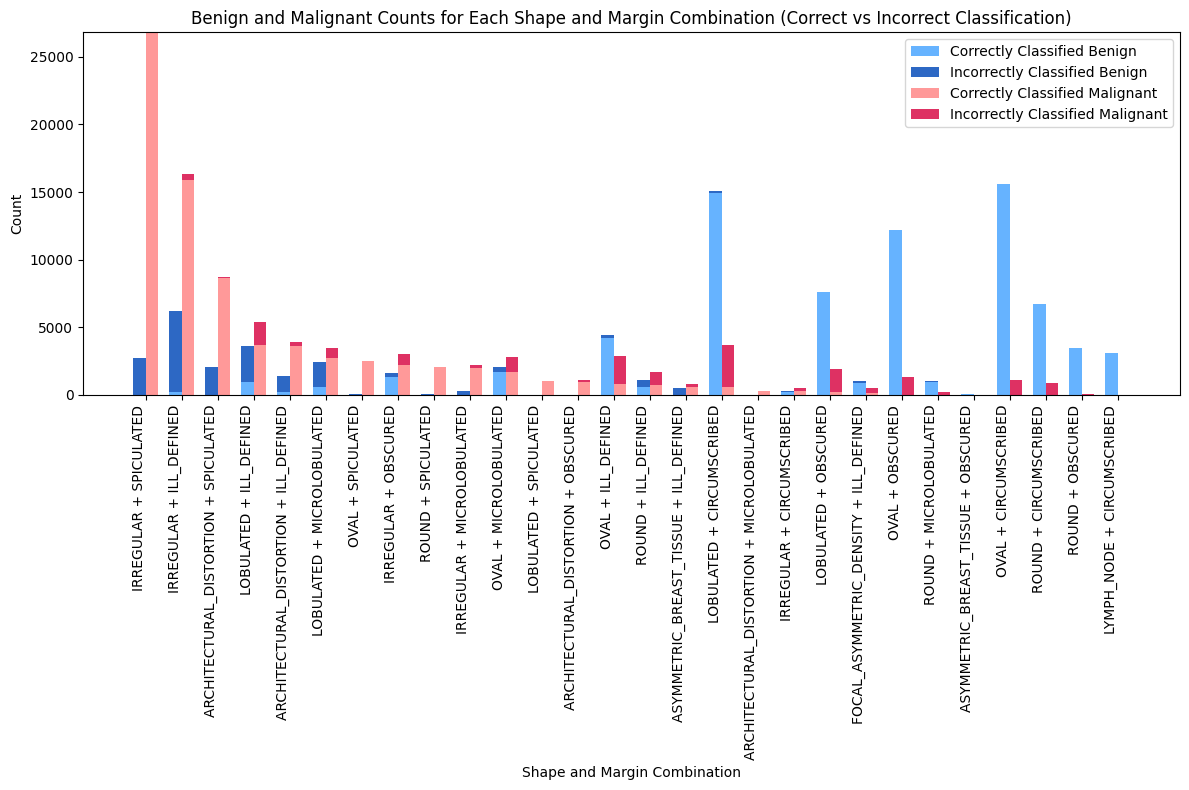

In [ ]:
shapes_of_interest = ['IRREGULAR', 'ARCHITECTURAL_DISTORTION', 'OVAL', 'LYMPH_NODE',
                      'LOBULATED', 'FOCAL_ASYMMETRIC_DENSITY', 'ASYMMETRIC_BREAST_TISSUE', 'ROUND']

margins_of_interest = ['SPICULATED', 'ILL_DEFINED', 'CIRCUMSCRIBED', 'OBSCURED', 'MICROLOBULATED']

combinations = []

# Loop through each shape and margin combination
for shape in shapes_of_interest:
    for margin in margins_of_interest:
        # Count the number of correct and incorrect benign and malignant cases for each combination
        malignant_correct = full_mass_results[(full_mass_results[shape] == 1) & (full_mass_results[margin] == 1) & (full_mass_results['malignant'] == 1) & (full_mass_results['y_pred'] == 1)].shape[0]
        benign_correct = full_mass_results[(full_mass_results[shape] == 1) & (full_mass_results[margin] == 1) & (full_mass_results['malignant'] == 0) & (full_mass_results['y_pred'] == 0)].shape[0]
        malignant_incorrect = full_mass_results[(full_mass_results[shape] == 1) & (full_mass_results[margin] == 1) & (full_mass_results['malignant'] == 1) & (full_mass_results['y_pred'] == 0)].shape[0]
        benign_incorrect = full_mass_results[(full_mass_results[shape] == 1) & (full_mass_results[margin] == 1) & (full_mass_results['malignant'] == 0) & (full_mass_results['y_pred'] == 1)].shape[0]

        # Append the result to the combinations list
        combinations.append({'shape': shape, 'margin': margin,
                             'malignant_correct': malignant_correct, 'benign_correct': benign_correct,
                             'malignant_incorrect': malignant_incorrect, 'benign_incorrect': benign_incorrect})

# Convert to DataFrame for easier manipulation
combinations_df = pd.DataFrame(combinations)

# Filter combinations that have more than 1 appearance (either malignant or benign)
combinations_df = combinations_df[
    (combinations_df['malignant_correct'] + combinations_df['malignant_incorrect'] +
     combinations_df['benign_correct'] + combinations_df['benign_incorrect']) > 1
]

# Sort the DataFrame by malignant correct count in descending order
combinations_df = combinations_df.sort_values(by='malignant_correct', ascending=False)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Convert x to list for calculations
x = list(range(len(combinations_df)))
width = 0.35

# Plot bars for benign tumors
rects1 = ax.bar([i - width/2 for i in x], combinations_df['benign_correct'], width, label='Correctly Classified Benign', color='#66b3ff')
rects2 = ax.bar([i - width/2 for i in x], combinations_df['benign_incorrect'], width, bottom=combinations_df['benign_correct'], label='Incorrectly Classified Benign', color='#2D68C4')

# Plot bars for malignant tumors
rects3 = ax.bar([i + width/2 for i in x], combinations_df['malignant_correct'], width, label='Correctly Classified Malignant', color='#ff9999')
rects4 = ax.bar([i + width/2 for i in x], combinations_df['malignant_incorrect'], width, bottom=combinations_df['malignant_correct'], label='Incorrectly Classified Malignant', color='#DE3163')

# Set labels and title
ax.set_xlabel('Shape and Margin Combination')
ax.set_ylabel('Count')
ax.set_title('Benign and Malignant Counts for Each Shape and Margin Combination (Correct vs Incorrect Classification)')
ax.set_xticks(x)
ax.set_xticklabels(combinations_df.apply(lambda row: f"{row['shape']} + {row['margin']}", axis=1), rotation=90, ha='right')
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
combinations_df['Accuracy'] = (combinations_df['malignant_correct'] + combinations_df['benign_correct']) / (combinations_df['malignant_correct'] + combinations_df['benign_correct']+ combinations_df['malignant_incorrect'] + combinations_df['benign_incorrect'])
combinations_df.sort_values(by='Accuracy', ascending=False)

shape          margin  malignant_correct  \
17                LYMPH_NODE   CIRCUMSCRIBED                  0   
33  ASYMMETRIC_BREAST_TISSUE        OBSCURED                  0   
9   ARCHITECTURAL_DISTORTION  MICROLOBULATED                300   
20                 LOBULATED      SPICULATED               1000   
38                     ROUND        OBSCURED                  0   
10                      OVAL      SPICULATED               2495   
35                     ROUND      SPICULATED               2100   
12                      OVAL   CIRCUMSCRIBED                  0   
0                  IRREGULAR      SPICULATED              26800   
13                      OVAL        OBSCURED                  3   
37                     ROUND   CIRCUMSCRIBED                  0   
8   ARCHITECTURAL_DISTORTION        OBSCURED                947   
23                 LOBULATED        OBSCURED                251   
22                 LOBULATED   CIRCUMSCRIBED                568   
4                  IRREGULAR  MICROLOBULATED               2025   
5   ARCHITECTURAL_DISTORTION      SPICULATED               8631   
39                     ROUND  MICROLOBULATED                  2   
3                  IRREGULAR        OBSCURED               2182   
26  FOCAL_ASYMMETRIC_DENSITY     ILL_DEFINED                172   
6   ARCHITECTURAL_DISTORTION     ILL_DEFINED               3650   
1                  IRREGULAR     ILL_DEFINED              15862   
14                      OVAL  MICROLOBULATED               1730   
11                      OVAL     ILL_DEFINED                828   
2                  IRREGULAR   CIRCUMSCRIBED                284   
24                 LOBULATED  MICROLOBULATED               2721   
21                 LOBULATED     ILL_DEFINED               3700   
36                     ROUND     ILL_DEFINED                713   
31  ASYMMETRIC_BREAST_TISSUE     ILL_DEFINED                569   

    benign_correct  malignant_incorrect  benign_incorrect  Accuracy  
17            3100                    0                 0  1.000000  
33             100                    0                 0  1.000000  
9                0                    0                 0  1.000000  
20               0                    0                 0  1.000000  
38            3500                  100                 0  0.972222  
10               0                    5               100  0.959615  
35               0                    0               100  0.954545  
12           15599                 1100                 1  0.934072  
0                0                    0              2700  0.908475  
13           12199                 1297                 1  0.903852  
37            6689                  900                11  0.880132  
8                0                  153                 0  0.860909  
23            7600                 1649                 0  0.826421  
22           14922                 3132               178  0.823936  
4                0                  175               300  0.810000  
5                5                   69              2095  0.799630  
39             943                  198                57  0.787500  
3             1338                  818               262  0.765217  
26             918                  328                82  0.726667  
6              191                  250              1209  0.724717  
1              214                  438              5986  0.714489  
14            1673                 1070               427  0.694490  
11            4180                 2072               220  0.686027  
2              196                  216               104  0.600000  
24             554                  779              1846  0.555085  
21             995                 1700              2605  0.521667  
36             586                  987               514  0.463929  
31              19                  231               481  0.452308

Summary of what the model troubles classifying:

The following shapes:
* Irregular
* Lobulated

The following margins:
* Almost all shapes

The following combinations:
* Irregular + Spiculated
* Irregular + Ill defined
* Lobulated + Ill defined
* Lobulated + Circumscribe



Since we understand that most of the data misclassified is due to shapes, we would like to cluster the data to understand what it looks like

In [ ]:
full_mass_results.columns

Index(['patient_id', 'breast_density', 'left or right breast', 'image view',
       'abnormality id', 'abnormality type', 'assessment', 'pathology',
       'subtlety', 'image file path', 'cropped image file path',
       'ROI mask file path', 'tumor_id', 'multiple_tumors',
       'ARCHITECTURAL_DISTORTION', 'ASYMMETRIC_BREAST_TISSUE',
       'FOCAL_ASYMMETRIC_DENSITY', 'IRREGULAR', 'LOBULATED', 'LYMPH_NODE',
       'OVAL', 'ROUND', 'CIRCUMSCRIBED', 'ILL_DEFINED', 'MICROLOBULATED',
       'OBSCURED', 'SPICULATED', 'malignant', 'y_pred', 'y_prob',
       'fold_number', 'file_number'],
      dtype='object')

In [ ]:
main_features_df = full_mass_results[['breast_density', 'multiple_tumors',
       'ARCHITECTURAL_DISTORTION', 'ASYMMETRIC_BREAST_TISSUE',
       'FOCAL_ASYMMETRIC_DENSITY', 'IRREGULAR', 'LOBULATED', 'LYMPH_NODE',
       'OVAL', 'ROUND', 'CIRCUMSCRIBED', 'ILL_DEFINED', 'MICROLOBULATED',
       'OBSCURED', 'SPICULATED', 'malignant', 'y_pred', 'tumor_id']]
main_features_df

breast_density  multiple_tumors  ARCHITECTURAL_DISTORTION  \
0                    3              0.0                         1   
1                    3              0.0                         1   
2                    3              0.0                         1   
3                    3              0.0                         1   
4                    3              0.0                         1   
...                ...              ...                       ...   
169595               3              0.0                         0   
169596               3              0.0                         0   
169597               3              0.0                         0   
169598               3              0.0                         0   
169599               3              0.0                         0   

        ASYMMETRIC_BREAST_TISSUE  FOCAL_ASYMMETRIC_DENSITY  IRREGULAR  \
0                              0                         0          1   
1                              0                         0          1   
2                              0                         0          1   
3                              0                         0          1   
4                              0                         0          1   
...                          ...                       ...        ...   
169595                         0                         0          1   
169596                         0                         0          1   
169597                         0                         0          1   
169598                         0                         0          1   
169599                         0                         0          1   

        LOBULATED  LYMPH_NODE  OVAL  ROUND  CIRCUMSCRIBED  ILL_DEFINED  \
0               0           0     0      0              0            0   
1               0           0     0      0              0            0   
2               0           0     0      0              0            0   
3               0           0     0      0              0            0   
4               0           0     0      0              0            0   
...           ...         ...   ...    ...            ...          ...   
169595          0           0     0      0              0            0   
169596          0           0     0      0              0            0   
169597          0           0     0      0              0            0   
169598          0           0     0      0              0            0   
169599          0           0     0      0              0            0   

        MICROLOBULATED  OBSCURED  SPICULATED  malignant  y_pred  tumor_id  
0                    0         0           1          1       1         1  
1                    0         0           1          1       1         1  
2                    0         0           1          1       1         1  
3                    0         0           1          1       1         1  
4                    0         0           1          1       1         1  
...                ...       ...         ...        ...     ...       ...  
169595               0         0           1          1       1      1696  
169596               0         0           1          1       1      1696  
169597               0         0           1          1       1      1696  
169598               0         0           1          1       1      1696  
169599               0         0           1          1       1      1696  

[169600 rows x 18 columns]

In [ ]:
columns_to_groupby = ['breast_density', 'multiple_tumors', 'ARCHITECTURAL_DISTORTION',
                      'ASYMMETRIC_BREAST_TISSUE', 'FOCAL_ASYMMETRIC_DENSITY', 'IRREGULAR',
                      'LOBULATED', 'LYMPH_NODE', 'OVAL', 'ROUND', 'CIRCUMSCRIBED',
                      'ILL_DEFINED', 'MICROLOBULATED', 'OBSCURED', 'SPICULATED',
                      'malignant', 'y_pred']

grouped_main_features_df = main_features_df.groupby(columns_to_groupby).agg(
    count=('tumor_id', 'size'),  # Count the number of rows in each group
    tumor_ids=('tumor_id', lambda x: list(set(x)))  # Aggregate all tumor_ids into a list
).reset_index()

grouped_main_features_df


breast_density  multiple_tumors  ARCHITECTURAL_DISTORTION  \
0                 1              0.0                         0   
1                 1              0.0                         0   
2                 1              0.0                         0   
3                 1              0.0                         0   
4                 1              0.0                         0   
..              ...              ...                       ...   
372               4              1.0                         0   
373               4              1.0                         0   
374               4              1.0                         0   
375               4              1.0                         0   
376               4              1.0                         0   

     ASYMMETRIC_BREAST_TISSUE  FOCAL_ASYMMETRIC_DENSITY  IRREGULAR  LOBULATED  \
0                           0                         0          0          0   
1                           0                         0          0          0   
2                           0                         0          0          0   
3                           0                         0          0          0   
4                           0                         0          0          0   
..                        ...                       ...        ...        ...   
372                         0                         0          0          0   
373                         0                         0          0          1   
374                         0                         0          0          1   
375                         0                         0          0          1   
376                         0                         0          1          0   

     LYMPH_NODE  OVAL  ROUND  CIRCUMSCRIBED  ILL_DEFINED  MICROLOBULATED  \
0             0     0      1              0            0               0   
1             0     0      1              0            0               0   
2             0     0      1              0            0               1   
3             0     0      1              0            0               1   
4             0     0      1              0            0               1   
..          ...   ...    ...            ...          ...             ...   
372           0     1      0              1            0               0   
373           0     0      0              0            0               0   
374           0     0      0              1            0               0   
375           0     0      0              1            0               0   
376           0     0      0              0            0               0   

     OBSCURED  SPICULATED  malignant  y_pred  count   tumor_ids  
0           0           1          1       1    200  [961, 988]  
1           1           0          0       0    200  [388, 389]  
2           0           0          0       0     51       [397]  
3           0           0          0       1     49       [397]  
4           0           0          1       0     98      [1281]  
..        ...         ...        ...     ...    ...         ...  
372         0           0          0       0    100       [441]  
373         1           0          0       0    100       [440]  
374         0           0          0       0     99       [438]  
375         0           0          0       1      1       [438]  
376         0           1          1       1    200  [468, 469]  

[377 rows x 19 columns]

In [ ]:
from collections import Counter

columns_to_groupby = ['breast_density', 'multiple_tumors', 'ARCHITECTURAL_DISTORTION',
                      'ASYMMETRIC_BREAST_TISSUE', 'FOCAL_ASYMMETRIC_DENSITY', 'IRREGULAR',
                      'LOBULATED', 'LYMPH_NODE', 'OVAL', 'ROUND', 'CIRCUMSCRIBED',
                      'ILL_DEFINED', 'MICROLOBULATED', 'OBSCURED', 'SPICULATED']

grouped_main_features_df = main_features_df.groupby(columns_to_groupby).agg(
    malignant_tumor_ids=('tumor_id', lambda x: list(set(x[main_features_df.loc[x.index, 'malignant'] == 1]))),  # tumor_ids where malignant == 1
    benign_tumor_ids=('tumor_id', lambda x: list(set(x[main_features_df.loc[x.index, 'malignant'] == 0]))),  # tumor_ids where malignant == 0
    correct_tumor_ids=('tumor_id', lambda x: dict(Counter(x[main_features_df.loc[x.index, 'malignant'] == main_features_df.loc[x.index, 'y_pred']]))),  # tumor_id: count for correctly classified
    incorrect_tumor_ids=('tumor_id', lambda x: dict(Counter(x[main_features_df.loc[x.index, 'malignant'] != main_features_df.loc[x.index, 'y_pred']])))  # tumor_id: count for incorrectly classified
).reset_index()

grouped_main_features_df['feature_combination'] = grouped_main_features_df[columns_to_groupby].astype(str).agg('-'.join, axis=1)


grouped_main_features_df


breast_density  multiple_tumors  ARCHITECTURAL_DISTORTION  \
0                 1              0.0                         0   
1                 1              0.0                         0   
2                 1              0.0                         0   
3                 1              0.0                         0   
4                 1              0.0                         0   
..              ...              ...                       ...   
209               4              1.0                         0   
210               4              1.0                         0   
211               4              1.0                         0   
212               4              1.0                         0   
213               4              1.0                         0   

     ASYMMETRIC_BREAST_TISSUE  FOCAL_ASYMMETRIC_DENSITY  IRREGULAR  LOBULATED  \
0                           0                         0          0          0   
1                           0                         0          0          0   
2                           0                         0          0          0   
3                           0                         0          0          0   
4                           0                         0          0          0   
..                        ...                       ...        ...        ...   
209                         0                         0          0          0   
210                         0                         0          0          0   
211                         0                         0          0          1   
212                         0                         0          0          1   
213                         0                         0          1          0   

     LYMPH_NODE  OVAL  ROUND  CIRCUMSCRIBED  ILL_DEFINED  MICROLOBULATED  \
0             0     0      1              0            0               0   
1             0     0      1              0            0               0   
2             0     0      1              0            0               1   
3             0     0      1              0            1               0   
4             0     0      1              1            0               0   
..          ...   ...    ...            ...          ...             ...   
209           0     1      0              0            0               0   
210           0     1      0              1            0               0   
211           0     0      0              0            0               0   
212           0     0      0              1            0               0   
213           0     0      0              0            0               0   

     OBSCURED  SPICULATED malignant_tumor_ids    benign_tumor_ids  \
0           0           1          [961, 988]                  []   
1           1           0                  []          [388, 389]   
2           0           0              [1281]               [397]   
3           0           0        [1276, 1495]                  []   
4           0           0                  []  [1185, 1548, 1670]   
..        ...         ...                 ...                 ...   
209         1           0                  []         [1600, 439]   
210         0           0                  []               [441]   
211         1           0                  []               [440]   
212         0           0                  []               [438]   
213         0           1          [468, 469]                  []   

                     correct_tumor_ids   incorrect_tumor_ids  \
0                 {961: 100, 988: 100}                    {}   
1                 {388: 100, 389: 100}                    {}   
2                   {397: 51, 1281: 2}   {397: 49, 1281: 98}   
3                 {1276: 56, 1495: 62}  {1276: 44, 1495: 38}   
4    {1185: 100, 1548: 100, 1670: 100}                    {}   
..                                 ...                   ...   
209              {439: 100, 1600: 100}           

<ipython-input-78-9b87ce325405>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['feature_combination'] = filtered_df[columns_to_groupby].astype(str).agg('-'.join, axis=1)


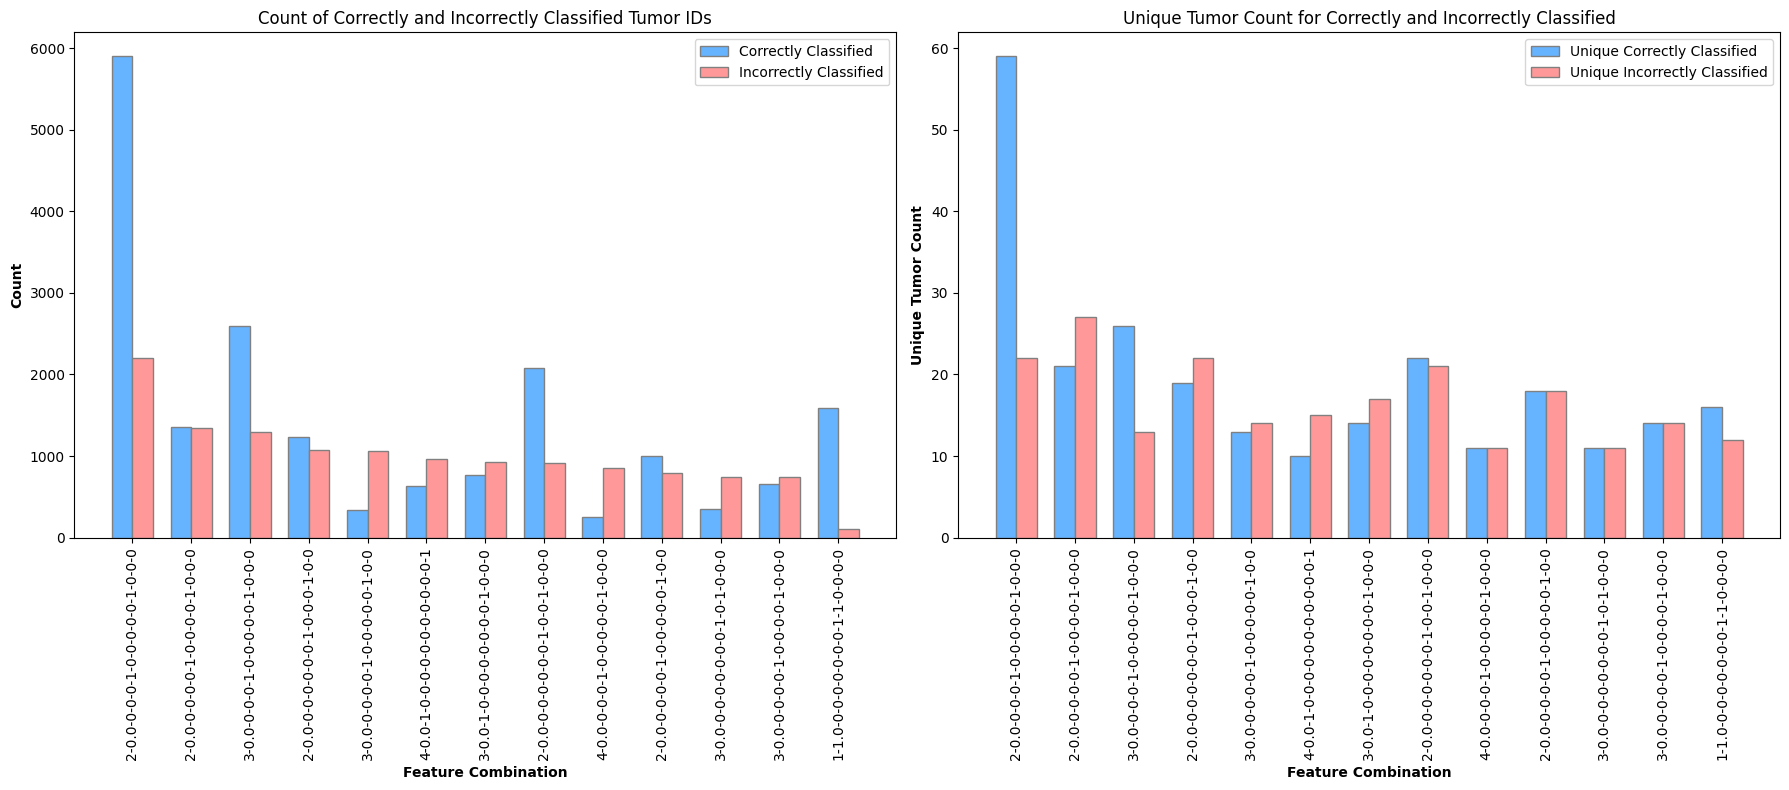

In [ ]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# Compute the sum of counts for incorrectly classified tumor_ids
grouped_main_features_df['incorrect_count_sum'] = grouped_main_features_df['incorrect_tumor_ids'].apply(lambda x: sum(Counter(x).values()))

# Compute the sum of counts for correctly classified tumor_ids
grouped_main_features_df['correct_count_sum'] = grouped_main_features_df['correct_tumor_ids'].apply(lambda x: sum(Counter(x).values()))

# Compute the number of unique incorrectly classified tumor_ids
grouped_main_features_df['unique_incorrect_count'] = grouped_main_features_df['incorrect_tumor_ids'].apply(lambda x: len(Counter(x)))

# Compute the number of unique correctly classified tumor_ids
grouped_main_features_df['unique_correct_count'] = grouped_main_features_df['correct_tumor_ids'].apply(lambda x: len(Counter(x)))

# Filter the DataFrame to include only rows where the sum of incorrect counts is greater than 200
filtered_df = grouped_main_features_df[grouped_main_features_df['unique_incorrect_count'] > 10]

# Create a new column that combines all the groupby columns into a single string for better visualization
filtered_df['feature_combination'] = filtered_df[columns_to_groupby].astype(str).agg('-'.join, axis=1)
filtered_df = filtered_df.sort_values(by='incorrect_count_sum', ascending=False)


# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# Bar width
bar_width = 0.35

# Positions of bars on x-axis
r1 = range(len(filtered_df))
r2 = [x + bar_width for x in r1]

# Plot bars for correctly classified and incorrectly classified tumor IDs
axs[0].bar(r1, filtered_df['correct_count_sum'], color='#66b3ff', width=bar_width, edgecolor='grey', label='Correctly Classified')
axs[0].bar(r2, filtered_df['incorrect_count_sum'], color='#ff9999', width=bar_width, edgecolor='grey', label='Incorrectly Classified')
axs[0].set_xlabel('Feature Combination', fontweight='bold')
axs[0].set_ylabel('Count', fontweight='bold')
axs[0].set_title('Count of Correctly and Incorrectly Classified Tumor IDs')
axs[0].set_xticks([r + bar_width / 2 for r in r1])
axs[0].set_xticklabels(filtered_df['feature_combination'], rotation=90)
axs[0].legend()

# Plot bars for the number of unique correctly classified and incorrectly classified tumors
axs[1].bar(r1, filtered_df['unique_correct_count'], color='#66b3ff', width=bar_width, edgecolor='grey', label='Unique Correctly Classified')
axs[1].bar(r2, filtered_df['unique_incorrect_count'], color='#ff9999', width=bar_width, edgecolor='grey', label='Unique Incorrectly Classified')
axs[1].set_xlabel('Feature Combination', fontweight='bold')
axs[1].set_ylabel('Unique Tumor Count', fontweight='bold')
axs[1].set_title('Unique Tumor Count for Correctly and Incorrectly Classified')
axs[1].set_xticks([r + bar_width / 2 for r in r1])
axs[1].set_xticklabels(filtered_df['feature_combination'], rotation=90)
axs[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
filtered_df[['feature_combination', 'correct_count_sum', 'incorrect_count_sum', 'unique_correct_count', 'unique_incorrect_count']]

feature_combination  correct_count_sum  incorrect_count_sum  \
81   2-0.0-0-0-0-1-0-0-0-0-0-1-0-0-0               5900                 2200   
66   2-0.0-0-0-0-0-1-0-0-0-0-1-0-0-0               1358                 1342   
150  3-0.0-0-0-0-1-0-0-0-0-0-1-0-0-0               2600                 1300   
54   2-0.0-0-0-0-0-0-0-1-0-0-0-1-0-0               1232                 1068   
140  3-0.0-0-0-0-0-1-0-0-0-0-0-1-0-0                341                 1059   
203  4-0.0-1-0-0-0-0-0-0-0-0-0-0-0-1                636                  964   
162  3-0.0-1-0-0-0-0-0-0-0-0-1-0-0-0                773                  927   
55   2-0.0-0-0-0-0-0-0-1-0-0-1-0-0-0               2082                  918   
197  4-0.0-0-0-0-1-0-0-0-0-0-1-0-0-0                248                  852   
65   2-0.0-0-0-0-0-1-0-0-0-0-0-1-0-0               1004                  796   
127  3-0.0-0-0-0-0-0-0-0-1-0-1-0-0-0                351                  749   
141  3-0.0-0-0-0-0-1-0-0-0-0-1-0-0-0                658                  742   
36   1-1.0-0-0-0-0-0-0-0-1-1-0-0-0-0               1589                  111   

     unique_correct_count  unique_incorrect_count  
81                     59                      22  
66                     21                      27  
150                    26                      13  
54                     19                      22  
140                    13                      14  
203                    10                      15  
162                    14                      17  
55                     22                      21  
197                    11                      11  
65                     18                      18  
127                    11                      11  
141                    14                      14  
36                     16                      12

In [ ]:
incorrect_features = grouped_main_features_df[
    (grouped_main_features_df['unique_incorrect_count'] != 0) &
    (grouped_main_features_df['incorrect_count_sum'] > 50)]
incorrect_features

breast_density  multiple_tumors  ARCHITECTURAL_DISTORTION  \
2                 1              0.0                         0   
3                 1              0.0                         0   
6                 1              0.0                         0   
7                 1              0.0                         0   
8                 1              0.0                         0   
..              ...              ...                       ...   
202               4              0.0                         1   
203               4              0.0                         1   
205               4              0.0                         1   
206               4              0.0                         1   
208               4              0.0                         1   

     ASYMMETRIC_BREAST_TISSUE  FOCAL_ASYMMETRIC_DENSITY  IRREGULAR  LOBULATED  \
2                           0                         0          0          0   
3                           0                         0          0          0   
6                           0                         0          0          0   
7                           0                         0          0          0   
8                           0                         0          0          0   
..                        ...                       ...        ...        ...   
202                         0                         0          0          0   
203                         0                         0          0          0   
205                         0                         0          0          1   
206                         0                         0          1          0   
208                         0                         0          1          0   

     LYMPH_NODE  OVAL  ROUND  ...  SPICULATED  \
2             0     0      1  ...           0   
3             0     0      1  ...           0   
6             0     1      0  ...           0   
7             0     1      0  ...           0   
8             0     1      0  ...           0   
..          ...   ...    ...  ...         ...   
202           0     0      0  ...           0   
203           0     0      0  ...           1   
205           0     0      0  ...           0   
206           0     0      0  ...           1   
208           0     0      0  ...           0   

                         malignant_tumor_ids  \
2                                     [1281]   
3                               [1276, 1495]   
6                                   [43, 44]   
7           [1282, 268, 1103, 119, 120, 669]   
8                         [1250, 1251, 1231]   
..                                       ...   
202                                   [1259]   
203  [1289, 813, 398, 1553, 1492, 1493, 442]   
205                                    [754]   
206                                       []   
208                                    [131]   

                                      benign_tumor_ids  \
2                                                [397]   
3                                                   []   
6     [417, 418, 77, 78, 685, 686, 474, 475, 157, 158]   
7                                               [1119]   
8                                          [860, 1054]   
..                                                 ...   
202                                              [593]   
203  [992, 811, 812, 1681, 1682, 1395, 1396, 1619, ...   
205                                                 []   
206                                             [1687]   
208                                                 []   

                                     correct_tumor_ids  \
2                                   {397: 51, 1281: 2}   
3                                 {1276: 56, 1495: 62}   
6    {77: 100, 78: 100, 157: 100, 158: 100, 417: 10...   
7    {119: 100, 120: 100, 268: 100, 669: 100, 1103:...   
8                       {1231: 96, 1250: 70, 1251: 69}   
..                          

In [ ]:
# Compute sizes of 'malignant_tumor_ids' and 'benign_tumor_ids'
incorrect_features['malignant_size'] = incorrect_features['malignant_tumor_ids'].apply(len)
incorrect_features['benign_size'] = incorrect_features['benign_tumor_ids'].apply(len)

# Further filter rows where either 'malignant_size' or 'benign_size' is 1
filtered_incorrect_features = incorrect_features[
    (incorrect_features['malignant_size'] == 1) | (incorrect_features['benign_size'] == 1)
]


# Print or use the filtered DataFrame
filtered_incorrect_features.drop(['malignant_size',	'benign_size'], axis=1)

<ipython-input-81-f75d9dc635a7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incorrect_features['malignant_size'] = incorrect_features['malignant_tumor_ids'].apply(len)
<ipython-input-81-f75d9dc635a7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incorrect_features['benign_size'] = incorrect_features['benign_tumor_ids'].apply(len)


breast_density  multiple_tumors  ARCHITECTURAL_DISTORTION  \
2                 1              0.0                         0   
7                 1              0.0                         0   
21                1              0.0                         0   
23                1              0.0                         0   
26                1              0.0                         0   
27                1              0.0                         0   
31                1              0.0                         1   
32                1              0.0                         1   
36                1              1.0                         0   
47                2              0.0                         0   
48                2              0.0                         0   
49                2              0.0                         0   
52                2              0.0                         0   
56                2              0.0                         0   
57                2              0.0                         0   
72                2              0.0                         0   
83                2              0.0                         0   
85                2              0.0                         0   
93                2              0.0                         0   
114               2              1.0                         0   
128               3              0.0                         0   
134               3              0.0                         0   
135               3              0.0                         0   
142               3              0.0                         0   
146               3              0.0                         0   
148               3              0.0                         0   
152               3              0.0                         0   
153               3              0.0                         0   
159               3              0.0                         0   
160               3              0.0                         1   
163               3              0.0                         1   
180               4              0.0                         0   
185               4              0.0                         0   
190               4              0.0                         0   
191               4              0.0                         0   
196               4              0.0                         0   
202               4              0.0                         1   
205               4              0.0                         1   
206               4              0.0                         1   
208               4              0.0                         1   

     ASYMMETRIC_BREAST_TISSUE  FOCAL_ASYMMETRIC_DENSITY  IRREGULAR  LOBULATED  \
2                           0                         0          0          0   
7                           0                         0          0          0   
21                          0                         0          1          0   
23                          0                         0          1          0   
26                          0                         0          1          1   
27                          0                         0          1          1   
31                          0                         0          0          0   
32                          0                         0          0          0   
36                          0                         0          0          0   
47                          0                         0          0          0   
48                          0                         0          0          0   
49                          0                         0          0          0   
52                          0                         0          0          0   
56                          0                         0          0          0   
57                          0                         0          0          0   
72

In [ ]:
# Print all rows where there's one incorrect tumor_id classified
incorrect_features[incorrect_features['unique_incorrect_count'] == 1]

breast_density  multiple_tumors  ARCHITECTURAL_DISTORTION  \
7                 1              0.0                         0   
21                1              0.0                         0   
23                1              0.0                         0   
26                1              0.0                         0   
27                1              0.0                         0   
32                1              0.0                         1   
47                2              0.0                         0   
48                2              0.0                         0   
52                2              0.0                         0   
56                2              0.0                         0   
57                2              0.0                         0   
72                2              0.0                         0   
83                2              0.0                         0   
85                2              0.0                         0   
93                2              0.0                         0   
114               2              1.0                         0   
128               3              0.0                         0   
134               3              0.0                         0   
135               3              0.0                         0   
142               3              0.0                         0   
146               3              0.0                         0   
148               3              0.0                         0   
153               3              0.0                         0   
163               3              0.0                         1   
185               4              0.0                         0   
190               4              0.0                         0   
196               4              0.0                         0   
202               4              0.0                         1   
205               4              0.0                         1   
206               4              0.0                         1   
208               4              0.0                         1   

     ASYMMETRIC_BREAST_TISSUE  FOCAL_ASYMMETRIC_DENSITY  IRREGULAR  LOBULATED  \
7                           0                         0          0          0   
21                          0                         0          1          0   
23                          0                         0          1          0   
26                          0                         0          1          1   
27                          0                         0          1          1   
32                          0                         0          0          0   
47                          0                         0          0          0   
48                          0                         0          0          0   
52                          0                         0          0          0   
56                          0                         0          0          0   
57                          0                         0          0          0   
72                          0                         0          0          1   
83                          0                         0          1          0   
85                          0                         0          1          0   
93                          1                         0          1          0   
114                         0                         0          0          1   
128                         0                         0          0          0   
134                         0                         0          0          0   
135                         0                         0          0          0   
142                         0                         0          0          1   
146                         0                         0          0          1   
148                         0                         0          1          0   
153                         0

The table above groups the tumors according to the shapes, breast density and number of tumors per patient. Added 2 columns to see which of those tumors are benign and which are malignant. We've also added 2 columns showing how many times each of this found tumors are classified correct and incorrectly.

# Rerunning Adaboost with the assessment column

In [ ]:
mass_one_hot

patient_id abnormality id  tumor_id  multiple_tumors  \
0       P_00001              1         1              0.0   
1       P_00001              1         2              0.0   
2       P_00004              1         3              0.0   
3       P_00004              1         4              0.0   
4       P_00004              1         5              0.0   
...         ...            ...       ...              ...   
1691    P_01825              1      1692              0.0   
1692    P_01833              1      1693              0.0   
1693    P_01865              1      1694              0.0   
1694    P_01912              1      1695              0.0   
1695    P_01912              1      1696              0.0   

      ARCHITECTURAL_DISTORTION  ASYMMETRIC_BREAST_TISSUE  \
0                            1                         0   
1                            1                         0   
2                            1                         0   
3                            1                         0   
4                            0                         0   
...                        ...                       ...   
1691                         0                         0   
1692                         0                         0   
1693                         0                         0   
1694                         0                         0   
1695                         0                         0   

      FOCAL_ASYMMETRIC_DENSITY  IRREGULAR  LOBULATED  LYMPH_NODE  ...  \
0                            0          1          0           0  ...   
1                            0          1          0           0  ...   
2                            0          0          0           0  ...   
3                            0          0          0           0  ...   
4                            0          0          0           0  ...   
...                        ...        ...        ...         ...  ...   
1691                         0          0          1           0  ...   
1692                         0          1          0           0  ...   
1693                         0          1          0           0  ...   
1694                         0          1          0           0  ...   
1695                         0          1          0           0  ...   

      SPICULATED  malignant  breast_density_1  breast_density_2  \
0              1          1                 0                 0   
1              1          1                 0                 0   
2              0          0                 0                 0   
3              0          0                 0                 0   
4              0          0                 0                 0   
...          ...        ...               ...               ...   
1691           0          0                 0                 1   
1692           0          1                 0                 1   
1693           0          1                 0                 1   
1694           1          1                 0                 0   
1695           1          1                 0                 0   

      breast_density_3  breast_density_4  left or right breast_LEFT  \
0                    1                 0                          1   
1                    1                 0                          1   
2                    1                 0                          1   
3                    1                 0                          1   
4                    1                 0                          0   
...                ...               ...                        ...   
1691                 0                 0                          0   
1692                 0                 0                          0   
1693                 0                 0                          1   
1694                 1                 0                          0   
1695                 1                 0                          0   

      left or ri

In [ ]:
mass_one_hot_assessment = pd.merge(mass_one_hot, result_mass[['tumor_id', 'assessment']], on='tumor_id', how='left')

In [ ]:
one_hot_assessment = pd.get_dummies(mass_one_hot_assessment['assessment'], prefix='assessment').astype(int)
mass_one_hot_assessment = mass_one_hot_assessment.drop(columns=['assessment']).join(one_hot_assessment)
mass_one_hot_assessment

patient_id abnormality id  tumor_id  multiple_tumors  \
0       P_00001              1         1              0.0   
1       P_00001              1         2              0.0   
2       P_00004              1         3              0.0   
3       P_00004              1         4              0.0   
4       P_00004              1         5              0.0   
...         ...            ...       ...              ...   
1691    P_01825              1      1692              0.0   
1692    P_01833              1      1693              0.0   
1693    P_01865              1      1694              0.0   
1694    P_01912              1      1695              0.0   
1695    P_01912              1      1696              0.0   

      ARCHITECTURAL_DISTORTION  ASYMMETRIC_BREAST_TISSUE  \
0                            1                         0   
1                            1                         0   
2                            1                         0   
3                            1                         0   
4                            0                         0   
...                        ...                       ...   
1691                         0                         0   
1692                         0                         0   
1693                         0                         0   
1694                         0                         0   
1695                         0                         0   

      FOCAL_ASYMMETRIC_DENSITY  IRREGULAR  LOBULATED  LYMPH_NODE  ...  \
0                            0          1          0           0  ...   
1                            0          1          0           0  ...   
2                            0          0          0           0  ...   
3                            0          0          0           0  ...   
4                            0          0          0           0  ...   
...                        ...        ...        ...         ...  ...   
1691                         0          0          1           0  ...   
1692                         0          1          0           0  ...   
1693                         0          1          0           0  ...   
1694                         0          1          0           0  ...   
1695                         0          1          0           0  ...   

      left or right breast_LEFT  left or right breast_RIGHT  image view_CC  \
0                             1                           0              1   
1                             1                           0              0   
2                             1                           0              1   
3                             1                           0              0   
4                             0                           1              0   
...                         ...                         ...            ...   
1691                          0                           1              0   
1692                          0                           1              0   
1693                          1                           0              0   
1694                          0                           1              1   
1695                          0                           1              0   

      image view_MLO  assessment_0  assessment_1  assessment_2  assessment_3  \
0                  0             0             0             0             0   
1                  1             0             0             0             0   
2                  0             0             0             0             0   
3                  1             0             0             0             0   
4                  1             0             0             0             0   
...              ...           ...           ...           ...           ...   
1691               1             0             0             0             1   
1692               1             0             0             0             0   
1693             

In [ ]:
num_runs = 100
n_splits = 10

# Define the parameter grid for AdaBoost
base_estimators = [
    DecisionTreeClassifier(max_depth=2)
    ]

param_grid_adaboost = {
    'n_estimators': [50, 100, 150, 200],  # Number of weak learners
    'learning_rate': [0.01, 0.05, 0.1],  # Learning rate
    'base_estimator': base_estimators
}

models = {
    "Ada Boost Classifier": AdaBoostClassifier()
}


# Rest of your code remains the same
for run in range(62, num_runs):
    print("Run: ", run)
    # Shuffle and reset the index of the original DataFrame
    mass_one_hot_assessment_shuffled = mass_one_hot_assessment.sample(frac=1, random_state=42*run).reset_index(drop=True)

    # Features and target
    X = mass_one_hot_assessment_shuffled.drop(['malignant', 'patient_id', 'tumor_id', 'abnormality id'], axis=1)
    y = mass_one_hot_assessment_shuffled['malignant']
    groups = mass_one_hot_assessment_shuffled['patient_id']
    abnormality_ids = mass_one_hot_assessment_shuffled['abnormality id']
    tumor_id = mass_one_hot_assessment_shuffled['tumor_id']

    # Replace whitespaces in feature names with underscores
    X.columns = [col.replace(" ", "_") for col in X.columns]

    all_predictions = []

    # Get unique patient IDs
    unique_patient_ids = groups.unique()
    np.random.seed(42*run)  # Set seed for reproducibility

    # Shuffle the patient IDs
    np.random.shuffle(unique_patient_ids)

    # Split the patient IDs into folds
    fold_size = len(unique_patient_ids) // n_splits
    predefined_splits = []

    for fold in range(n_splits):
        test_ids = unique_patient_ids[fold * fold_size: (fold + 1) * fold_size]
        train_ids = np.setdiff1d(unique_patient_ids, test_ids)
        predefined_splits.append((train_ids, test_ids))

    # Handle any patient IDs not included in the folds
    all_test_ids = np.concatenate([test_ids for _, test_ids in predefined_splits])
    missing_ids = np.setdiff1d(unique_patient_ids, all_test_ids)
    print(missing_ids)
    if len(missing_ids) > 0:
        for missing_id in missing_ids:
            random_fold = np.random.choice(n_splits)
            train_ids, test_ids = predefined_splits[random_fold]
            test_ids = np.append(test_ids, missing_id)
            predefined_splits[random_fold] = (train_ids, test_ids)

    for model_name, model in models.items():
        original_model = copy.deepcopy(model)  # Run folds on original model
        fold_count = 1
        all_model_predictions = []

        for fold_idx, (train_ids, test_ids) in enumerate(predefined_splits):
            model = copy.deepcopy(original_model)
            train_idx = groups.isin(train_ids)
            test_idx = groups.isin(test_ids)

            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            patient_ids = groups[test_idx]
            abnormality_test_ids = abnormality_ids[test_idx]
            tumor_id_test = tumor_id[test_idx]

            # Apply GridSearchCV only to the AdaBoost model
            if model_name == "Ada Boost Classifier":
                grid_search = GridSearchCV(model, param_grid_adaboost, cv=9, n_jobs=-1)
                grid_search.fit(X_train, y_train)
                model = grid_search.best_estimator_
                print(f"Fold {fold_count} - Best Parameters: {grid_search.best_params_}")
            else:
                model.fit(X_train, y_train)

            y_pred = model.predict(X_test)

            if hasattr(model, "predict_proba"):
                y_prob = model.predict_proba(X_test)[:, 1]
                for pid, ab_id, y_t, y_p, y_pr, t_id in zip(patient_ids, abnormality_test_ids, y_test, y_pred, y_prob, tumor_id_test):
                    all_model_predictions.append((pid, ab_id, y_t, y_p, y_pr, fold_count, t_id))
            else:
                for pid, ab_id, y_t, y_p, t_id in zip(patient_ids, abnormality_test_ids, y_test, y_pred, tumor_id_test):
                    all_model_predictions.append((pid, ab_id, y_t, y_p, None, fold_count, t_id))

            fold_count += 1

        predictions_df = pd.DataFrame(all_model_predictions, columns=['patient_id', 'abnormality id', 'y_true', 'y_pred', 'y_prob', 'fold_number', 'tumor_id'])

        # Include only the specified columns
        predictions_df = predictions_df[['patient_id', 'abnormality id', 'y_true', 'y_pred', 'y_prob', 'fold_number', 'tumor_id']]
        print(predictions_df.head())
        predictions_df.to_csv(f'/content/drive/My Drive/DDSM data/DDSM_compareModels_Mass/AdaBoost_withAssessment/HyperParametersTuningAssessment_{model_name}_{run + 1}.csv', index=False)


Run:  62
['P_01534' 'P_01795']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00174               1       1       1  0.618405            1       128
1    P_00634               1       0       0  0.423881            1       440
2    P_00440               1       1       1  0.512928            1       319
3    P_01821               1       0       1  0.517936            1      1265
4    P_01876               1       0       0  0.490433            1      1293
Run:  63
['P_00358' 'P_00766']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00901               1       1       1  0.585217            1       628
1    P_00415               1       1       0  0.433122            1       283
2    P_01237               1       0       0  0.376476            1       865
3    P_00837               1       0       0  0.428414            1      1501
4    P_01887               1       0       0  0.432424            1      1302
Run:  64
['P_00119' 'P_01294']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01739               1       0       0  0.433483            1      1214
1    P_00229               1       0       0  0.351037            1       162
2    P_01248               1       1       1  0.780148            1       873
3    P_01889               1       0       0  0.444418            1      1304
4    P_00670               1       0       0  0.463315            1       461
Run:  65
['P_01666' 'P_01716']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01652               1       1       0  0.489016            1      1152
1    P_01363               1       0       0  0.456805            1       953
2    P_01617               1       1       1  0.657042            1      1646
3    P_00076               1       0       0  0.455211            1        56
4    P_00137               1       0       0  0.456336            1       112
Run:  66
['P_00902' 'P_01849']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00265               1       1       1  0.634400            1       186
1    P_00328               1       0       0  0.036549            1       219
2    P_00587               1       0       1  0.501931            1      1452
3    P_00206               1       0       0  0.442327            1       139
4    P_01677               1       0       0  0.431160            1      1659
Run:  67
['P_00202' 'P_01299']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00598               1       1       1  0.633444            1      1456
1    P_01595               1       0       0  0.465584            1      1639
2    P_01084               1       1       1  0.565961            1       748
3    P_01849               1       0       0  0.034659            1      1284
4    P_01213               1       1       1  0.500632            1      1570
Run:  68
['P_00896' 'P_00966']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00512               1       0       0  0.493637            1       359
1    P_00648               1       1       0  0.490113            1       448
2    P_01265               1       0       0  0.439535            1       885
3    P_00641               1       1       1  0.598379            1      1469
4    P_01744               1       1       0  0.463209            1      1216
Run:  69
['P_00401' 'P_01768']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00703               1       0       0  0.496020            1       485
1    P_00841               1       0       0  0.441477            1       589
2    P_00303               1       0       0  0.442176            1       203
3    P_00990               1       1       1  0.576490            1       687
4    P_01332               1       0       0  0.055508            1       934
Run:  70
['P_00782' 'P_01494']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00187               1       0       0  0.469811            1       132
1    P_00730               1       1       1  0.503712            1       512
2    P_00510               4       0       0  0.053777            1      1439
3    P_01251               1       0       0  0.487726            1      1573
4    P_00894               1       0       0  0.454876            1       624
Run:  71
['P_00212' 'P_00776']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00970               1       0       0  0.063802            1       674
1    P_00465               1       1       1  0.699722            1       336
2    P_00436               1       0       0  0.437879            1       313
3    P_01268               1       0       0  0.472289            1       888
4    P_00710               1       0       0  0.483029            1       493
Run:  72
['P_00773' 'P_00881']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01297               1       0       0  0.389616            1       913
1    P_01687               1       0       0  0.437980            1      1181
2    P_00702               1       1       0  0.499372            1       482
3    P_01694               1       1       1  0.505508            1      1183
4    P_00644               1       1       0  0.497520            1       446
Run:  73
['P_00079' 'P_00239']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01356               1       1       1  0.632865            1       947
1    P_01735               1       1       0  0.450375            1      1209
2    P_01076               1       1       1  0.591443            1       740
3    P_01031               1       1       1  0.613883            1       704
4    P_00509               1       0       0  0.477883            1       357
Run:  74
['P_00175' 'P_00356']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01262               1       1       1  0.805648            1       883
1    P_01737               1       0       0  0.483013            1      1210
2    P_01650               1       0       0  0.456807            1      1151
3    P_01540               1       1       1  0.663781            1      1067
4    P_00961               1       1       1  0.639693            1       669
Run:  75
['P_00342' 'P_01237']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00110               1       1       0  0.496471            1        99
1    P_01912               1       1       1  0.580772            1      1696
2    P_01163               1       1       1  0.516706            1       808
3    P_01130               1       1       1  0.548731            1       777
4    P_01656               1       1       1  0.578087            1      1157
Run:  76
['P_00131' 'P_01165']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00540               1       1       1  0.605528            1       384
1    P_00972               1       1       0  0.496067            1       676
2    P_00145               1       0       0  0.462517            1      1344
3    P_00596               1       1       1  0.585451            1       422
4    P_00106               3       0       0  0.044378            1        92
Run:  77
['P_01264' 'P_01371']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01418               1       1       1  0.525150            1       994
1    P_00782               1       1       1  0.517447            1       551
2    P_00239               1       0       0  0.470484            1       169
3    P_01635               1       0       1  0.785835            1      1134
4    P_01328               1       1       1  0.522955            1       932
Run:  78
['P_00296' 'P_00773']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00978               1       0       0  0.336678            1       679
1    P_01304               1       1       1  0.625466            1       920
2    P_00528               1       0       0  0.336620            1       373
3    P_00499               1       0       1  0.534706            1       353
4    P_01848               1       1       0  0.457721            1      1282
Run:  79
['P_00630' 'P_01402']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01486               1       0       0  0.465557            1      1036
1    P_00639               1       0       0  0.326081            1      1468
2    P_01203               1       0       0  0.475535            1       839
3    P_01144               1       1       1  0.750187            1       787
4    P_00429               1       0       1  0.549156            1      1417
Run:  80
['P_00865' 'P_01853']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01912               1       1       1  0.530415            1      1695
1    P_00528               2       0       0  0.422391            1       374
2    P_00694               1       0       0  0.473926            1       475
3    P_00465               1       1       1  0.555389            1       336
4    P_01350               1       1       0  0.492739            1       943
Run:  81
['P_00666' 'P_01701']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01889               1       0       0  0.451702            1      1304
1    P_01484               1       0       1  0.509461            1      1032
2    P_00738               1       0       0  0.486274            1      1484
3    P_00175               1       1       0  0.495847            1       131
4    P_00932               1       1       0  0.496373            1      1514
Run:  82
['P_00023' 'P_00435']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00797               1       0       0  0.369668            1       559
1    P_00298               1       0       0  0.497282            1       200
2    P_01018               1       0       0  0.359713            1       703
3    P_00776               1       1       1  0.509600            1       541
4    P_00737               1       1       1  0.807088            1       520
Run:  83
['P_00171' 'P_00289']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00147               1       1       1  0.500822            1      1346
1    P_01070               1       1       1  0.506840            1       737
2    P_00021               1       0       0  0.456831            1        13
3    P_00095               1       1       1  0.502865            1        76
4    P_00106               2       0       0  0.040430            1        91
Run:  84
['P_00732' 'P_01572']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00539               1       1       1  0.572139            1       382
1    P_01331               1       0       1  0.509291            1      1592
2    P_00584               1       1       1  0.631898            1       413
3    P_01557               1       0       0  0.461093            1      1075
4    P_01267               1       0       0  0.488357            1       887
Run:  85
['P_00896' 'P_01702']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01103               3       1       1  0.521523            1       761
1    P_01853               1       1       1  0.523055            1      1287
2    P_00218               1       1       0  0.497527            1       150
3    P_00177               1       0       1  0.510210            1      1358
4    P_01600               1       1       1  0.533538            1      1101
Run:  86
['P_00431' 'P_01103']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01589               1       1       1  0.523025            1      1093
1    P_01558               1       1       1  0.601939            1      1630
2    P_00984               1       1       1  0.660380            1       683
3    P_00636               1       1       0  0.495190            1      1466
4    P_00026               1       0       0  0.480641            1        17
Run:  87
['P_00081' 'P_00159']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00554               1       1       0  0.478145            1       393
1    P_01305               1       0       0  0.479819            1       921
2    P_00731               1       0       0  0.490416            1       513
3    P_00781               1       0       0  0.440782            1       549
4    P_00287               1       1       1  0.531575            1       194
Run:  88
['P_01566' 'P_01620']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01146               1       0       0  0.436419            1       789
1    P_00207               1       1       1  0.546643            1       140
2    P_01163               1       1       1  0.534999            1       808
3    P_00626               1       0       0  0.436549            1       435
4    P_01331               1       0       1  0.507658            1      1592
Run:  89
['P_00356' 'P_00894']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01155               1       1       0  0.487940            1       801
1    P_01761               1       1       1  0.745999            1      1231
2    P_00264               1       1       0  0.405680            1       184
3    P_00192               1       0       0  0.478094            1      1360
4    P_01682               1       1       1  0.691017            1      1174
Run:  90
['P_00644' 'P_01484']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00106               5       0       0  0.040260            1        86
1    P_01475               1       0       0  0.469583            1      1026
2    P_00475               1       0       0  0.495369            1       341
3    P_01355               1       1       1  0.548425            1       945
4    P_01232               1       1       1  0.534551            1       861
Run:  91
['P_00493' 'P_01212']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00803               1       1       0  0.478554            1       568
1    P_01423               1       0       0  0.480285            1       995
2    P_01908               1       1       0  0.474781            1      1307
3    P_01849               1       0       0  0.037952            1      1284
4    P_00076               1       0       0  0.475666            1        56
Run:  92
['P_00733' 'P_02092']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00406               1       1       1  0.526998            1       271
1    P_00061               1       0       0  0.436549            1        46
2    P_00411               1       0       0  0.448646            1       275
3    P_00893               1       0       0  0.485850            1      1507
4    P_01371               1       1       1  0.507869            1       958
Run:  93
['P_00224' 'P_01312']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00673               3       0       0  0.058267            1       464
1    P_00454               1       0       0  0.462268            1       331
2    P_01226               1       0       0  0.484247            1       857
3    P_00972               1       1       0  0.498305            1       676
4    P_01391               1       1       1  0.571282            1       974
Run:  94
['P_00278' 'P_01332']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00739               1       0       0  0.439529            1       522
1    P_01330               1       0       1  0.514501            1       933
2    P_01673               1       0       0  0.485371            1      1657
3    P_01684               1       0       0  0.483161            1      1661
4    P_00444               1       1       0  0.484492            1       324
Run:  95
['P_01110' 'P_01741']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00242               1       0       0  0.475411            1       175
1    P_01014               1       1       1  0.671723            1      1537
2    P_00753               1       1       1  0.535033            1       530
3    P_00870               1       1       1  0.558809            1       609
4    P_00128               1       1       1  0.503443            1       106
Run:  96
['P_00016' 'P_01438']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01103               3       1       1  0.521799            1       758
1    P_00134               1       1       0  0.497993            1       109
2    P_00273               1       0       0  0.489533            1       188
3    P_01606               1       1       1  0.636840            1      1105
4    P_01235               1       1       1  0.527650            1      1571
Run:  97
['P_00076' 'P_00092']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01175               1       0       0  0.353980            1       818
1    P_00081               1       0       0  0.474585            1        62
2    P_00779               1       1       1  0.753214            1       548
3    P_01175               1       0       0  0.344270            1       819
4    P_00716               1       1       1  0.567256            1       501
Run:  98
['P_01649' 'P_01890']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00319               1       1       1  0.694519            1       216
1    P_00239               1       0       0  0.487044            1       169
2    P_01398               1       0       0  0.125709            1       981
3    P_01140               1       1       1  0.521196            1      1557
4    P_00289               1       0       0  0.447074            1       196
Run:  99
['P_00935' 'P_01218']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01290               1       1       1  0.561492            1       911
1    P_00414               1       1       1  0.591367            1       281
2    P_00200               1       0       0  0.445870            1      1366
3    P_01185               1       0       0  0.234754            1       829
4    P_01209               1       0       0  0.451256            1       843


In [ ]:
import pandas as pd
import os
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score

# Define the path to your CSV files
base_path = '/content/drive/My Drive/DDSM data/DDSM_compareModels_Mass/AdaBoost_withAssessment/'

# Define the models
models = ['HyperParametersTuningAssessment_Ada Boost Classifier']
# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_prob=None):
    metrics = {}
    if len(y_true) > 0:  # Check if y_true has at least one sample
        metrics['accuracy'] = accuracy_score(y_true, y_pred)
        metrics['recall'] = recall_score(y_true, y_pred)
        metrics['precision'] = precision_score(y_true, y_pred)
        metrics['f1_score'] = f1_score(y_true, y_pred)
    else:
        metrics['accuracy'] = None
        metrics['recall'] = None
        metrics['precision'] = None
        metrics['f1_score'] = None

    if y_prob is not None:
        valid_indices = ~np.isnan(y_prob)  # Find indices where y_prob is not NaN
        if len(y_true[valid_indices]) > 0:  # Check if y_true has at least one non-NaN sample
            metrics['auc'] = roc_auc_score(y_true[valid_indices], y_prob[valid_indices])
        else:
            metrics['auc'] = None
    else:
        metrics['auc'] = None

    return metrics


# Initialize a dictionary to store the results
results = {model: [] for model in models}

# Read and process each CSV file
for model_name in models:
    for run in range(1, 101):
        file_path = os.path.join(base_path, f'{model_name}_{run}.csv')
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            y_true = df['y_true']
            y_pred = df['y_pred']
            y_prob = df['y_prob'] if 'y_prob' in df.columns else None
            metrics = calculate_metrics(y_true, y_pred, y_prob)
            results[model_name].append(metrics)

# Calculate the average metrics for each model
average_results = {}

for model_name, metrics_list in results.items():
    valid_auc_values = [d['auc'] for d in metrics_list if d['auc'] is not None]
    avg_metrics = {
        'accuracy': sum(d['accuracy'] for d in metrics_list) / len(metrics_list),
        'recall': sum(d['recall'] for d in metrics_list) / len(metrics_list),
        'precision': sum(d['precision'] for d in metrics_list) / len(metrics_list),
        'f1_score': sum(d['f1_score'] for d in metrics_list) / len(metrics_list),
        'auc': sum(valid_auc_values) / len(valid_auc_values) if len(valid_auc_values) > 0 else None
    }
    average_results[model_name] = avg_metrics


# Sort average_results by accuracy (assuming 'accuracy' is the key in the dictionary)
sorted_results = sorted(average_results.items(), key=lambda x: x[1]['accuracy'], reverse=True)

# Print the average metrics for each model in descending order of accuracy
for model_name, avg_metrics in sorted_results:
  print(f"Model: {model_name}")
  for metric, value in avg_metrics.items():
    if value is not None:
      print(f"  {metric}: {value:.4f}")
    else:
      print(f"  {metric}: None")
  print("\n")


Model: HyperParametersTuningAssessment_Ada Boost Classifier
  accuracy: 0.8310
  recall: 0.7965
  precision: 0.8309
  f1_score: 0.8133
  auc: 0.9041




In [ ]:
base_path = '/content/drive/My Drive/DDSM data/DDSM_compareModels_Mass/AdaBoost_withAssessment/'
result_assmt_df = pd.DataFrame()

# Loop through all the relevant CSV files
for i in range(1, 101):
    # Construct the filename
    filename = f'{base_path}HyperParametersTuningAssessment_Ada Boost Classifier_{i}.csv'

    # Load the CSV file into a DataFrame
    new_df = pd.read_csv(filename)

    # Add a column with the file number
    new_df['file_number'] = i

    # Append the DataFrame to the result DataFrame
    result_assmt_df = pd.concat([result_df, new_df], ignore_index=True)

In [ ]:
result_assmt_df = result_assmt_df.drop_duplicates()
result_assmt_df.to_csv('/content/drive/My Drive/DDSM data/DDSM_compareModels_Mass/AdaBoost_withAssessment/WithAssessment_All_HyperParametersTuning_Ada_Boost.csv', index=False)
result_assmt_df = pd.read_csv(f'/content/drive/My Drive/DDSM data/DDSM_compareModels_Mass/AdaBoost_withAssessment/WithAssessment_All_HyperParametersTuning_Ada_Boost.csv')


In [ ]:
result_assmt_df

patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  \
0         P_01412               1       1       1  0.752522            1   
1         P_01543               1       0       0  0.475434            1   
2         P_00997               1       1       1  0.643993            1   
3         P_01153               1       0       0  0.479745            1   
4         P_01273               3       0       0  0.413422            1   
...           ...             ...     ...     ...       ...          ...   
169595    P_00342               2       0       0  0.380584           10   
169596    P_00224               1       0       0  0.480403           10   
169597    P_01243               1       0       0  0.440790           10   
169598    P_00313               1       1       1  0.504960           10   
169599    P_01481               1       1       1  0.567799           10   

        tumor_id  file_number  
0            988            1  
1           1070            1  
2            693            1  
3            800            1  
4            902            1  
...          ...          ...  
169595       236          100  
169596       155          100  
169597       871          100  
169598       211          100  
169599      1029          100  

[169600 rows x 8 columns]

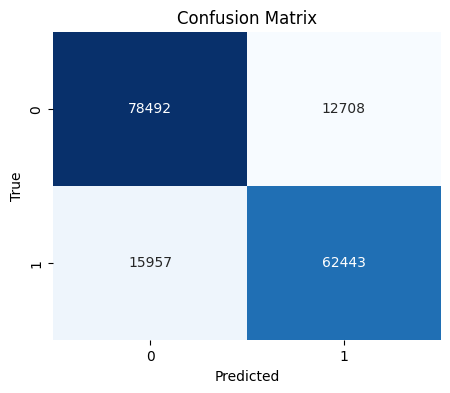

In [ ]:
y_true = result_assmt_df['y_true']
y_pred = result_assmt_df['y_pred']

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


It is interesting to see that the new model has managed to predict more tumors which are actually benign that has previously predicted as malignant. It has also managed to correctly predict a bit more tumors which were previously classified as benign, however not quite as many as benign.

In [ ]:
full_mass_assmt = result_mass.merge(result_assmt_df[['tumor_id', 'y_pred', 'y_prob']], on='tumor_id', how='left')
full_mass_assmt.head()

patient_id  breast_density left or right breast image view abnormality id  \
0    P_00001               3                 LEFT         CC              1   
1    P_00001               3                 LEFT         CC              1   
2    P_00001               3                 LEFT         CC              1   
3    P_00001               3                 LEFT         CC              1   
4    P_00001               3                 LEFT         CC              1   

  abnormality type  assessment  pathology  subtlety  \
0             mass           4  MALIGNANT         4   
1             mass           4  MALIGNANT         4   
2             mass           4  MALIGNANT         4   
3             mass           4  MALIGNANT         4   
4             mass           4  MALIGNANT         4   

                                     image file path  ... OVAL ROUND  \
0  Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...  ...    0     0   
1  Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...  ...    0     0   
2  Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...  ...    0     0   
3  Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...  ...    0     0   
4  Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...  ...    0     0   

   CIRCUMSCRIBED  ILL_DEFINED  MICROLOBULATED  OBSCURED  SPICULATED  \
0              0            0               0         0           1   
1              0            0               0         0           1   
2              0            0               0         0           1   
3              0            0               0         0           1   
4              0            0               0         0           1   

   malignant  y_pred    y_prob  
0          1       1  0.523597  
1          1       1  0.545235  
2          1       1  0.528927  
3          1       1  0.521272  
4          1       1  0.523431  

[5 rows x 30 columns]

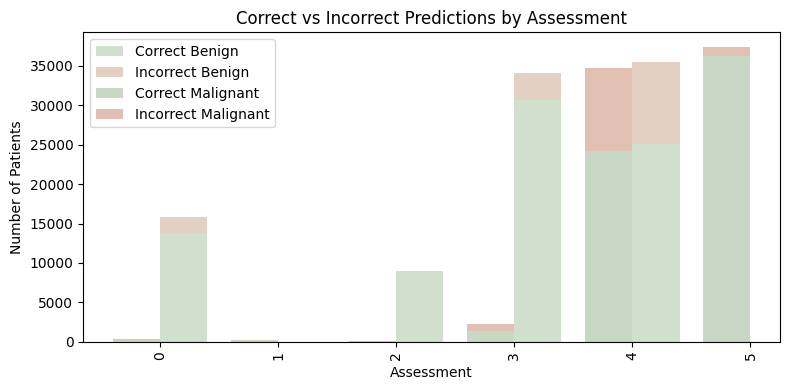

In [ ]:
# Calculate correct and incorrect predictions
correct_benign = full_mass_assmt[(full_mass_assmt['y_pred'] == 0) & (full_mass_assmt['pathology'] == 'BENIGN')]['assessment'].value_counts()
incorrect_benign = full_mass_assmt[(full_mass_assmt['y_pred'] == 0) & (full_mass_assmt['pathology'] == 'MALIGNANT')]['assessment'].value_counts()

correct_malignant = full_mass_assmt[(full_mass_assmt['y_pred'] == 1) & (full_mass_assmt['pathology'] == 'MALIGNANT')]['assessment'].value_counts()
incorrect_malignant = full_mass_assmt[(full_mass_assmt['y_pred'] == 1) & (full_mass_assmt['pathology'] == 'BENIGN')]['assessment'].value_counts()

# Combine the counts into a DataFrame for plotting
prediction_counts = pd.DataFrame({
    'Correct Benign': correct_benign,
    'Incorrect Benign': incorrect_benign,
    'Correct Malignant': correct_malignant,
    'Incorrect Malignant': incorrect_malignant
}).fillna(0)

fig, ax = plt.subplots(figsize=(8, 4))

prediction_counts[['Correct Benign', 'Incorrect Benign']].plot(kind='bar', ax=ax, color=['#D0E0CD', '#e4cfc3'], stacked=True, position=0, width=0.4, align='center', label='Benign')
prediction_counts[['Correct Malignant', 'Incorrect Malignant']].plot(kind='bar', ax=ax, color=['#C8D8C5', '#E1BFB3'], stacked=True, position=1, width=0.4, align='center', label='Malignant')

ax.set_xlabel('Assessment')
ax.set_ylabel('Number of Patients')
ax.set_title('Correct vs Incorrect Predictions by Assessment')
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
counts_df = pd.DataFrame({
    'Correct Benign': correct_benign,
    'Incorrect Benign': incorrect_benign,
    'Correct Malignant': correct_malignant,
    'Incorrect Malignant': incorrect_malignant
}).fillna(0)


counts_df['Benign Accuracy'] = counts_df['Correct Benign'] / (counts_df['Correct Benign'] + counts_df['Incorrect Benign'])
counts_df['Malignant Accuracy'] = counts_df['Correct Malignant'] / (counts_df['Correct Malignant'] + counts_df['Incorrect Malignant'])
counts_df.fillna(0, inplace=True)

counts_df

Correct Benign  Incorrect Benign  Correct Malignant  \
assessment                                                        
0                  13862.0              1923              277.0   
1                      0.0                12              288.0   
2                   8934.0               100                0.0   
3                  30628.0              3487             1413.0   
4                  25068.0             10411            24189.0   
5                      0.0                24            36276.0   

            Incorrect Malignant  Benign Accuracy  Malignant Accuracy  
assessment                                                            
0                         138.0         0.878175            0.667470  
1                           0.0         0.000000            1.000000  
2                          66.0         0.988931            0.000000  
3                         872.0         0.897787            0.618381  
4                       10532.0         0.706559            0.696668  
5                        1100.0         0.000000            0.970569

# ROI Feature Extraction

In [22]:
roi_df = pd.read_csv('/content/drive/MyDrive/DDSM data/tumor_all_features_new.csv', sep = ',')

In [23]:
roi_df['File'] = roi_df['File'].str.replace('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/', '', regex=False)
roi_df['File'] = roi_df['File'].str[:-10]
roi_df

File    Area    Perimeter  \
0     1.3.6.1.4.1.9590.100.1.2.153339052913121382622...   73049  1283.009228   
1     1.3.6.1.4.1.9590.100.1.2.178994714611485132105...  101746  1789.962546   
2     1.3.6.1.4.1.9590.100.1.2.411833492612373627114...  589897  3774.552508   
3     1.3.6.1.4.1.9590.100.1.2.236373548712994183418...   68387  1588.143347   
4     1.3.6.1.4.1.9590.100.1.2.357008050412534761329...   90204  1971.030649   
...                                                 ...     ...          ...   
3242  1.3.6.1.4.1.9590.100.1.2.374221285124370132151...   94457  1310.943213   
3243  1.3.6.1.4.1.9590.100.1.2.195242971118587811360...  159411  2724.965845   
3244  1.3.6.1.4.1.9590.100.1.2.263713351013050806016...   81133  2060.417513   
3245  1.3.6.1.4.1.9590.100.1.2.627982547125586065005...  292333  3959.809764   
3246  1.3.6.1.4.1.9590.100.1.2.285138900913160236325...  333421  3571.923339   

      Longest Axis  Shortest Axis  Circularity  Eccentricity  Aspect Ratio  \
0       455.738892     219.047836     0.754487      0.876916      2.080545   
1       617.249329     263.515625     0.569651      0.904290      2.342363   
2      1183.508545     732.803162     0.760715      0.785250      1.615043   
3       321.272156     282.759125     0.839021      0.474745      1.136204   
4       439.072510     266.375885     0.806350      0.794947      1.648319   
...            ...            ...          ...           ...           ...   
3242    385.952026     310.660858     0.949397      0.593382      1.242358   
3243    493.527313     417.691406     0.837700      0.532645      1.181560   
3244    353.669312     317.221832     0.787833      0.442143      1.114896   
3245   1825.662231     273.368073     0.274839      0.988726      6.678403   
3246    717.127441     599.862793     0.886793      0.547997      1.195486   

      Convex Hull Area  Solidity  Compactness  Jaggedness  
0              77376.0  0.944078     1.793228    1.170973  
1             131312.5  0.774839     2.505882    1.155898  
2             642880.0  0.917585     1.921962    1.202108  
3              77519.5  0.882191     2.934918    1.441575  
4             102234.5  0.882324     3.427292    1.537265  
...                ...       ...          ...         ...  
3242           96864.0  0.975151     1.447851    1.186748  
3243          180701.0  0.882181     3.706756    1.544532  
3244           96028.0  0.844889     4.163927    1.627702  
3245          379375.5  0.770564     4.268359    1.085430  
3246          366520.5  0.909693     3.045099    1.563583  

[3247 rows x 12 columns]

In [24]:
def remove_up_to_second_slash(path):
    parts = path.split('/')
    return '/'.join(parts[2:])

In [25]:
mass_roi = result_mass
mass_roi['ROI mask file path'] = mass_roi['ROI mask file path'].str[:-12]
mass_roi['ROI mask file path'] = mass_roi['ROI mask file path'].apply(remove_up_to_second_slash)
mass_roi

patient_id  breast_density left or right breast image view  \
0       P_00001               3                 LEFT         CC   
1       P_00001               3                 LEFT        MLO   
2       P_00004               3                 LEFT         CC   
3       P_00004               3                 LEFT        MLO   
4       P_00004               3                RIGHT        MLO   
...         ...             ...                  ...        ...   
1691    P_01825               2                RIGHT        MLO   
1692    P_01833               2                RIGHT        MLO   
1693    P_01865               2                 LEFT        MLO   
1694    P_01912               3                RIGHT         CC   
1695    P_01912               3                RIGHT        MLO   

     abnormality id abnormality type  assessment  pathology  subtlety  \
0                 1             mass           4  MALIGNANT         4   
1                 1             mass           4  MALIGNANT         4   
2                 1             mass           4     BENIGN         3   
3                 1             mass           4     BENIGN         3   
4                 1             mass           4     BENIGN         5   
...             ...              ...         ...        ...       ...   
1691              1             mass           3     BENIGN         3   
1692              1             mass           5  MALIGNANT         5   
1693              1             mass           4  MALIGNANT         2   
1694              1             mass           5  MALIGNANT         4   
1695              1             mass           5  MALIGNANT         4   

                                        image file path  ... LOBULATED  \
0     Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...  ...         0   
1     Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...  ...         0   
2     Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...  ...         0   
3     Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...  ...         0   
4     Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...  ...         0   
...                                                 ...  ...       ...   
1691  Mass-Test_P_01825_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...         1   
1692  Mass-Test_P_01833_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...         0   
1693  Mass-Test_P_01865_LEFT_MLO/1.3.6.1.4.1.9590.10...  ...         0   
1694  Mass-Test_P_01912_RIGHT_CC/1.3.6.1.4.1.9590.10...  ...         0   
1695  Mass-Test_P_01912_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...         0   

     LYMPH_NODE  OVAL  ROUND  CIRCUMSCRIBED  ILL_DEFINED  MICROLOBULATED  \
0             0     0      0              0            0               0   
1             0     0      0              0            0               0   
2             0     0      0              0            1               0   
3             0     0      0              0            1               0   
4             0     1      0              1            0               0   
...         ...   ...    ...            ...          ...             ...   
1691          0     0      0              0            0               1   
1692          0     0      0              0            1               0   
1693          0     0      0              0            1               0   
1694          0     0      0              0            0               0   
1695          0     0      0              0            0               0   

      OBSCURED  SPICULATED  malignant  
0            0           1          1  
1            0           1          1  
2            0           0          0  
3            0           0          0  
4            0           0          0  
...        ...         ...        ...  
1691         0           0          0  
1692         0           0          1  
1693         0           0          1  
1694         0           1          1  
1695         0           1          1  

[1696 rows x 28 columns]

In [26]:
mass_roi = mass_roi.merge(roi_df, left_on='ROI mask file path', right_on='File', how='left')
mass_roi

patient_id  breast_density left or right breast image view  \
0       P_00001               3                 LEFT         CC   
1       P_00001               3                 LEFT        MLO   
2       P_00004               3                 LEFT         CC   
3       P_00004               3                 LEFT        MLO   
4       P_00004               3                RIGHT        MLO   
...         ...             ...                  ...        ...   
1691    P_01825               2                RIGHT        MLO   
1692    P_01833               2                RIGHT        MLO   
1693    P_01865               2                 LEFT        MLO   
1694    P_01912               3                RIGHT         CC   
1695    P_01912               3                RIGHT        MLO   

     abnormality id abnormality type  assessment  pathology  subtlety  \
0                 1             mass           4  MALIGNANT         4   
1                 1             mass           4  MALIGNANT         4   
2                 1             mass           4     BENIGN         3   
3                 1             mass           4     BENIGN         3   
4                 1             mass           4     BENIGN         5   
...             ...              ...         ...        ...       ...   
1691              1             mass           3     BENIGN         3   
1692              1             mass           5  MALIGNANT         5   
1693              1             mass           4  MALIGNANT         2   
1694              1             mass           5  MALIGNANT         4   
1695              1             mass           5  MALIGNANT         4   

                                        image file path  ...    Perimeter  \
0     Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...  ...  3085.887637   
1     Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...  ...  1200.236712   
2     Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...  ...  2766.321184   
3     Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...  ...  3002.002423   
4     Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...  ...  2394.372918   
...                                                 ...  ...          ...   
1691  Mass-Test_P_01825_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...  1272.999124   
1692  Mass-Test_P_01833_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...  2312.975950   
1693  Mass-Test_P_01865_LEFT_MLO/1.3.6.1.4.1.9590.10...  ...  1438.597103   
1694  Mass-Test_P_01912_RIGHT_CC/1.3.6.1.4.1.9590.10...  ...  2487.897742   
1695  Mass-Test_P_01912_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...  1767.155540   

     Longest Axis  Shortest Axis  Circularity  Eccentricity  Aspect Ratio  \
0      436.138031     371.961121     0.787288      0.522153      1.172537   
1      216.311172     199.950745     0.777106      0.381506      1.081822   
2      397.924713     368.702179     0.818572      0.376140      1.079258   
3      358.107056     331.877808     0.766013      0.375664      1.079033   
4      386.666870     313.786041     0.785112      0.584331      1.232263   
...           ...            ...          ...           ...           ...   
1691   225.898102     164.048126     0.738653      0.687479      1.377023   
1692   494.025787     442.596893     0.895535      0.444259      1.116198   
1693   296.116455     154.561035     0.565147      0.852970      1.915855   
1694   384.267700     330.945831     0.808170      0.508202      1.161120   
1695   349.156158     278.260223     0.767926      0.604044      1.254783   

      Convex Hull Area  Solidity  Compactness  Jaggedness  
0             144944.5  0.831774     6.285553    1.918282  
1              38948.5  0.826681     3.560369    1.394815  
2             132114.5  0.857506     5.375361    1.842405  
3             111371.0  0.803396     8.015129    1.902236  
4             109045.5  0.841465     4.971985    1.673093  
...                ...       ...          ...         ...  
1691           33468.5  0.812495     4.742302    1.53

In [27]:
mass_roi.to_csv('ROI_feature_extraction_maxArea_skimage_merged.csv', index=False)

## ROI features and BI-RADS

In [28]:
from sklearn.preprocessing import MinMaxScaler

# Drop columns that are not needed for scaling and one-hot encoding
mass_roi_one_hot = mass_roi.drop(['abnormality type', 'assessment', 'pathology', 'subtlety', 'image file path',
                                   'cropped image file path', 'ROI mask file path', 'File'], axis=1)

# Apply one-hot encoding to the specified categorical columns on the filtered DataFrame
mass_roi_one_hot = pd.get_dummies(mass_roi_one_hot, columns=['breast_density', 'left or right breast', 'image view'], dtype=int)

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Specify the columns to be scaled
columns_to_scale = ['Area', 'Perimeter', 'Longest Axis', 'Shortest Axis', 'Circularity', 'Eccentricity',
                    'Aspect Ratio', 'Convex Hull Area', 'Solidity', 'Compactness', 'Jaggedness']

# Apply scaling only to the specified columns
mass_roi_one_hot[columns_to_scale] = scaler.fit_transform(mass_roi_one_hot[columns_to_scale])


In [29]:
mass_roi_one_hot

patient_id abnormality id  tumor_id  multiple_tumors  \
0       P_00001              1         1              0.0   
1       P_00001              1         2              0.0   
2       P_00004              1         3              0.0   
3       P_00004              1         4              0.0   
4       P_00004              1         5              0.0   
...         ...            ...       ...              ...   
1691    P_01825              1      1692              0.0   
1692    P_01833              1      1693              0.0   
1693    P_01865              1      1694              0.0   
1694    P_01912              1      1695              0.0   
1695    P_01912              1      1696              0.0   

      ARCHITECTURAL_DISTORTION  ASYMMETRIC_BREAST_TISSUE  \
0                            1                         0   
1                            1                         0   
2                            1                         0   
3                            1                         0   
4                            0                         0   
...                        ...                       ...   
1691                         0                         0   
1692                         0                         0   
1693                         0                         0   
1694                         0                         0   
1695                         0                         0   

      FOCAL_ASYMMETRIC_DENSITY  IRREGULAR  LOBULATED  LYMPH_NODE  ...  \
0                            0          1          0           0  ...   
1                            0          1          0           0  ...   
2                            0          0          0           0  ...   
3                            0          0          0           0  ...   
4                            0          0          0           0  ...   
...                        ...        ...        ...         ...  ...   
1691                         0          0          1           0  ...   
1692                         0          1          0           0  ...   
1693                         0          1          0           0  ...   
1694                         0          1          0           0  ...   
1695                         0          1          0           0  ...   

      Compactness  Jaggedness  breast_density_1  breast_density_2  \
0        0.466168    0.531531                 0                 0   
1        0.222433    0.214408                 0                 0   
2        0.384762    0.485563                 0                 0   
3        0.620858    0.521810                 0                 0   
4        0.348685    0.382992                 0                 0   
...           ...         ...               ...               ...   
1691     0.328143    0.297699                 0                 1   
1692     0.129770    0.278027                 0                 1   
1693     0.413305    0.277652                 0                 1   
1694     0.356524    0.450640                 0                 0   
1695     0.218968    0.285841                 0                 0   

      breast_density_3  breast_density_4  left or right breast_LEFT  \
0                    1                 0                          1   
1                    1                 0                          1   
2                    1                 0                          1   
3                    1                 0                          1   
4                    1                 0                          0   
...                ...               ...                        ...   
1691                 0                 0                          0   
1692                 0                 0                          0   
1693                 0                 0                          1   
1694                 1                 0                          0   
1695                 1                 0                        

In [ ]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Ridge Classifier": RidgeClassifier(),
    "Ada Boost Classifier": AdaBoostClassifier(),
    "Extra Trees Classifier": ExtraTreesClassifier(),
    "LightGBM": LGBMClassifier(),
    "XGBoost": XGBClassifier(),
    "Random Forest": RandomForestClassifier(),
    "K Neighbors Classifier": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    # "SVM - Linear": SVC(kernel='linear', probability=True),
    "Naive Bayes": GaussianNB()
}

num_runs = 100
n_splits = 10

for run in range(num_runs):
    # Shuffle and reset the index of the original DataFrame
    tumor_features_df_shuffled = mass_roi_one_hot.sample(frac=1, random_state=42*run).reset_index(drop=True)

    # Features and target
    X = tumor_features_df_shuffled.drop(['malignant', 'patient_id', 'tumor_id', 'abnormality id'], axis=1)
    y = tumor_features_df_shuffled['malignant']
    groups = tumor_features_df_shuffled['patient_id']
    abnormality_ids = tumor_features_df_shuffled['abnormality id']
    tumor_id = tumor_features_df_shuffled['tumor_id']

    # Replace whitespaces in feature names with underscores
    X.columns = [col.replace(" ", "_") for col in X.columns]

    all_predictions = []

    # Get unique patient IDs
    unique_patient_ids = groups.unique()
    np.random.seed(42*run)  # Set seed for reproducibility

    # Shuffle the patient IDs
    np.random.shuffle(unique_patient_ids)

    # Split the patient IDs into folds
    fold_size = len(unique_patient_ids) // n_splits
    predefined_splits = []

    for fold in range(n_splits):
        test_ids = unique_patient_ids[fold * fold_size: (fold + 1) * fold_size]
        train_ids = np.setdiff1d(unique_patient_ids, test_ids)
        predefined_splits.append((train_ids, test_ids))

    # Handle any patient IDs not included in the folds
    all_test_ids = np.concatenate([test_ids for _, test_ids in predefined_splits])
    missing_ids = np.setdiff1d(unique_patient_ids, all_test_ids)
    print(missing_ids)
    if len(missing_ids) > 0:
        for missing_id in missing_ids:
            random_fold = np.random.choice(n_splits)
            train_ids, test_ids = predefined_splits[random_fold]
            test_ids = np.append(test_ids, missing_id)
            predefined_splits[random_fold] = (train_ids, test_ids)

    group_kfold = GroupKFold(n_splits=n_splits)

    for model_name, model in models.items():
        original_model = copy.deepcopy(model) # run folds on og
        fold_count = 1
        all_model_predictions = []

        for fold_idx, (train_ids, test_ids) in enumerate(predefined_splits):
            model = copy.deepcopy(original_model)
            train_idx = groups.isin(train_ids)
            test_idx = groups.isin(test_ids)

            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            patient_ids = groups[test_idx]
            abnormality_test_ids = abnormality_ids[test_idx]
            tumor_id_test = tumor_id[test_idx]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            if hasattr(model, "predict_proba"):
                y_prob = model.predict_proba(X_test)[:, 1]
                for pid, ab_id, y_t, y_p, y_pr, t_id in zip(patient_ids, abnormality_test_ids, y_test, y_pred, y_prob, tumor_id_test):
                    all_model_predictions.append((pid, ab_id, y_t, y_p, y_pr, fold_count, t_id))
            else:
                for pid, ab_id, y_t, y_p, t_id in zip(patient_ids, abnormality_test_ids, y_test, y_pred, tumor_id_test):
                    all_model_predictions.append((pid, ab_id, y_t, y_p, None, fold_count, t_id))

            fold_count += 1

        predictions_df = pd.DataFrame(all_model_predictions, columns=['patient_id', 'abnormality id', 'y_true', 'y_pred', 'y_prob', 'fold_number', 'tumor_id'])

        # Include only the specified columns
        predictions_df = predictions_df[['patient_id', 'abnormality id', 'y_true', 'y_pred', 'y_prob', 'fold_number', 'tumor_id']]

        predictions_df.to_csv(f'/content/drive/My Drive/DDSM data/DDSM_compareModels_Mass/all_features_and_biRads/Results_{model_name}_{run + 1}.csv', index=False)


['P_00054' 'P_01413']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 709, number of negative: 821
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1530, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.463399 -> initscore=-0.146668
[LightGBM] [Info] Start training from score -0.146668
[LightGBM] [Info] Number of positive: 708, number of negative: 828
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1536, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 700, number of negative: 817
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1517, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.461437 -> initscore=-0.154559
[LightGBM] [Info] Start training from score -0.154559
[LightGBM] [Info] Number of positive: 712, number of negative: 815
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1527, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 695, number of negative: 840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1535, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.452769 -> initscore=-0.189490
[LightGBM] [Info] Start training from score -0.189490
[LightGBM] [Info] Number of positive: 712, number of negative: 833
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1545, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 698, number of negative: 835
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1533, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.455316 -> initscore=-0.179213
[LightGBM] [Info] Start training from score -0.179213
[LightGBM] [Info] Number of positive: 698, number of negative: 826
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1524, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 712, number of negative: 814
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1526, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.466579 -> initscore=-0.133882
[LightGBM] [Info] Start training from score -0.133882
[LightGBM] [Info] Number of positive: 706, number of negative: 828
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1534, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 691, number of negative: 843
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1534, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.450456 -> initscore=-0.198827
[LightGBM] [Info] Start training from score -0.198827
[LightGBM] [Info] Number of positive: 713, number of negative: 814
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1527, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 712, number of negative: 797
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1509, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.471836 -> initscore=-0.112777
[LightGBM] [Info] Start training from score -0.112777
[LightGBM] [Info] Number of positive: 689, number of negative: 825
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1514, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 716, number of negative: 823
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2847
[LightGBM] [Info] Number of data points in the train set: 1539, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.465237 -> initscore=-0.139276
[LightGBM] [Info] Start training from score -0.139276
[LightGBM] [Info] Number of positive: 712, number of negative: 830
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1542, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 717, number of negative: 815
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2847
[LightGBM] [Info] Number of data points in the train set: 1532, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.468016 -> initscore=-0.128112
[LightGBM] [Info] Start training from score -0.128112
[LightGBM] [Info] Number of positive: 696, number of negative: 826
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1522, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 697, number of negative: 840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2847
[LightGBM] [Info] Number of data points in the train set: 1537, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.453481 -> initscore=-0.186616
[LightGBM] [Info] Start training from score -0.186616
[LightGBM] [Info] Number of positive: 710, number of negative: 812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1522, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 720, number of negative: 809
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1529, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.470896 -> initscore=-0.116548
[LightGBM] [Info] Start training from score -0.116548
[LightGBM] [Info] Number of positive: 702, number of negative: 811
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1513, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 706, number of negative: 812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1518, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.465086 -> initscore=-0.139885
[LightGBM] [Info] Start training from score -0.139885
[LightGBM] [Info] Number of positive: 704, number of negative: 826
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1530, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.460131 -> initscore=-0.159816
[LightGBM] [

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 705, number of negative: 836
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1541, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.457495 -> initscore=-0.170431
[LightGBM] [Info] Start training from score -0.170431
[LightGBM] [Info] Number of positive: 692, number of negative: 841
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2847
[LightGBM] [Info] Number of data points in the train set: 1533, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.451402 -> initscore=-0.195006
[LightGBM] [Info] Start training from score -0.195006
[LightGBM] [Info] Numb

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 708, number of negative: 797
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1505, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.470432 -> initscore=-0.118411
[LightGBM] [Info] Start training from score -0.118411
[LightGBM] [Info] Number of positive: 697, number of negative: 837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1534, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 709, number of negative: 824
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1533, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.462492 -> initscore=-0.150315
[LightGBM] [Info] Start training from score -0.150315
[LightGBM] [Info] Number of positive: 704, number of negative: 830
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1534, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 711, number of negative: 808
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1519, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.468071 -> initscore=-0.127890
[LightGBM] [Info] Start training from score -0.127890
[LightGBM] [Info] Number of positive: 694, number of negative: 838
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1532, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 720, number of negative: 813
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1533, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.469667 -> initscore=-0.121480
[LightGBM] [Info] Start training from score -0.121480
[LightGBM] [Info] Number of positive: 707, number of negative: 816
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1523, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 693, number of negative: 834
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1527, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.453831 -> initscore=-0.185203
[LightGBM] [Info] Start training from score -0.185203
[LightGBM] [Info] Number of positive: 710, number of negative: 820
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1530, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 719, number of negative: 820
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2847
[LightGBM] [Info] Number of data points in the train set: 1539, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.467186 -> initscore=-0.131443
[LightGBM] [Info] Start training from score -0.131443
[LightGBM] [Info] Number of positive: 712, number of negative: 813
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2847
[LightGBM] [Info] Number of data points in the train set: 1525, number of used features: 32
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 710, number of negative: 810
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.467105 -> initscore=-0.131769
[LightGBM] [Info] Start training from score -0.131769
[LightGBM] [Info] Number of positive: 696, number of negative: 818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1514, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 711, number of negative: 816
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1527, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.465619 -> initscore=-0.137742
[LightGBM] [Info] Start training from score -0.137742
[LightGBM] [Info] Number of positive: 684, number of negative: 843
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1527, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 710, number of negative: 825
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1535, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.462541 -> initscore=-0.150118
[LightGBM] [Info] Start training from score -0.150118
[LightGBM] [Info] Number of positive: 707, number of negative: 827
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1534, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 703, number of negative: 827
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1530, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.459477 -> initscore=-0.162448
[LightGBM] [Info] Start training from score -0.162448
[LightGBM] [Info] Number of positive: 704, number of negative: 829
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1533, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 703, number of negative: 828
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1531, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.459177 -> initscore=-0.163656
[LightGBM] [Info] Start training from score -0.163656
[LightGBM] [Info] Number of positive: 717, number of negative: 817
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1534, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 708, number of negative: 821
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1529, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.463048 -> initscore=-0.148079
[LightGBM] [Info] Start training from score -0.148079
[LightGBM] [Info] Number of positive: 704, number of negative: 827
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1531, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 710, number of negative: 822
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2847
[LightGBM] [Info] Number of data points in the train set: 1532, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.463446 -> initscore=-0.146475
[LightGBM] [Info] Start training from score -0.146475
[LightGBM] [Info] Number of positive: 708, number of negative: 826
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1534, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 704, number of negative: 823
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1527, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.461035 -> initscore=-0.156178
[LightGBM] [Info] Start training from score -0.156178
[LightGBM] [Info] Number of positive: 703, number of negative: 829
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1532, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 706, number of negative: 810
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.465699 -> initscore=-0.137419
[LightGBM] [Info] Start training from score -0.137419
[LightGBM] [Info] Number of positive: 711, number of negative: 813
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1524, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 706, number of negative: 819
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1525, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.462951 -> initscore=-0.148469
[LightGBM] [Info] Start training from score -0.148469
[LightGBM] [Info] Number of positive: 719, number of negative: 809
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1528, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 693, number of negative: 819
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1512, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458333 -> initscore=-0.167054
[LightGBM] [Info] Start training from score -0.167054
[LightGBM] [Info] Number of positive: 719, number of negative: 808
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1527, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 702, number of negative: 822
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1524, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.460630 -> initscore=-0.157807
[LightGBM] [Info] Start training from score -0.157807
[LightGBM] [Info] Number of positive: 697, number of negative: 811
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1508, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 697, number of negative: 810
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1507, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.462508 -> initscore=-0.150249
[LightGBM] [Info] Start training from score -0.150249
[LightGBM] [Info] Number of positive: 677, number of negative: 855
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1532, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 700, number of negative: 813
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1513, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.462657 -> initscore=-0.149651
[LightGBM] [Info] Start training from score -0.149651
[LightGBM] [Info] Number of positive: 699, number of negative: 823
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1522, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 708, number of negative: 819
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1527, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.463654 -> initscore=-0.145640
[LightGBM] [Info] Start training from score -0.145640
[LightGBM] [Info] Number of positive: 719, number of negative: 812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1531, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 721, number of negative: 814
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1535, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.469707 -> initscore=-0.121321
[LightGBM] [Info] Start training from score -0.121321
[LightGBM] [Info] Number of positive: 713, number of negative: 822
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1535, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 703, number of negative: 819
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1522, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.461892 -> initscore=-0.152727
[LightGBM] [Info] Start training from score -0.152727
[LightGBM] [Info] Number of positive: 720, number of negative: 804
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1524, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 726, number of negative: 809
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1535, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.472964 -> initscore=-0.108249
[LightGBM] [Info] Start training from score -0.108249
[LightGBM] [Info] Number of positive: 717, number of negative: 821
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1538, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 703, number of negative: 809
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1512, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.464947 -> initscore=-0.140442
[LightGBM] [Info] Start training from score -0.140442
[LightGBM] [Info] Number of positive: 717, number of negative: 808
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1525, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 718, number of negative: 819
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1537, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.467144 -> initscore=-0.131615
[LightGBM] [Info] Start training from score -0.131615
[LightGBM] [Info] Number of positive: 702, number of negative: 821
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1523, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.460932 -> initscore=-0.156590
[LightGBM] [

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 707, number of negative: 817
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1524, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.463911 -> initscore=-0.144608
[LightGBM] [Info] Start training from score -0.144608
[LightGBM] [Info] Number of positive: 688, number of negative: 833
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1521, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.452334 -> initscore=-0.191245
[LightGBM] [

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 708, number of negative: 825
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1533, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.461840 -> initscore=-0.152939
[LightGBM] [Info] Start training from score -0.152939
[LightGBM] [Info] Number of positive: 706, number of negative: 827
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1533, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 702, number of negative: 829
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1531, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458524 -> initscore=-0.166287
[LightGBM] [Info] Start training from score -0.166287
[LightGBM] [Info] Number of positive: 726, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1526, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 700, number of negative: 831
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1531, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.457218 -> initscore=-0.171549
[LightGBM] [Info] Start training from score -0.171549
[LightGBM] [Info] Number of positive: 714, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1514, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.471598 -> initscore=-0.113729
[LightGBM] [

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 716, number of negative: 803
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1519, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.471363 -> initscore=-0.114675
[LightGBM] [Info] Start training from score -0.114675
[LightGBM] [Info] Number of positive: 687, number of negative: 832
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1519, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 707, number of negative: 812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1519, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.465438 -> initscore=-0.138470
[LightGBM] [Info] Start training from score -0.138470
[LightGBM] [Info] Number of positive: 699, number of negative: 829
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1528, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 686, number of negative: 844
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1530, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448366 -> initscore=-0.207275
[LightGBM] [Info] Start training from score -0.207275
[LightGBM] [Info] Number of positive: 726, number of negative: 812
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1538, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.472042 -> initscore=-0.111950
[LightGBM] [

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 696, number of negative: 835
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1531, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.454605 -> initscore=-0.182082
[LightGBM] [Info] Start training from score -0.182082
[LightGBM] [Info] Number of positive: 696, number of negative: 843
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1539, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 714, number of negative: 798
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1512, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.472222 -> initscore=-0.111226
[LightGBM] [Info] Start training from score -0.111226
[LightGBM] [Info] Number of positive: 696, number of negative: 817
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1513, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 725, number of negative: 803
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1528, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.474476 -> initscore=-0.102183
[LightGBM] [Info] Start training from score -0.102183
[LightGBM] [Info] Number of positive: 706, number of negative: 816
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1522, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 697, number of negative: 818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1515, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.460066 -> initscore=-0.160077
[LightGBM] [Info] Start training from score -0.160077
[LightGBM] [Info] Number of positive: 696, number of negative: 839
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1535, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 697, number of negative: 828
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1525, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.457049 -> initscore=-0.172228
[LightGBM] [Info] Start training from score -0.172228
[LightGBM] [Info] Number of positive: 713, number of negative: 823
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1536, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.464193 -> initscore=-0.143475
[LightGBM] [

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 711, number of negative: 830
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1541, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.461389 -> initscore=-0.154753
[LightGBM] [Info] Start training from score -0.154753
[LightGBM] [Info] Number of positive: 704, number of negative: 815
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2847
[LightGBM] [Info] Number of data points in the train set: 1519, number of used features: 32
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 715, number of negative: 807
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1522, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.469777 -> initscore=-0.121041
[LightGBM] [Info] Start training from score -0.121041
[LightGBM] [Info] Number of positive: 711, number of negative: 810
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1521, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 697, number of negative: 833
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1530, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.455556 -> initscore=-0.178248
[LightGBM] [Info] Start training from score -0.178248
[LightGBM] [Info] Number of positive: 721, number of negative: 807
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1528, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 727, number of negative: 811
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1538, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.472692 -> initscore=-0.109342
[LightGBM] [Info] Start training from score -0.109342
[LightGBM] [Info] Number of positive: 697, number of negative: 844
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1541, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 692, number of negative: 804
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1496, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.462567 -> initscore=-0.150013
[LightGBM] [Info] Start training from score -0.150013
[LightGBM] [Info] Number of positive: 687, number of negative: 837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1524, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 698, number of negative: 809
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1507, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.463172 -> initscore=-0.147580
[LightGBM] [Info] Start training from score -0.147580
[LightGBM] [Info] Number of positive: 709, number of negative: 820
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1529, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 707, number of negative: 812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1519, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.465438 -> initscore=-0.138470
[LightGBM] [Info] Start training from score -0.138470
[LightGBM] [Info] Number of positive: 698, number of negative: 819
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1517, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 701, number of negative: 826
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1527, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.459070 -> initscore=-0.164087
[LightGBM] [Info] Start training from score -0.164087
[LightGBM] [Info] Number of positive: 711, number of negative: 826
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1537, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 704, number of negative: 837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1541, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.456846 -> initscore=-0.173046
[LightGBM] [Info] Start training from score -0.173046
[LightGBM] [Info] Number of positive: 704, number of negative: 818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1522, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 687, number of negative: 824
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1511, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.454666 -> initscore=-0.181836
[LightGBM] [Info] Start training from score -0.181836
[LightGBM] [Info] Number of positive: 703, number of negative: 816
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1519, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.462804 -> initscore=-0.149057
[LightGBM] [Info] Start training from score -0.149057
[LightGBM] [Info] Numb

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 702, number of negative: 810
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1512, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.464286 -> initscore=-0.143101
[LightGBM] [Info] Start training from score -0.143101
[LightGBM] [Info] Number of positive: 703, number of negative: 838
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1541, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 714, number of negative: 825
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1539, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.463938 -> initscore=-0.144500
[LightGBM] [Info] Start training from score -0.144500
[LightGBM] [Info] Number of positive: 702, number of negative: 815
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1517, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 706, number of negative: 829
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1535, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.459935 -> initscore=-0.160605
[LightGBM] [Info] Start training from score -0.160605
[LightGBM] [Info] Number of positive: 705, number of negative: 828
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1533, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 707, number of negative: 801
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1508, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.468833 -> initscore=-0.124830
[LightGBM] [Info] Start training from score -0.124830
[LightGBM] [Info] Number of positive: 720, number of negative: 813
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1533, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 712, number of negative: 824
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1536, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.463542 -> initscore=-0.146093
[LightGBM] [Info] Start training from score -0.146093
[LightGBM] [Info] Number of positive: 695, number of negative: 812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2847
[LightGBM] [Info] Number of data points in the train set: 1507, number of used features: 32
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 701, number of negative: 815
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.462401 -> initscore=-0.150680
[LightGBM] [Info] Start training from score -0.150680
[LightGBM] [Info] Number of positive: 710, number of negative: 826
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1536, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 698, number of negative: 836
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1534, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.455020 -> initscore=-0.180410
[LightGBM] [Info] Start training from score -0.180410
[LightGBM] [Info] Number of positive: 707, number of negative: 817
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1524, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.463911 -> initscore=-0.144608
[LightGBM] [Info] Start training from score -0.144608
[LightGBM] [Info] Numb

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 712, number of negative: 816
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1528, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.465969 -> initscore=-0.136336
[LightGBM] [Info] Start training from score -0.136336
[LightGBM] [Info] Number of positive: 705, number of negative: 820
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1525, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.462295 -> initscore=-0.151107
[LightGBM] [

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 702, number of negative: 823
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2847
[LightGBM] [Info] Number of data points in the train set: 1525, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.460328 -> initscore=-0.159023
[LightGBM] [Info] Start training from score -0.159023
[LightGBM] [Info] Number of positive: 687, number of negative: 839
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1526, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.450197 -> initscore=-0.199876
[LightGBM] [

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 692, number of negative: 829
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2847
[LightGBM] [Info] Number of data points in the train set: 1521, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.454964 -> initscore=-0.180634
[LightGBM] [Info] Start training from score -0.180634
[LightGBM] [Info] Number of positive: 711, number of negative: 807
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1518, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.468379 -> initscore=-0.126651
[LightGBM] [

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 714, number of negative: 802
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.470976 -> initscore=-0.116226
[LightGBM] [Info] Start training from score -0.116226
[LightGBM] [Info] Number of positive: 709, number of negative: 812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1521, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 717, number of negative: 818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1535, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.467101 -> initscore=-0.131786
[LightGBM] [Info] Start training from score -0.131786
[LightGBM] [Info] Number of positive: 708, number of negative: 812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 719, number of negative: 815
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1534, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.468709 -> initscore=-0.125327
[LightGBM] [Info] Start training from score -0.125327
[LightGBM] [Info] Number of positive: 703, number of negative: 830
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1533, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 704, number of negative: 814
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1518, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.463768 -> initscore=-0.145182
[LightGBM] [Info] Start training from score -0.145182
[LightGBM] [Info] Number of positive: 700, number of negative: 826
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1526, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 705, number of negative: 811
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.465040 -> initscore=-0.140070
[LightGBM] [Info] Start training from score -0.140070
[LightGBM] [Info] Number of positive: 691, number of negative: 843
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1534, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 696, number of negative: 815
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1511, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.460622 -> initscore=-0.157838
[LightGBM] [Info] Start training from score -0.157838
[LightGBM] [Info] Number of positive: 706, number of negative: 828
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1534, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 699, number of negative: 829
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1528, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.457461 -> initscore=-0.170569
[LightGBM] [Info] Start training from score -0.170569
[LightGBM] [Info] Number of positive: 698, number of negative: 823
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1521, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 721, number of negative: 806
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1527, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.472168 -> initscore=-0.111445
[LightGBM] [Info] Start training from score -0.111445
[LightGBM] [Info] Number of positive: 718, number of negative: 792
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1510, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 712, number of negative: 794
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1506, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.472776 -> initscore=-0.109006
[LightGBM] [Info] Start training from score -0.109006
[LightGBM] [Info] Number of positive: 706, number of negative: 838
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1544, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 703, number of negative: 826
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1529, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.459778 -> initscore=-0.161238
[LightGBM] [Info] Start training from score -0.161238
[LightGBM] [Info] Number of positive: 707, number of negative: 826
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1533, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 707, number of negative: 826
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1533, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.461187 -> initscore=-0.155564
[LightGBM] [Info] Start training from score -0.155564
[LightGBM] [Info] Number of positive: 708, number of negative: 812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 707, number of negative: 807
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1514, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.466975 -> initscore=-0.132293
[LightGBM] [Info] Start training from score -0.132293
[LightGBM] [Info] Number of positive: 710, number of negative: 826
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1536, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 714, number of negative: 810
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1524, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.468504 -> initscore=-0.126151
[LightGBM] [Info] Start training from score -0.126151
[LightGBM] [Info] Number of positive: 699, number of negative: 820
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1519, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 718, number of negative: 821
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1539, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.466537 -> initscore=-0.134054
[LightGBM] [Info] Start training from score -0.134054
[LightGBM] [Info] Number of positive: 687, number of negative: 825
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1512, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 699, number of negative: 837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1536, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.455078 -> initscore=-0.180173
[LightGBM] [Info] Start training from score -0.180173
[LightGBM] [Info] Number of positive: 713, number of negative: 802
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1515, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 704, number of negative: 813
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1517, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.464074 -> initscore=-0.143953
[LightGBM] [Info] Start training from score -0.143953
[LightGBM] [Info] Number of positive: 694, number of negative: 832
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1526, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 709, number of negative: 799
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1508, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.470159 -> initscore=-0.119505
[LightGBM] [Info] Start training from score -0.119505
[LightGBM] [Info] Number of positive: 697, number of negative: 827
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1524, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 701, number of negative: 831
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1532, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.457572 -> initscore=-0.170122
[LightGBM] [Info] Start training from score -0.170122
[LightGBM] [Info] Number of positive: 712, number of negative: 819
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1531, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 711, number of negative: 819
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1530, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.464706 -> initscore=-0.141412
[LightGBM] [Info] Start training from score -0.141412
[LightGBM] [Info] Number of positive: 703, number of negative: 814
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1517, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.463415 -> initscore=-0.146603
[LightGBM] [

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 718, number of negative: 783
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1501, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.478348 -> initscore=-0.086663
[LightGBM] [Info] Start training from score -0.086663
[LightGBM] [Info] Number of positive: 699, number of negative: 809
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1508, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 697, number of negative: 832
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1529, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.455853 -> initscore=-0.177047
[LightGBM] [Info] Start training from score -0.177047
[LightGBM] [Info] Number of positive: 691, number of negative: 817
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1508, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 720, number of negative: 830
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1550, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.464516 -> initscore=-0.142174
[LightGBM] [Info] Start training from score -0.142174
[LightGBM] [Info] Number of positive: 705, number of negative: 815
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2847
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.463816 -> initscore=-0.144990
[LightGBM] [

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 708, number of negative: 824
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1532, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.462141 -> initscore=-0.151726
[LightGBM] [Info] Start training from score -0.151726
[LightGBM] [Info] Number of positive: 706, number of negative: 821
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1527, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 702, number of negative: 823
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1525, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.460328 -> initscore=-0.159023
[LightGBM] [Info] Start training from score -0.159023
[LightGBM] [Info] Number of positive: 707, number of negative: 820
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1527, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 710, number of negative: 830
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.461039 -> initscore=-0.156161
[LightGBM] [Info] Start training from score -0.156161
[LightGBM] [Info] Number of positive: 704, number of negative: 831
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1535, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458632 -> initscore=-0.165851
[LightGBM] [

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 705, number of negative: 829
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1534, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.459583 -> initscore=-0.162022
[LightGBM] [Info] Start training from score -0.162022
[LightGBM] [Info] Number of positive: 704, number of negative: 828
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1532, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 720, number of negative: 810
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2847
[LightGBM] [Info] Number of data points in the train set: 1530, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.470588 -> initscore=-0.117783
[LightGBM] [Info] Start training from score -0.117783
[LightGBM] [Info] Number of positive: 702, number of negative: 829
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1531, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 711, number of negative: 815
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2847
[LightGBM] [Info] Number of data points in the train set: 1526, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.465924 -> initscore=-0.136516
[LightGBM] [Info] Start training from score -0.136516
[LightGBM] [Info] Number of positive: 703, number of negative: 842
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1545, number of used features: 33
[LightGBM] [Info] [binary:Bo

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 716, number of negative: 824
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.464935 -> initscore=-0.140490
[LightGBM] [Info] Start training from score -0.140490
[LightGBM] [Info] Number of positive: 706, number of negative: 814
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2847
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 32
[LightGBM] [Info] [binary:Bo

In [ ]:
# Define the path to your CSV files
base_path = '/content/drive/My Drive/DDSM data/DDSM_compareModels_Mass/all_features_and_biRads/'

# Define the models
models = [
    "Logistic Regression", "Linear Discriminant Analysis", "Ridge Classifier",
    "Ada Boost Classifier", "Extra Trees Classifier", "LightGBM",
    "XGBoost", "Random Forest", "K Neighbors Classifier",
    "Decision Tree", "Naive Bayes"
]

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_prob=None):
    metrics = {}
    if len(y_true) > 0:  # Check if y_true has at least one sample
        metrics['accuracy'] = accuracy_score(y_true, y_pred)
        metrics['recall'] = recall_score(y_true, y_pred)
        metrics['precision'] = precision_score(y_true, y_pred)
        metrics['f1_score'] = f1_score(y_true, y_pred)
    else:
        metrics['accuracy'] = None
        metrics['recall'] = None
        metrics['precision'] = None
        metrics['f1_score'] = None

    if y_prob is not None:
        valid_indices = ~np.isnan(y_prob)  # Find indices where y_prob is not NaN
        if len(y_true[valid_indices]) > 0:  # Check if y_true has at least one non-NaN sample
            metrics['auc'] = roc_auc_score(y_true[valid_indices], y_prob[valid_indices])
        else:
            metrics['auc'] = None
    else:
        metrics['auc'] = None

    return metrics


# Initialize a dictionary to store the results
results = {model: [] for model in models}

# Read and process each CSV file
for model_name in models:
    for run in range(1, 101):
        file_path = os.path.join(base_path, f'Results_{model_name}_{run}.csv')
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            y_true = df['y_true']
            y_pred = df['y_pred']
            y_prob = df['y_prob'] if 'y_prob' in df.columns else None
            metrics = calculate_metrics(y_true, y_pred, y_prob)
            results[model_name].append(metrics)

# Calculate the average metrics for each model
average_results = {}
for model_name, metrics_list in results.items():
    valid_auc_values = [d['auc'] for d in metrics_list if d['auc'] is not None]
    avg_metrics = {
        'accuracy': sum(d['accuracy'] for d in metrics_list) / len(metrics_list),
        'recall': sum(d['recall'] for d in metrics_list) / len(metrics_list),
        'precision': sum(d['precision'] for d in metrics_list) / len(metrics_list),
        'f1_score': sum(d['f1_score'] for d in metrics_list) / len(metrics_list),
        'auc': sum(valid_auc_values) / len(valid_auc_values) if len(valid_auc_values) > 0 else None
    }
    average_results[model_name] = avg_metrics


# Create empty DataFrame
results_df = pd.DataFrame(columns=['Model', 'Metric', 'Value'])

# Calculate average and std for each metric
rows_to_concat = []

for model_name, metrics_list in results.items():
    avg_metrics = {
        'accuracy': sum(d['accuracy'] for d in metrics_list) / len(metrics_list),
        'precision': sum(d['precision'] for d in metrics_list) / len(metrics_list),
        'recall': sum(d['recall'] for d in metrics_list) / len(metrics_list),
        'f1_score': sum(d['f1_score'] for d in metrics_list) / len(metrics_list),
        'auc': sum(d['auc'] for d in metrics_list if d['auc'] is not None) / len([d for d in metrics_list if d['auc'] is not None]) if len([d for d in metrics_list if d['auc'] is not None]) > 0 else None
    }

    # Calculate standard deviation
    std_metrics = {
        'accuracy': np.std([d['accuracy'] for d in metrics_list]),
        'precision': np.std([d['precision'] for d in metrics_list]),
        'recall': np.std([d['recall'] for d in metrics_list]),
        'f1_score': np.std([d['f1_score'] for d in metrics_list]),
        'auc': np.std([d['auc'] for d in metrics_list if d['auc'] is not None])
    }

    # Add average metrics to DataFrame
    for metric, value in avg_metrics.items():
        if value is not None:
            rows_to_concat.append({'Model': model_name, 'Metric': metric, 'Value': value})

    # Add std metrics to DataFrame
    for metric, value in std_metrics.items():
        rows_to_concat.append({'Model': model_name, 'Metric': metric + '_std', 'Value': value})

# Concatenate the rows
results_df = pd.concat([results_df, pd.DataFrame(rows_to_concat)], ignore_index=True)

# Pivot the DataFrame for better readability
results_df = results_df.pivot(index='Model', columns='Metric', values='Value')

# Display the results DataFrame
results_df

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-178-cb953542587f>:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame(rows_to_concat)], ignore_index=True)


Metric                        accuracy  accuracy_std       auc   auc_std  \
Model                                                                      
Ada Boost Classifier          0.783791      0.004976  0.845458  0.003338   
Decision Tree                 0.719098      0.010275  0.717768  0.010294   
Extra Trees Classifier        0.778149      0.004659  0.852637  0.003381   
K Neighbors Classifier        0.777152      0.004633  0.830365  0.003497   
LightGBM                      0.789175      0.005488  0.852407  0.003426   
Linear Discriminant Analysis  0.798833      0.003334  0.865086  0.001797   
Logistic Regression           0.805094      0.003064  0.866995  0.001701   
Naive Bayes                   0.645702      0.005141  0.835908  0.001935   
Random Forest                 0.792612      0.004480  0.859149  0.002546   
Ridge Classifier              0.800761      0.003536       NaN       NaN   
XGBoost                       0.786050      0.006040  0.849278  0.003598   

Metric                        f1_score  f1_score_std  precision  \
Model                                                             
Ada Boost Classifier          0.764899      0.005760   0.768976   
Decision Tree                 0.697349      0.011181   0.694717   
Extra Trees Classifier        0.761682      0.005189   0.756504   
K Neighbors Classifier        0.754267      0.005429   0.769238   
LightGBM                      0.770950      0.006144   0.774412   
Linear Discriminant Analysis  0.786767      0.003522   0.771336   
Logistic Regression           0.790212      0.003382   0.786381   
Naive Bayes                   0.710294      0.003505   0.570986   
Random Forest                 0.775146      0.005056   0.777006   
Ridge Classifier              0.788514      0.003694   0.774097   
XGBoost                       0.767503      0.006969   0.771098   

Metric                        precision_std    recall  recall_std  
Model                                                              
Ada Boost Classifier               0.005602  0.760906    0.008062  
Decision Tree                      0.011956  0.700140    0.014304  
Extra Trees Classifier             0.005377  0.766964    0.007059  
K Neighbors Classifier             0.005320  0.739898    0.007255  
LightGBM                           0.006819  0.767577    0.008546  
Linear Discriminant Analysis       0.004053  0.802844    0.004628  
Logistic Regression                0.003642  0.794094    0.004579  
Naive Bayes                        0.003714  0.939541    0.004280  
Random Forest                      0.005303  0.773329    0.007013  
Ridge Classifier                   0.004333  0.803495    0.004563  
XGBoost                            0.006921  0.764005    0.009937

In [30]:
mass_roi_one_hot.columns

Index(['patient_id', 'abnormality id', 'tumor_id', 'multiple_tumors',
       'ARCHITECTURAL_DISTORTION', 'ASYMMETRIC_BREAST_TISSUE',
       'FOCAL_ASYMMETRIC_DENSITY', 'IRREGULAR', 'LOBULATED', 'LYMPH_NODE',
       'OVAL', 'ROUND', 'CIRCUMSCRIBED', 'ILL_DEFINED', 'MICROLOBULATED',
       'OBSCURED', 'SPICULATED', 'malignant', 'Area', 'Perimeter',
       'Longest Axis', 'Shortest Axis', 'Circularity', 'Eccentricity',
       'Aspect Ratio', 'Convex Hull Area', 'Solidity', 'Compactness',
       'Jaggedness', 'breast_density_1', 'breast_density_2',
       'breast_density_3', 'breast_density_4', 'left or right breast_LEFT',
       'left or right breast_RIGHT', 'image view_CC', 'image view_MLO'],
      dtype='object')

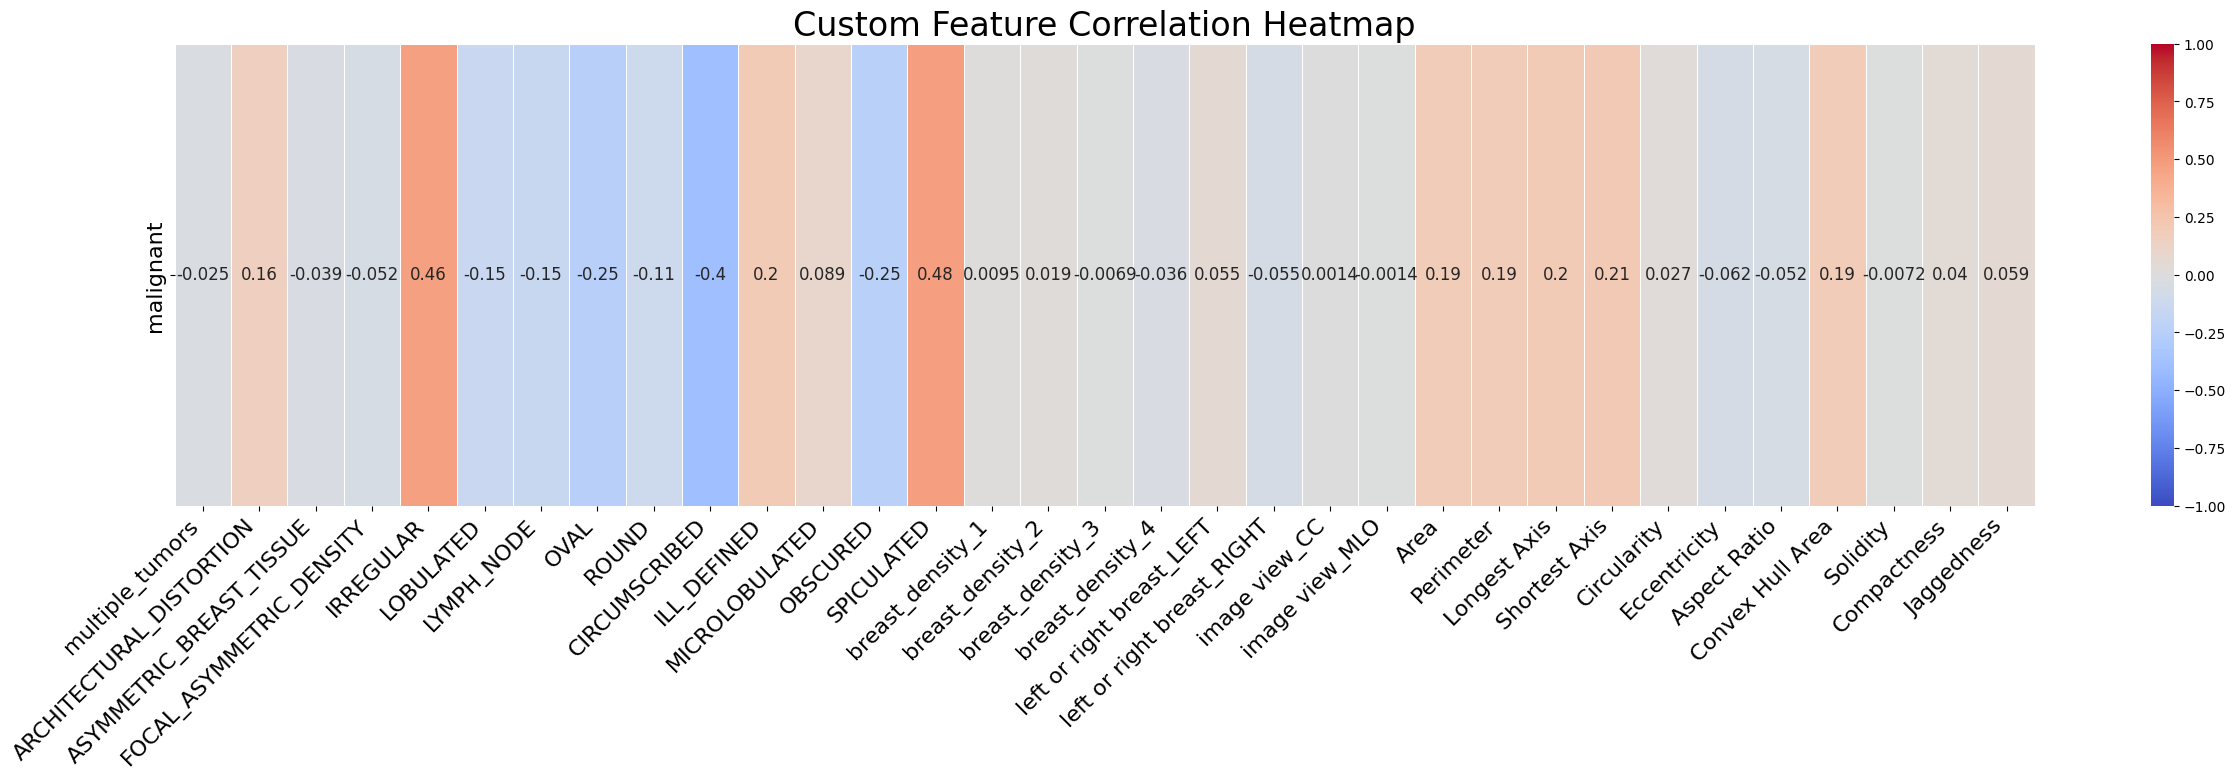

In [31]:
x_features = ['multiple_tumors','ARCHITECTURAL_DISTORTION', 'ASYMMETRIC_BREAST_TISSUE',
              'FOCAL_ASYMMETRIC_DENSITY', 'IRREGULAR', 'LOBULATED', 'LYMPH_NODE',
              'OVAL', 'ROUND', 'CIRCUMSCRIBED', 'ILL_DEFINED', 'MICROLOBULATED',
              'OBSCURED', 'SPICULATED', 'breast_density_1', 'breast_density_2',
              'breast_density_3', 'breast_density_4', 'left or right breast_LEFT',
              'left or right breast_RIGHT', 'image view_CC', 'image view_MLO', 'Area', 'Perimeter',
              'Longest Axis', 'Shortest Axis', 'Circularity', 'Eccentricity',
              'Aspect Ratio', 'Convex Hull Area', 'Solidity', 'Compactness',
              'Jaggedness']
y_features = ['malignant']

correlation_subset = mass_roi_one_hot[x_features + y_features].corr().loc[y_features, x_features]

plt.figure(figsize=(30, 6))
sns.heatmap(correlation_subset, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
            linewidths=0.5, annot_kws={"size": 12})

plt.title('Custom Feature Correlation Heatmap', fontsize=24)


plt.xticks(fontsize=16, rotation=45, ha='right')
plt.yticks(fontsize=16)

plt.show()


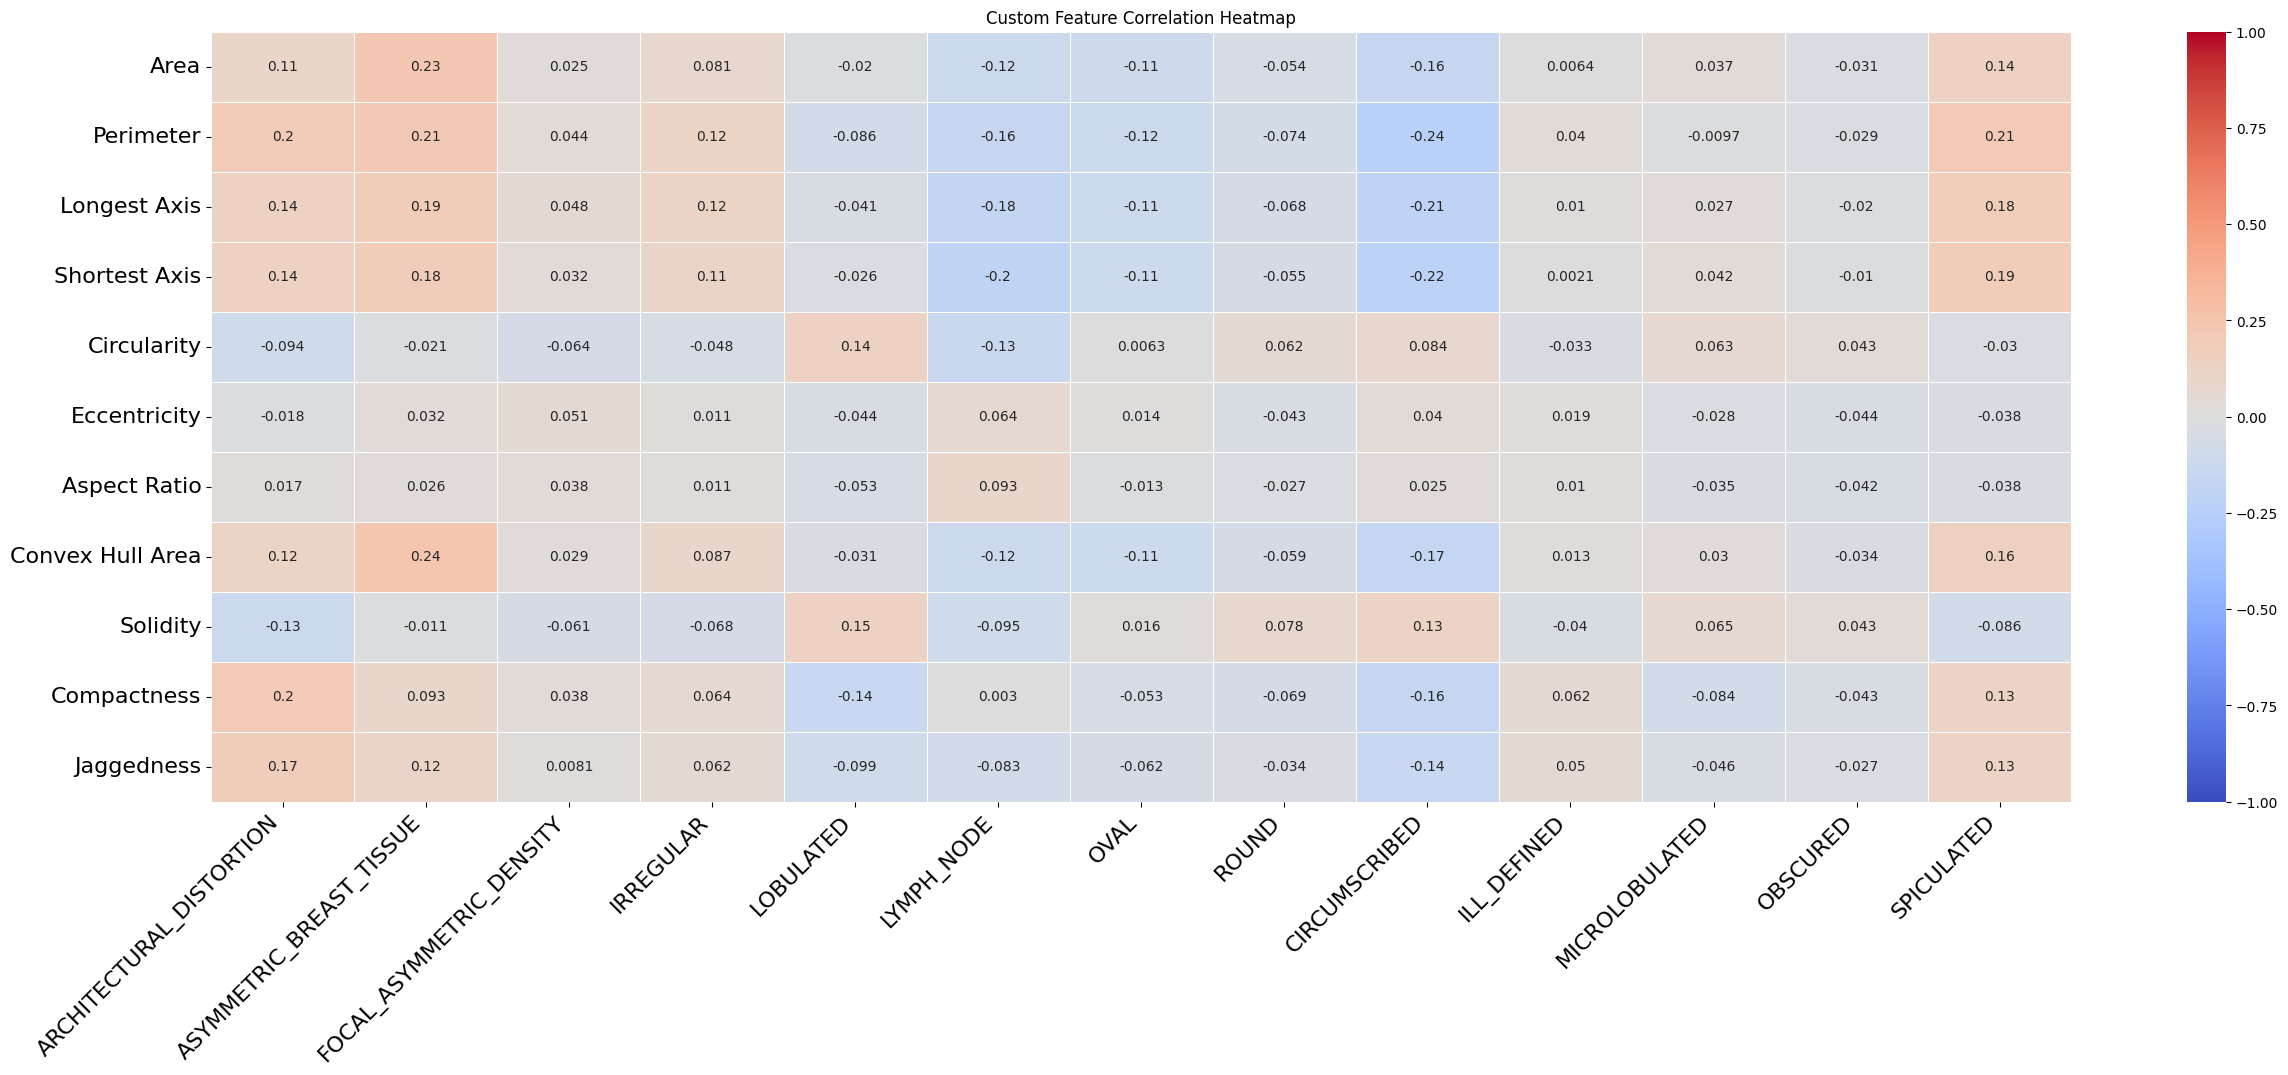

In [55]:
 ax_features = ['ARCHITECTURAL_DISTORTION', 'ASYMMETRIC_BREAST_TISSUE',
       'FOCAL_ASYMMETRIC_DENSITY', 'IRREGULAR', 'LOBULATED', 'LYMPH_NODE',
       'OVAL', 'ROUND', 'CIRCUMSCRIBED', 'ILL_DEFINED', 'MICROLOBULATED',
       'OBSCURED', 'SPICULATED']
y_features = ['Area', 'Perimeter', 'Longest Axis', 'Shortest Axis', 'Circularity',
       'Eccentricity', 'Aspect Ratio', 'Convex Hull Area', 'Solidity',
       'Compactness', 'Jaggedness']

correlation_subset = mass_roi_one_hot[x_features + y_features].corr().loc[y_features, x_features]

plt.figure(figsize=(30, 10))
sns.heatmap(correlation_subset, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Custom Feature Correlation Heatmap')
plt.xticks(fontsize=16, rotation=45, ha='right')
plt.yticks(fontsize=16)

plt.show()


## ROI Features Only

In [ ]:
roi_df = pd.read_csv('/content/drive/MyDrive/DDSM data/tumor_all_features_new.csv', sep = ',')

In [ ]:
roi_df.describe()

Area     Perimeter  Longest Axis  Shortest Axis  Circularity  \
count  3.247000e+03   3247.000000   3247.000000    3247.000000  3247.000000   
mean   1.447114e+05   1697.897819    425.016989     296.392706     0.811457   
std    3.931890e+05   1273.966601    409.890242     242.930616     0.125830   
min    1.017000e+03    118.627417     35.990875      32.085304     0.078521   
25%    2.774700e+04    885.205186    218.840706     164.684456     0.766605   
50%    5.698100e+04   1419.851936    310.866394     241.080063     0.831359   
75%    1.171410e+05   2087.935196    456.268814     348.704514     0.892397   
max    8.876129e+06  11720.279012   5387.432617    3592.091797     0.988083   

       Eccentricity  Aspect Ratio  Convex Hull Area     Solidity  Compactness  \
count   3247.000000   3247.000000      3.247000e+03  3247.000000  3247.000000   
mean       0.606782      1.438087      1.608768e+05     0.900081     2.894270   
std        0.173998      0.697657      4.110871e+05     0.090210     1.814265   
min        0.059071      1.001749      9.600000e+02     0.163548     1.073371   
25%        0.487518      1.145327      3.097700e+04     0.851927     1.361278   
50%        0.603407      1.254024      6.439050e+04     0.911441     2.500885   
75%        0.726951      1.456262      1.298698e+05     0.972827     4.006028   
max        0.997057     13.044484      8.926682e+06     1.059375    19.892491   

        Jaggedness  
count  3247.000000  
mean      1.328033  
std       0.266001  
min       1.000000  
25%       1.076157  
50%       1.280246  
75%       1.555182  
max       2.691573

In [ ]:
roi_df['File'] = roi_df['File'].str.replace('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/', '', regex=False)
roi_df['File'] = roi_df['File'].str[:-10]
roi_df

File    Area    Perimeter  \
0     1.3.6.1.4.1.9590.100.1.2.153339052913121382622...   73049  1283.009228   
1     1.3.6.1.4.1.9590.100.1.2.178994714611485132105...  101746  1789.962546   
2     1.3.6.1.4.1.9590.100.1.2.411833492612373627114...  589897  3774.552508   
3     1.3.6.1.4.1.9590.100.1.2.236373548712994183418...   68387  1588.143347   
4     1.3.6.1.4.1.9590.100.1.2.357008050412534761329...   90204  1971.030649   
...                                                 ...     ...          ...   
3242  1.3.6.1.4.1.9590.100.1.2.374221285124370132151...   94457  1310.943213   
3243  1.3.6.1.4.1.9590.100.1.2.195242971118587811360...  159411  2724.965845   
3244  1.3.6.1.4.1.9590.100.1.2.263713351013050806016...   81133  2060.417513   
3245  1.3.6.1.4.1.9590.100.1.2.627982547125586065005...  292333  3959.809764   
3246  1.3.6.1.4.1.9590.100.1.2.285138900913160236325...  333421  3571.923339   

      Longest Axis  Shortest Axis  Circularity  Eccentricity  Aspect Ratio  \
0       455.738892     219.047836     0.754487      0.876916      2.080545   
1       617.249329     263.515625     0.569651      0.904290      2.342363   
2      1183.508545     732.803162     0.760715      0.785250      1.615043   
3       321.272156     282.759125     0.839021      0.474745      1.136204   
4       439.072510     266.375885     0.806350      0.794947      1.648319   
...            ...            ...          ...           ...           ...   
3242    385.952026     310.660858     0.949397      0.593382      1.242358   
3243    493.527313     417.691406     0.837700      0.532645      1.181560   
3244    353.669312     317.221832     0.787833      0.442143      1.114896   
3245   1825.662231     273.368073     0.274839      0.988726      6.678403   
3246    717.127441     599.862793     0.886793      0.547997      1.195486   

      Convex Hull Area  Solidity  Compactness  Jaggedness  
0              77376.0  0.944078     1.793228    1.170973  
1             131312.5  0.774839     2.505882    1.155898  
2             642880.0  0.917585     1.921962    1.202108  
3              77519.5  0.882191     2.934918    1.441575  
4             102234.5  0.882324     3.427292    1.537265  
...                ...       ...          ...         ...  
3242           96864.0  0.975151     1.447851    1.186748  
3243          180701.0  0.882181     3.706756    1.544532  
3244           96028.0  0.844889     4.163927    1.627702  
3245          379375.5  0.770564     4.268359    1.085430  
3246          366520.5  0.909693     3.045099    1.563583  

[3247 rows x 12 columns]

In [ ]:
mass_roi = result_mass
mass_roi['ROI mask file path'] = mass_roi['ROI mask file path'].str[:-12]
mass_roi['ROI mask file path'] = mass_roi['ROI mask file path'].apply(remove_up_to_second_slash)
mass_roi

patient_id  breast_density left or right breast image view  \
0       P_00001               3                 LEFT         CC   
1       P_00001               3                 LEFT        MLO   
2       P_00004               3                 LEFT         CC   
3       P_00004               3                 LEFT        MLO   
4       P_00004               3                RIGHT        MLO   
...         ...             ...                  ...        ...   
1691    P_01825               2                RIGHT        MLO   
1692    P_01833               2                RIGHT        MLO   
1693    P_01865               2                 LEFT        MLO   
1694    P_01912               3                RIGHT         CC   
1695    P_01912               3                RIGHT        MLO   

     abnormality id abnormality type  assessment  pathology  subtlety  \
0                 1             mass           4  MALIGNANT         4   
1                 1             mass           4  MALIGNANT         4   
2                 1             mass           4     BENIGN         3   
3                 1             mass           4     BENIGN         3   
4                 1             mass           4     BENIGN         5   
...             ...              ...         ...        ...       ...   
1691              1             mass           3     BENIGN         3   
1692              1             mass           5  MALIGNANT         5   
1693              1             mass           4  MALIGNANT         2   
1694              1             mass           5  MALIGNANT         4   
1695              1             mass           5  MALIGNANT         4   

                                        image file path  ... LOBULATED  \
0     Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...  ...         0   
1     Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...  ...         0   
2     Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...  ...         0   
3     Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...  ...         0   
4     Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...  ...         0   
...                                                 ...  ...       ...   
1691  Mass-Test_P_01825_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...         1   
1692  Mass-Test_P_01833_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...         0   
1693  Mass-Test_P_01865_LEFT_MLO/1.3.6.1.4.1.9590.10...  ...         0   
1694  Mass-Test_P_01912_RIGHT_CC/1.3.6.1.4.1.9590.10...  ...         0   
1695  Mass-Test_P_01912_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...         0   

     LYMPH_NODE  OVAL  ROUND  CIRCUMSCRIBED  ILL_DEFINED  MICROLOBULATED  \
0             0     0      0              0            0               0   
1             0     0      0              0            0               0   
2             0     0      0              0            1               0   
3             0     0      0              0            1               0   
4             0     1      0              1            0               0   
...         ...   ...    ...            ...          ...             ...   
1691          0     0      0              0            0               1   
1692          0     0      0              0            1               0   
1693          0     0      0              0            1               0   
1694          0     0      0              0            0               0   
1695          0     0      0              0            0               0   

      OBSCURED  SPICULATED  malignant  
0            0           1          1  
1            0           1          1  
2            0           0          0  
3            0           0          0  
4            0           0          0  
...        ...         ...        ...  
1691         0           0          0  
1692         0           0          1  
1693         0           0          1  
1694         0           1          1  
1695         0           1          1  

[1696 rows x 28 columns]

In [ ]:
mass_roi = mass_roi.merge(roi_df, left_on='ROI mask file path', right_on='File', how='left')
mass_roi

patient_id  breast_density left or right breast image view  \
0       P_00001               3                 LEFT         CC   
1       P_00001               3                 LEFT        MLO   
2       P_00004               3                 LEFT         CC   
3       P_00004               3                 LEFT        MLO   
4       P_00004               3                RIGHT        MLO   
...         ...             ...                  ...        ...   
1691    P_01825               2                RIGHT        MLO   
1692    P_01833               2                RIGHT        MLO   
1693    P_01865               2                 LEFT        MLO   
1694    P_01912               3                RIGHT         CC   
1695    P_01912               3                RIGHT        MLO   

     abnormality id abnormality type  assessment  pathology  subtlety  \
0                 1             mass           4  MALIGNANT         4   
1                 1             mass           4  MALIGNANT         4   
2                 1             mass           4     BENIGN         3   
3                 1             mass           4     BENIGN         3   
4                 1             mass           4     BENIGN         5   
...             ...              ...         ...        ...       ...   
1691              1             mass           3     BENIGN         3   
1692              1             mass           5  MALIGNANT         5   
1693              1             mass           4  MALIGNANT         2   
1694              1             mass           5  MALIGNANT         4   
1695              1             mass           5  MALIGNANT         4   

                                        image file path  ...    Perimeter  \
0     Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...  ...  3085.887637   
1     Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...  ...  1200.236712   
2     Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...  ...  2766.321184   
3     Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...  ...  3002.002423   
4     Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...  ...  2394.372918   
...                                                 ...  ...          ...   
1691  Mass-Test_P_01825_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...  1272.999124   
1692  Mass-Test_P_01833_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...  2312.975950   
1693  Mass-Test_P_01865_LEFT_MLO/1.3.6.1.4.1.9590.10...  ...  1438.597103   
1694  Mass-Test_P_01912_RIGHT_CC/1.3.6.1.4.1.9590.10...  ...  2487.897742   
1695  Mass-Test_P_01912_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...  1767.155540   

     Longest Axis  Shortest Axis  Circularity  Eccentricity  Aspect Ratio  \
0      436.138031     371.961121     0.787288      0.522153      1.172537   
1      216.311172     199.950745     0.777106      0.381506      1.081822   
2      397.924713     368.702179     0.818572      0.376140      1.079258   
3      358.107056     331.877808     0.766013      0.375664      1.079033   
4      386.666870     313.786041     0.785112      0.584331      1.232263   
...           ...            ...          ...           ...           ...   
1691   225.898102     164.048126     0.738653      0.687479      1.377023   
1692   494.025787     442.596893     0.895535      0.444259      1.116198   
1693   296.116455     154.561035     0.565147      0.852970      1.915855   
1694   384.267700     330.945831     0.808170      0.508202      1.161120   
1695   349.156158     278.260223     0.767926      0.604044      1.254783   

      Convex Hull Area  Solidity  Compactness  Jaggedness  
0             144944.5  0.831774     6.285553    1.918282  
1              38948.5  0.826681     3.560369    1.394815  
2             132114.5  0.857506     5.375361    1.842405  
3             111371.0  0.803396     8.015129    1.902236  
4             109045.5  0.841465     4.971985    1.673093  
...                ...       ...          ...         ...  
1691           33468.5  0.812495     4.742302    1.53

In [ ]:
mass_roi = mass_roi[['patient_id', 'tumor_id', 'malignant','abnormality id', 'Area',	'Perimeter',	'Longest Axis',	'Shortest Axis',	'Circularity',	'Eccentricity',	'Aspect Ratio',	'Convex Hull Area',	'Solidity',	'Compactness',	'Jaggedness']]
mass_roi


patient_id  tumor_id  malignant abnormality id    Area    Perimeter  \
0       P_00001         1          1              1  120561  3085.887637   
1       P_00001         2          1              1   32198  1200.236712   
2       P_00004         3          0              1  113289  2766.321184   
3       P_00004         4          0              1   89475  3002.002423   
4       P_00004         5          0              1   91758  2394.372918   
...         ...       ...        ...            ...     ...          ...   
1691    P_01825      1692          0              1   27193  1272.999124   
1692    P_01833      1693          1              1  168651  2312.975950   
1693    P_01865      1694          1              1   28921  1438.597103   
1694    P_01912      1695          1              1   97350  2487.897742   
1695    P_01912      1696          1              1   70566  1767.155540   

      Longest Axis  Shortest Axis  Circularity  Eccentricity  Aspect Ratio  \
0       436.138031     371.961121     0.787288      0.522153      1.172537   
1       216.311172     199.950745     0.777106      0.381506      1.081822   
2       397.924713     368.702179     0.818572      0.376140      1.079258   
3       358.107056     331.877808     0.766013      0.375664      1.079033   
4       386.666870     313.786041     0.785112      0.584331      1.232263   
...            ...            ...          ...           ...           ...   
1691    225.898102     164.048126     0.738653      0.687479      1.377023   
1692    494.025787     442.596893     0.895535      0.444259      1.116198   
1693    296.116455     154.561035     0.565147      0.852970      1.915855   
1694    384.267700     330.945831     0.808170      0.508202      1.161120   
1695    349.156158     278.260223     0.767926      0.604044      1.254783   

      Convex Hull Area  Solidity  Compactness  Jaggedness  
0             144944.5  0.831774     6.285553    1.918282  
1              38948.5  0.826681     3.560369    1.394815  
2             132114.5  0.857506     5.375361    1.842405  
3             111371.0  0.803396     8.015129    1.902236  
4             109045.5  0.841465     4.971985    1.673093  
...                ...       ...          ...         ...  
1691           33468.5  0.812495     4.742302    1.532302  
1692          179004.0  0.942163     2.524314    1.499830  
1693           40567.0  0.712919     5.694495    1.499211  
1694          112374.0  0.866304     5.059636    1.784758  
1695           85909.0  0.821404     3.521634    1.512729  

[1696 rows x 15 columns]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Specify the columns to be scaled
columns_to_scale = ['Area',	'Perimeter',	'Longest Axis',	'Shortest Axis',	'Circularity',	'Eccentricity',	'Aspect Ratio',	'Convex Hull Area',	'Solidity',	'Compactness',	'Jaggedness']

# Apply scaling only to the specified columns
mass_roi[columns_to_scale] = scaler.fit_transform(mass_roi[columns_to_scale])

<ipython-input-37-2157eaaaa6d9>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mass_roi[columns_to_scale] = scaler.fit_transform(mass_roi[columns_to_scale])


In [ ]:
mass_roi.describe()

tumor_id    malignant         Area    Perimeter  Longest Axis  \
count  1696.000000  1696.000000  1696.000000  1696.000000   1696.000000   
mean    848.500000     0.462264     0.059997     0.169112      0.209359   
std     489.737345     0.498721     0.064181     0.105355      0.112296   
min       1.000000     0.000000     0.000000     0.000000      0.000000   
25%     424.750000     0.000000     0.025961     0.102567      0.137580   
50%     848.500000     0.000000     0.042371     0.145367      0.185674   
75%    1272.250000     1.000000     0.069267     0.204526      0.249062   
max    1696.000000     1.000000     1.000000     1.000000      1.000000   

       Shortest Axis  Circularity  Eccentricity  Aspect Ratio  \
count    1696.000000  1696.000000   1696.000000   1696.000000   
mean        0.186538     0.688550      0.493368      0.079990   
std         0.096899     0.119222      0.179783      0.071953   
min         0.000000     0.000000      0.000000      0.000000   
25%         0.122806     0.620244      0.373955      0.036124   
50%         0.167487     0.696305      0.496863      0.062105   
75%         0.228339     0.768394      0.615045      0.100225   
max         1.000000     1.000000      1.000000      1.000000   

       Convex Hull Area     Solidity  Compactness   Jaggedness  
count       1696.000000  1696.000000  1696.000000  1696.000000  
mean           0.064133     0.613870     0.258786     0.309106  
std            0.067492     0.146370     0.122277     0.103344  
min            0.000000     0.000000     0.000000     0.000000  
25%            0.027986     0.518490     0.174933     0.246217  
50%            0.045528     0.618204     0.242695     0.307244  
75%            0.074318     0.713379     0.324913     0.364060  
max            1.000000     1.000000     1.000000     1.000000

In [ ]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Ridge Classifier": RidgeClassifier(),
    "Ada Boost Classifier": AdaBoostClassifier(),
    "Extra Trees Classifier": ExtraTreesClassifier(),
    "LightGBM": LGBMClassifier(),
    "XGBoost": XGBClassifier(),
    "Random Forest": RandomForestClassifier(),
    "K Neighbors Classifier": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "SVM - Linear": SVC(kernel='linear', probability=True),
    "Naive Bayes": GaussianNB()
}

num_runs = 100
n_splits = 10

for run in range(num_runs):
    # Shuffle and reset the index of the original DataFrame
    tumor_features_df_shuffled = mass_roi.sample(frac=1, random_state=42*run).reset_index(drop=True)

    # Features and target
    X = tumor_features_df_shuffled.drop(['malignant', 'patient_id', 'tumor_id', 'abnormality id'], axis=1)
    y = tumor_features_df_shuffled['malignant']
    groups = tumor_features_df_shuffled['patient_id']
    abnormality_ids = tumor_features_df_shuffled['abnormality id']
    tumor_id = tumor_features_df_shuffled['tumor_id']

    # Replace whitespaces in feature names with underscores
    X.columns = [col.replace(" ", "_") for col in X.columns]

    all_predictions = []

    # Get unique patient IDs
    unique_patient_ids = groups.unique()
    np.random.seed(42*run)  # Set seed for reproducibility

    # Shuffle the patient IDs
    np.random.shuffle(unique_patient_ids)

    # Split the patient IDs into folds
    fold_size = len(unique_patient_ids) // n_splits
    predefined_splits = []

    for fold in range(n_splits):
        test_ids = unique_patient_ids[fold * fold_size: (fold + 1) * fold_size]
        train_ids = np.setdiff1d(unique_patient_ids, test_ids)
        predefined_splits.append((train_ids, test_ids))

    # Handle any patient IDs not included in the folds
    all_test_ids = np.concatenate([test_ids for _, test_ids in predefined_splits])
    missing_ids = np.setdiff1d(unique_patient_ids, all_test_ids)
    print(missing_ids)
    if len(missing_ids) > 0:
        for missing_id in missing_ids:
            random_fold = np.random.choice(n_splits)
            train_ids, test_ids = predefined_splits[random_fold]
            test_ids = np.append(test_ids, missing_id)
            predefined_splits[random_fold] = (train_ids, test_ids)

    group_kfold = GroupKFold(n_splits=n_splits)

    for model_name, model in models.items():
        original_model = copy.deepcopy(model) # run folds on og
        fold_count = 1
        all_model_predictions = []

        for fold_idx, (train_ids, test_ids) in enumerate(predefined_splits):
            model = copy.deepcopy(original_model)
            train_idx = groups.isin(train_ids)
            test_idx = groups.isin(test_ids)

            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            patient_ids = groups[test_idx]
            abnormality_test_ids = abnormality_ids[test_idx]
            tumor_id_test = tumor_id[test_idx]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            if hasattr(model, "predict_proba"):
                y_prob = model.predict_proba(X_test)[:, 1]
                for pid, ab_id, y_t, y_p, y_pr, t_id in zip(patient_ids, abnormality_test_ids, y_test, y_pred, y_prob, tumor_id_test):
                    all_model_predictions.append((pid, ab_id, y_t, y_p, y_pr, fold_count, t_id))
            else:
                for pid, ab_id, y_t, y_p, t_id in zip(patient_ids, abnormality_test_ids, y_test, y_pred, tumor_id_test):
                    all_model_predictions.append((pid, ab_id, y_t, y_p, None, fold_count, t_id))

            fold_count += 1

        predictions_df = pd.DataFrame(all_model_predictions, columns=['patient_id', 'abnormality id', 'y_true', 'y_pred', 'y_prob', 'fold_number', 'tumor_id'])

        # Include only the specified columns
        predictions_df = predictions_df[['patient_id', 'abnormality id', 'y_true', 'y_pred', 'y_prob', 'fold_number', 'tumor_id']]

        predictions_df.to_csv(f'/content/drive/My Drive/DDSM data/DDSM_compareModels_Mass/Compare_models_image_features_only_2/Results_{model_name}_{run + 1}.csv', index=False)


['P_00054' 'P_01413']
['P_01510' 'P_01604']
['P_01264' 'P_01438']
['P_01312' 'P_01841']
['P_00886' 'P_01270']
['P_01000' 'P_01441']
['P_01238' 'P_01508']
['P_00431' 'P_01684']
['P_00644' 'P_00766']
['P_00419' 'P_01518']
['P_00039' 'P_00710']
['P_00359' 'P_01645']
['P_00984' 'P_01632']
['P_01506' 'P_01832']
['P_00122' 'P_01108']
['P_00893' 'P_00929']
['P_00099' 'P_01381']
['P_00648' 'P_01194']
['P_01213' 'P_01712']
['P_00495' 'P_00914']
['P_00064' 'P_00670']
['P_00347' 'P_00698']
['P_00949' 'P_01983']
['P_01406' 'P_01638']
['P_00816' 'P_01103']
['P_00849' 'P_01822']
['P_00086' 'P_00384']
['P_00054' 'P_00987']
['P_01152' 'P_01645']
['P_00917' 'P_01680']
['P_00630' 'P_00665']
['P_00741' 'P_01551']
['P_01327' 'P_01719']
['P_01109' 'P_01204']
['P_00208' 'P_01330']
['P_00296' 'P_01656']
['P_00219' 'P_01620']
['P_01493' 'P_02092']
['P_00273' 'P_01079']
['P_00413' 'P_00702']
['P_01482' 'P_01599']
['P_00980' 'P_01785']
['P_00158' 'P_00596']
['P_00453' 'P_00765']
['P_00238' 'P_01257']
['P_01434'

In [ ]:
# Define the path to your CSV files
base_path = '/content/drive/My Drive/DDSM data/DDSM_compareModels_Mass/Compare_models_image_features_only_2/'

# Define the models
models = [
    "Logistic Regression", "Linear Discriminant Analysis", "Ridge Classifier",
    "Ada Boost Classifier", "Extra Trees Classifier", "LightGBM",
    "XGBoost", "Random Forest", "K Neighbors Classifier",
    "Decision Tree", "SVM - Linear", "Naive Bayes"
]

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_prob=None):
    metrics = {}
    if len(y_true) > 0:  # Check if y_true has at least one sample
        metrics['accuracy'] = accuracy_score(y_true, y_pred)
        metrics['recall'] = recall_score(y_true, y_pred)
        metrics['precision'] = precision_score(y_true, y_pred)
        metrics['f1_score'] = f1_score(y_true, y_pred)
    else:
        metrics['accuracy'] = None
        metrics['recall'] = None
        metrics['precision'] = None
        metrics['f1_score'] = None

    if y_prob is not None:
        valid_indices = ~np.isnan(y_prob)  # Find indices where y_prob is not NaN
        if len(y_true[valid_indices]) > 0:  # Check if y_true has at least one non-NaN sample
            metrics['auc'] = roc_auc_score(y_true[valid_indices], y_prob[valid_indices])
        else:
            metrics['auc'] = None
    else:
        metrics['auc'] = None

    return metrics


# Initialize a dictionary to store the results
results = {model: [] for model in models}

# Read and process each CSV file
for model_name in models:
    for run in range(1, 101):
        file_path = os.path.join(base_path, f'Results_{model_name}_{run}.csv')
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            y_true = df['y_true']
            y_pred = df['y_pred']
            y_prob = df['y_prob'] if 'y_prob' in df.columns else None
            metrics = calculate_metrics(y_true, y_pred, y_prob)
            results[model_name].append(metrics)

# Calculate the average metrics for each model
average_results = {}
for model_name, metrics_list in results.items():
    valid_auc_values = [d['auc'] for d in metrics_list if d['auc'] is not None]
    avg_metrics = {
        'accuracy': sum(d['accuracy'] for d in metrics_list) / len(metrics_list),
        'recall': sum(d['recall'] for d in metrics_list) / len(metrics_list),
        'precision': sum(d['precision'] for d in metrics_list) / len(metrics_list),
        'f1_score': sum(d['f1_score'] for d in metrics_list) / len(metrics_list),
        'auc': sum(valid_auc_values) / len(valid_auc_values) if len(valid_auc_values) > 0 else None
    }
    average_results[model_name] = avg_metrics


# Create empty DataFrame
results_df = pd.DataFrame(columns=['Model', 'Metric', 'Value'])

# Calculate average and std for each metric
rows_to_concat = []

for model_name, metrics_list in results.items():
    avg_metrics = {
        'accuracy': sum(d['accuracy'] for d in metrics_list) / len(metrics_list),
        'precision': sum(d['precision'] for d in metrics_list) / len(metrics_list),
        'recall': sum(d['recall'] for d in metrics_list) / len(metrics_list),
        'f1_score': sum(d['f1_score'] for d in metrics_list) / len(metrics_list),
        'auc': sum(d['auc'] for d in metrics_list if d['auc'] is not None) / len([d for d in metrics_list if d['auc'] is not None]) if len([d for d in metrics_list if d['auc'] is not None]) > 0 else None
    }

    # Calculate standard deviation
    std_metrics = {
        'accuracy': np.std([d['accuracy'] for d in metrics_list]),
        'precision': np.std([d['precision'] for d in metrics_list]),
        'recall': np.std([d['recall'] for d in metrics_list]),
        'f1_score': np.std([d['f1_score'] for d in metrics_list]),
        'auc': np.std([d['auc'] for d in metrics_list if d['auc'] is not None])
    }

    # Add average metrics to DataFrame
    for metric, value in avg_metrics.items():
        if value is not None:
            rows_to_concat.append({'Model': model_name, 'Metric': metric, 'Value': value})

    # Add std metrics to DataFrame
    for metric, value in std_metrics.items():
        rows_to_concat.append({'Model': model_name, 'Metric': metric + '_std', 'Value': value})

# Concatenate the rows
results_df = pd.concat([results_df, pd.DataFrame(rows_to_concat)], ignore_index=True)

# Pivot the DataFrame for better readability
results_df = results_df.pivot(index='Model', columns='Metric', values='Value')

# Display the results DataFrame
results_df

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-40-c1155cbe0c3d>:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame(rows_to_concat)], ignore_index=True)


Metric                        accuracy  accuracy_std       auc   auc_std  \
Model                                                                      
Ada Boost Classifier          0.571604      0.007321  0.584732  0.007095   
Decision Tree                 0.529310      0.011357  0.526946  0.011349   
Extra Trees Classifier        0.559982      0.006734  0.571179  0.005662   
K Neighbors Classifier        0.556787      0.006738  0.565983  0.005877   
LightGBM                      0.569870      0.007688  0.587028  0.007401   
Linear Discriminant Analysis  0.595932      0.003684  0.626754  0.002872   
Logistic Regression           0.595377      0.003256  0.624144  0.003199   
Naive Bayes                   0.589888      0.002048  0.582178  0.005798   
Random Forest                 0.565896      0.007644  0.579203  0.006834   
Ridge Classifier              0.593255      0.002808       NaN       NaN   
SVM - Linear                  0.585112      0.002760  0.622170  0.003365   
XGBoost                       0.560454      0.008539  0.576122  0.008302   

Metric                        f1_score  f1_score_std  precision  \
Model                                                             
Ada Boost Classifier          0.485987      0.009948   0.545656   
Decision Tree                 0.493225      0.013123   0.491003   
Extra Trees Classifier        0.495000      0.008248   0.527211   
K Neighbors Classifier        0.504413      0.007700   0.522070   
LightGBM                      0.514707      0.009748   0.537873   
Linear Discriminant Analysis  0.493438      0.005323   0.586757   
Logistic Regression           0.450413      0.004646   0.605217   
Naive Bayes                   0.363481      0.003731   0.643251   
Random Forest                 0.497002      0.010226   0.535128   
Ridge Classifier              0.460033      0.004317   0.595393   
SVM - Linear                  0.347970      0.005418   0.636106   
XGBoost                       0.506849      0.010244   0.526497   

Metric                        precision_std    recall  recall_std  
Model                                                              
Ada Boost Classifier               0.010014  0.438189    0.011840  
Decision Tree                      0.012176  0.495625    0.016580  
Extra Trees Classifier             0.008293  0.466556    0.009660  
K Neighbors Classifier             0.007863  0.487959    0.008975  
LightGBM                           0.008959  0.493508    0.011490  
Linear Discriminant Analysis       0.005526  0.425753    0.005879  
Logistic Regression                0.006217  0.358686    0.004405  
Naive Bayes                        0.005739  0.253316    0.003045  
Random Forest                      0.009507  0.464031    0.012254  
Ridge Classifier                   0.004888  0.374834    0.004443  
SVM - Linear                       0.007815  0.239503    0.004366  
XGBoost                            0.010028  0.488699    0.012222